In [ ]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Wed Dec  9 01:53:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import csv
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
from glob import glob
import shutil
from collections import defaultdict
import time
import random

from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import os
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Image

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-12-09 03:14:56--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M   116MB/s    in 2.3s    

2020-12-09 03:14:58 (116 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
data_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(data_folders)

43

In [ ]:
# root_path = '/content/gdrive/My Drive/APS360-Team24/Traffic-Sign-Recognization/Dataset/GTSRB/'
root_path = '/content/'
lable_name = root_path + "label_names.csv"
print(lable_name)

/content/label_names.csv


In [ ]:
# !cd '/content/'
!pwd
!ls 
sign_names = pd.read_csv(lable_name)
# sign_names.set_index("ClassId")

/content
data_all	    GTSRB			     label_names.csv
feature_new.tar.gz  GTSRB_Final_Training_Images.zip  sample_data


In [ ]:
classLabels = list(sign_names["SignName"])
classIndex = list(sign_names["ClassId"])
print(len(classLabels))
print(len(classIndex))

43
43


In [ ]:
print(classLabels)

['Speed limit (20kmh)', 'Speed limit (30kmh)', 'Speed limit (50kmh)', 'Speed limit (60kmh)', 'Speed limit (70kmh)', 'Speed limit (80kmh)', 'End of speed limit (80kmh)', 'Speed limit (100kmh)', 'Speed limit (120kmh)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice or snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [ ]:
sorted(classLabels)

['Ahead only',
 'Beware of ice or snow',
 'Bicycles crossing',
 'Bumpy road',
 'Children crossing',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'End of all speed and passing limits',
 'End of no passing',
 'End of no passing by vehicles over 3.5 metric tons',
 'End of speed limit (80kmh)',
 'General caution',
 'Go straight or left',
 'Go straight or right',
 'Keep left',
 'Keep right',
 'No entry',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'No vehicles',
 'Pedestrians',
 'Priority road',
 'Right-of-way at the next intersection',
 'Road narrows on the right',
 'Road work',
 'Roundabout mandatory',
 'Slippery road',
 'Speed limit (100kmh)',
 'Speed limit (120kmh)',
 'Speed limit (20kmh)',
 'Speed limit (30kmh)',
 'Speed limit (50kmh)',
 'Speed limit (60kmh)',
 'Speed limit (70kmh)',
 'Speed limit (80kmh)',
 'Stop',
 'Traffic signals',
 'Turn left ahead',
 'Turn right ahead',
 'Vehicles over 3.5 metric tons prohibited',
 'Wild 

In [ ]:
new_class = sorted(classLabels)

In [ ]:
print(classIndex)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [ ]:
print(new_class[30])

Speed limit (20kmh)


In [ ]:
def countNumberofLine(rootpath, classNumber):
    prefix = rootpath + '/' + format(classNumber, '05d') + '/'  # subdirectory for class
    gtFile = open(prefix + 'GT-' + format(classNumber, '05d') + '.csv')  # annotations file
    # numline = len(gtFile.readlines())
    gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
    next(gtReader, None)
    # gtReader.next() # skip header
    # loop over all images in current annotations file
    row_count = sum(1 for row in gtReader)
    gtFile.close()
    return row_count
    
def readTrafficSigns_Training(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        data_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
        # print(prefix)
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader, None)
        print("Class: {}, Size is {}".format(c, countNumberofLine(rootpath,c)))
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

data_path = "GTSRB/Final_Training/Images"
images, labels = readTrafficSigns_Training(data_path)
print(len(images))
print(len(labels))

Class: 0, Size is 210
Class: 1, Size is 2220
Class: 2, Size is 2250
Class: 3, Size is 1410
Class: 4, Size is 1980
Class: 5, Size is 1860
Class: 6, Size is 420
Class: 7, Size is 1440
Class: 8, Size is 1410
Class: 9, Size is 1470
Class: 10, Size is 2010
Class: 11, Size is 1320
Class: 12, Size is 2100
Class: 13, Size is 2160
Class: 14, Size is 780
Class: 15, Size is 630
Class: 16, Size is 420
Class: 17, Size is 1110
Class: 18, Size is 1200
Class: 19, Size is 210
Class: 20, Size is 360
Class: 21, Size is 330
Class: 22, Size is 390
Class: 23, Size is 510
Class: 24, Size is 270
Class: 25, Size is 1500
Class: 26, Size is 600
Class: 27, Size is 240
Class: 28, Size is 540
Class: 29, Size is 270
Class: 30, Size is 450
Class: 31, Size is 780
Class: 32, Size is 240
Class: 33, Size is 689
Class: 34, Size is 420
Class: 35, Size is 1200
Class: 36, Size is 390
Class: 37, Size is 210
Class: 38, Size is 2070
Class: 39, Size is 300
Class: 40, Size is 360
Class: 41, Size is 240
Class: 42, Size is 240
3920

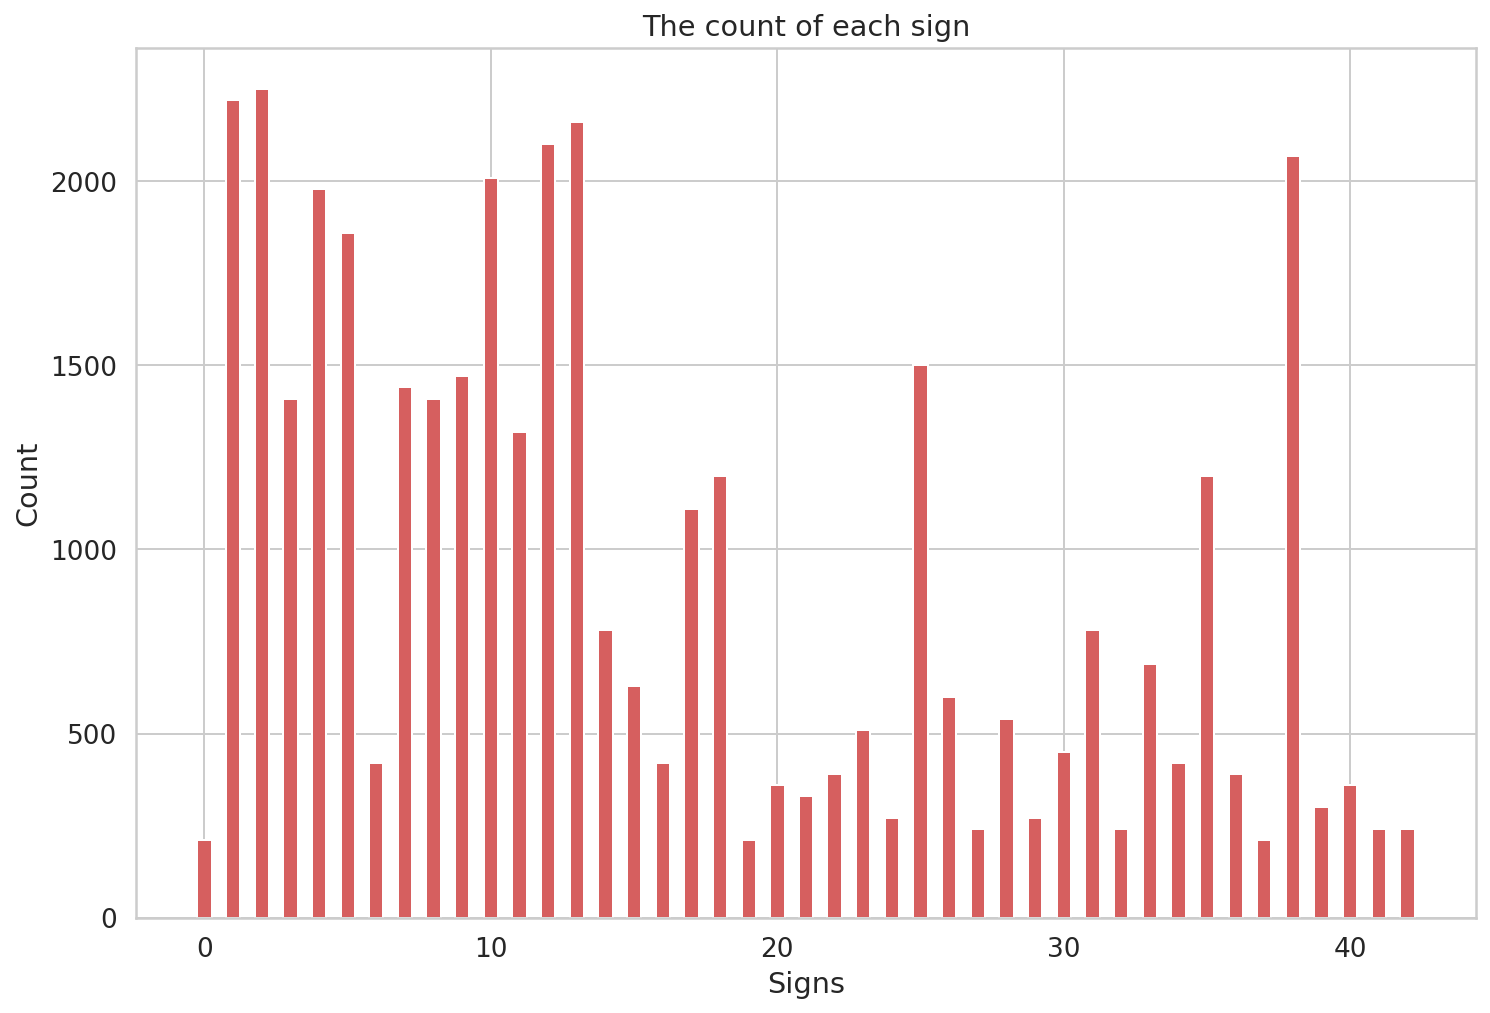

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(set(labels))), np.bincount(labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

# Data Augmentation

In [ ]:
print(data_folders)

['GTSRB/Final_Training/Images/00000', 'GTSRB/Final_Training/Images/00001', 'GTSRB/Final_Training/Images/00002', 'GTSRB/Final_Training/Images/00003', 'GTSRB/Final_Training/Images/00004', 'GTSRB/Final_Training/Images/00005', 'GTSRB/Final_Training/Images/00006', 'GTSRB/Final_Training/Images/00007', 'GTSRB/Final_Training/Images/00008', 'GTSRB/Final_Training/Images/00009', 'GTSRB/Final_Training/Images/00010', 'GTSRB/Final_Training/Images/00011', 'GTSRB/Final_Training/Images/00012', 'GTSRB/Final_Training/Images/00013', 'GTSRB/Final_Training/Images/00014', 'GTSRB/Final_Training/Images/00015', 'GTSRB/Final_Training/Images/00016', 'GTSRB/Final_Training/Images/00017', 'GTSRB/Final_Training/Images/00018', 'GTSRB/Final_Training/Images/00019', 'GTSRB/Final_Training/Images/00020', 'GTSRB/Final_Training/Images/00021', 'GTSRB/Final_Training/Images/00022', 'GTSRB/Final_Training/Images/00023', 'GTSRB/Final_Training/Images/00024', 'GTSRB/Final_Training/Images/00025', 'GTSRB/Final_Training/Images/00026', 

image is GTSRB/Final_Training/Images/00035/00036_00001.ppm
(30, 30, 3)


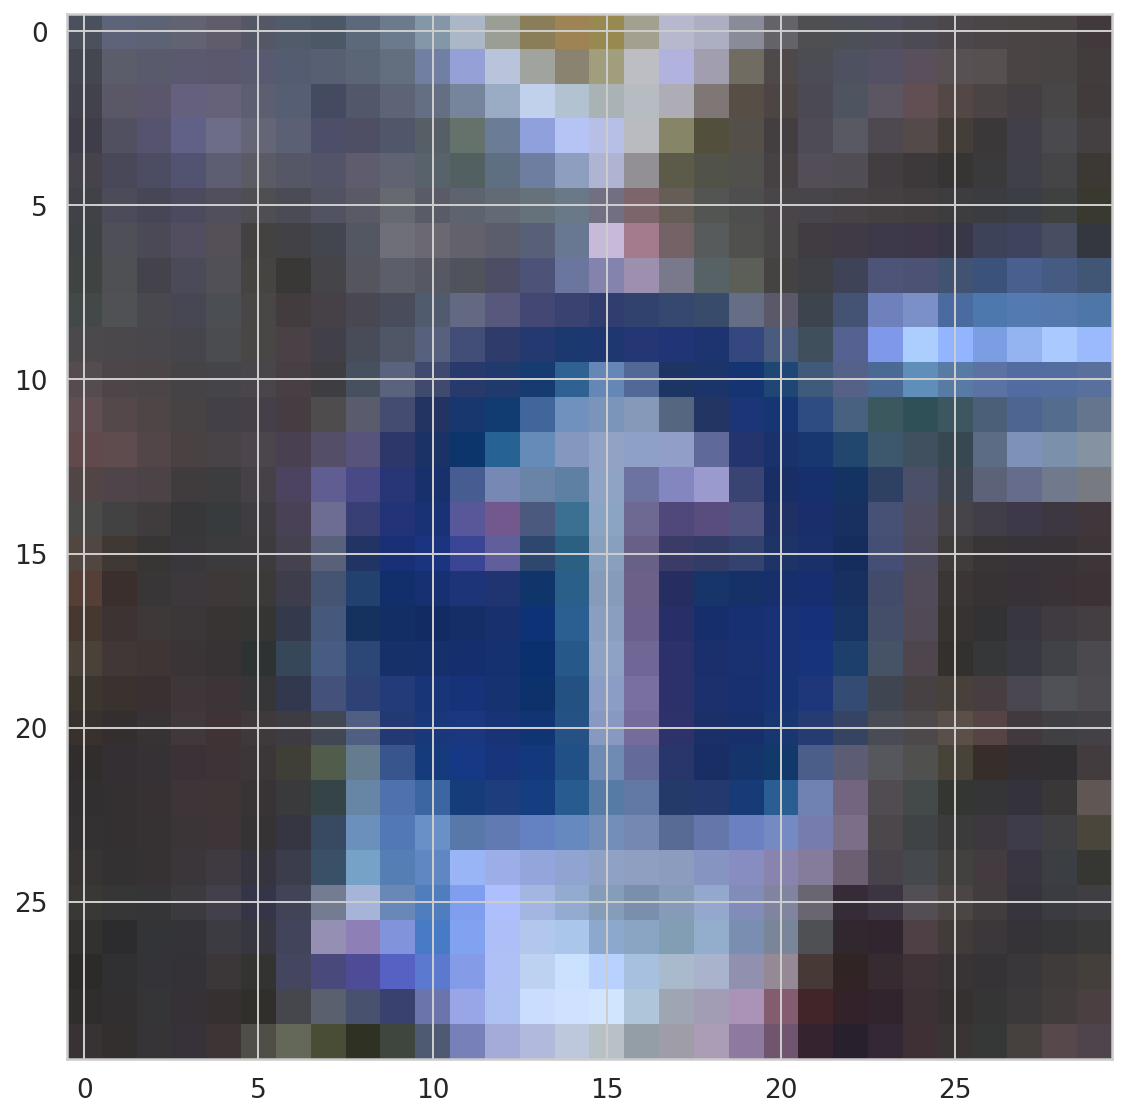

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')


first_class_path = data_folders[0] + '/*'
first_class_path = sorted(glob(first_class_path))
index = random.randint(0, len(data_folders) - 1)
image = np.random.choice((glob(f'{data_folders[35]}/*ppm')))
print("image is " + image)

image = io.imread(image)
print(image.shape)

# displaying the image
io.imshow(image)

### **Rotate Imag**

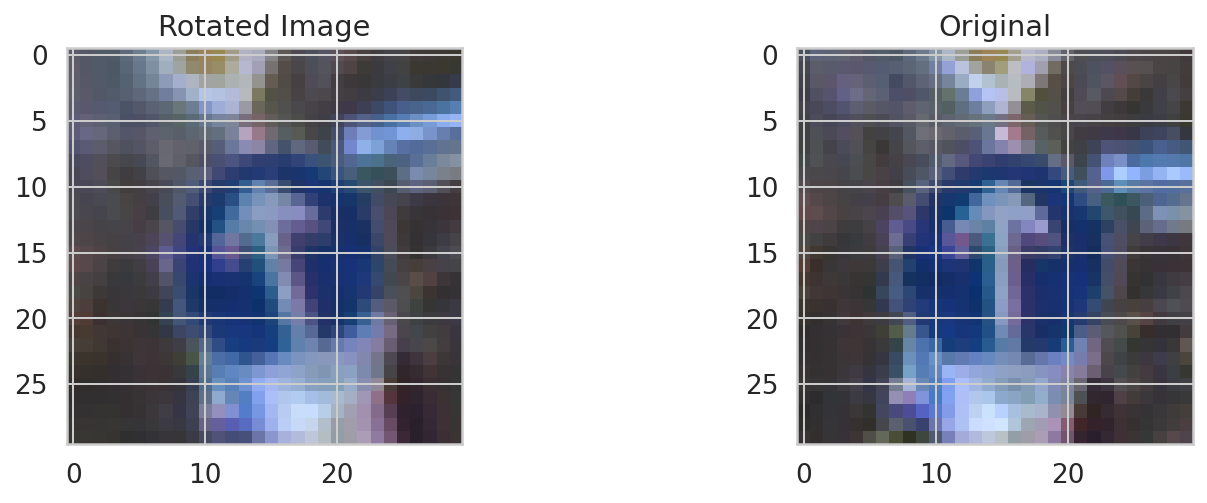

In [ ]:
#rotating the image by 45 degrees
def rotate_image(image, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    # print("angle is "+ str(angle))
    rotate_out = rotate(image, max_angle, mode='edge')
    return rotate_out
    
# rotated = rotate(image, angle=45, mode = 'wrap')
rotated = rotate_image(image)

plt.subplot(2,2,1)
plt.imshow(rotated)
plt.title('Rotated Image')
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

from skimage.transform import rotate



### **shifting imag**

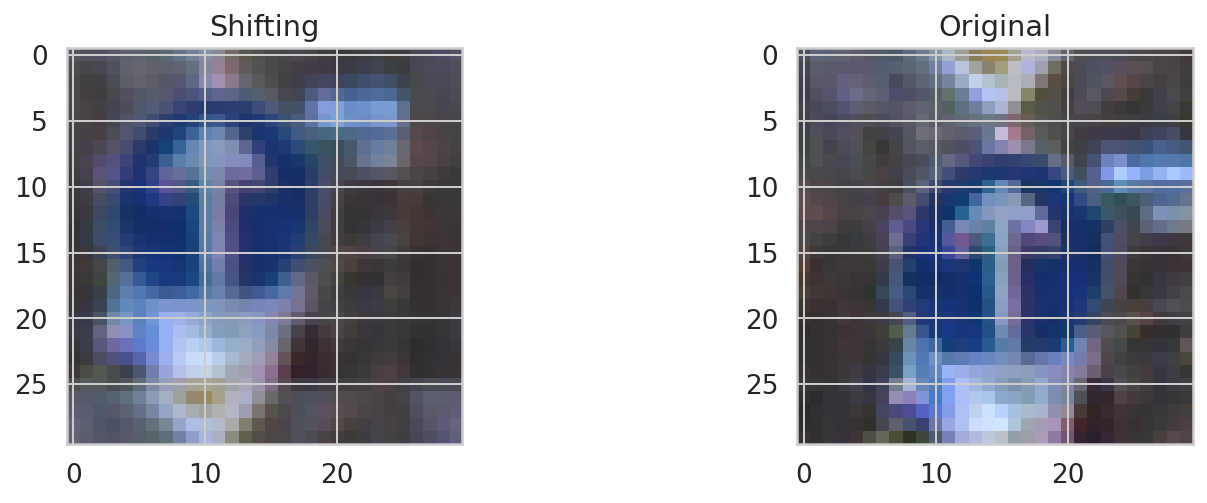

In [ ]:
#apply shift operation
def shift_image(image, max_offset=5):
    offset = np.random.uniform(-max_offset, max_offset)
    # print("offset is "+ str(offset))
    transform = AffineTransform(translation=(offset,offset))
    return transform

# transform = AffineTransform(translation=(5,5))
transform = shift_image(image);
wrapShift = warp(image,transform,mode='wrap')

plt.subplot(2,2,1)
plt.imshow(wrapShift)
plt.title('Shifting')
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

### **Flipping the imag (Not using)**

**right to left**

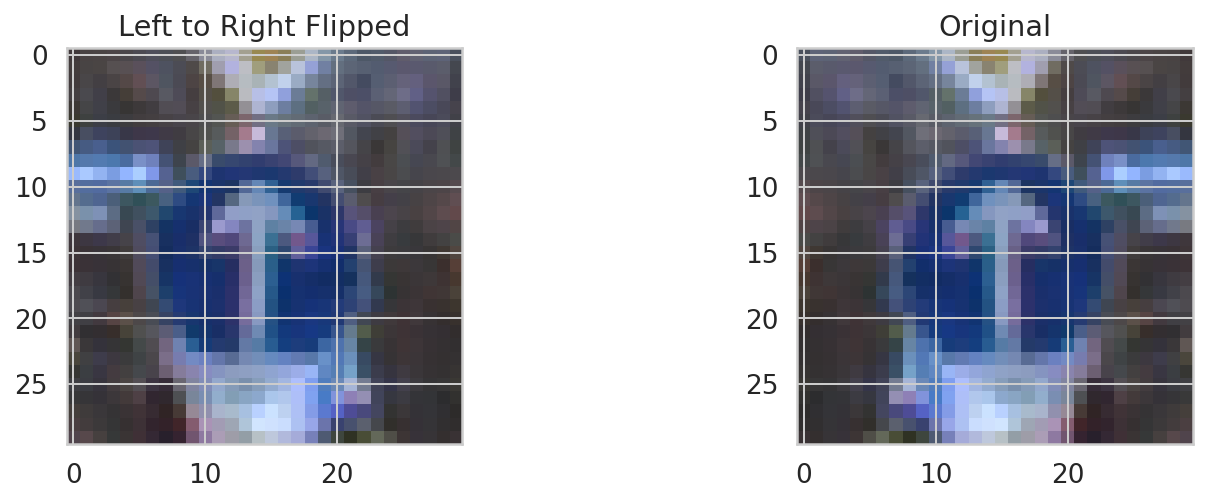

In [ ]:
#flip image left-to-right
flipLR = np.fliplr(image)

plt.subplot(2,2,1)
plt.imshow(flipLR)
plt.title('Left to Right Flipped')
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

**Flipping image up to down**

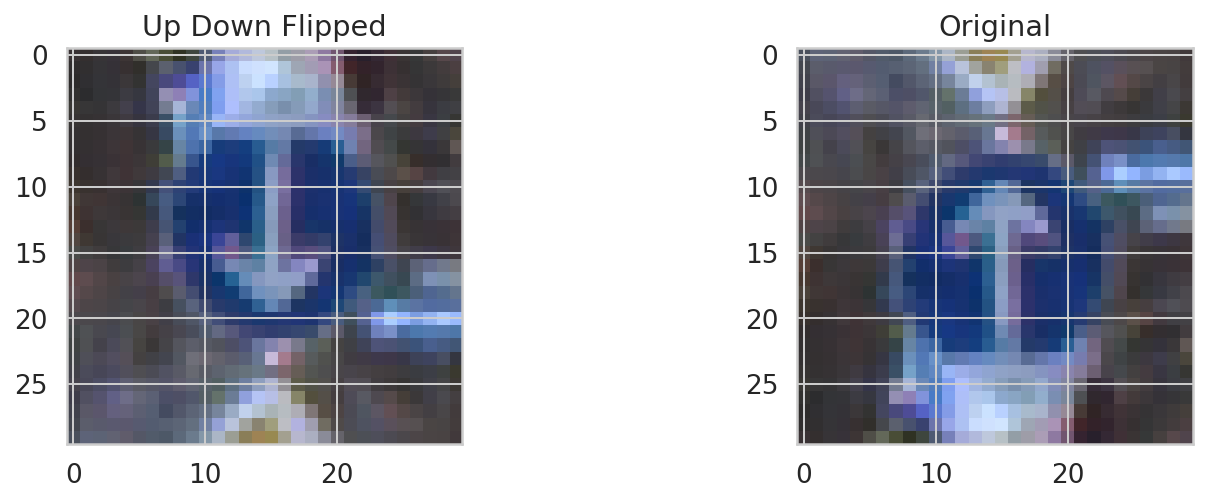

In [ ]:
#flip image up-to-down
flipUD = np.flipud(image)

plt.subplot(2,2,1)
plt.imshow(flipUD)
plt.title('Up Down Flipped')
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

### **Add gaussian noise**

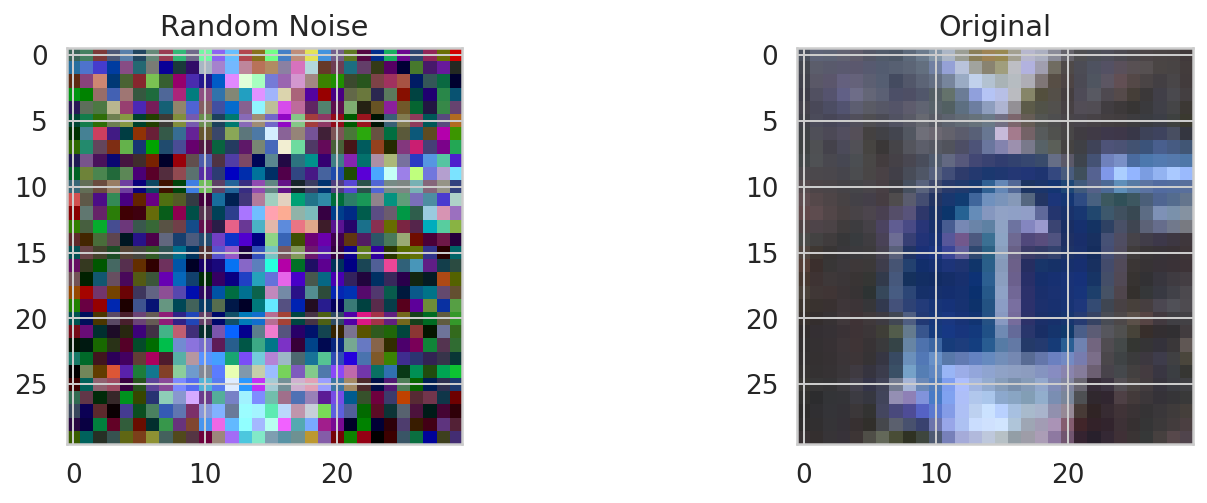

In [ ]:
#standard deviation for noise to be added in the image
def noising_image(image, max_offset=0.3,min_offset=0.1):
    sigma = np.random.uniform(min_offset, max_offset)
    # print("offset is "+ str(sigma))
    noisyRandom = random_noise(image,var=sigma**2)
    return noisyRandom
    
# sigma=0.2
#add random noise to the image
# noisyRandom = random_noise(image,var=sigma**2)
noisyRandom = noising_image(image)

plt.subplot(2,2,1)
plt.title('Random Noise')
plt.imshow(noisyRandom)
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

### **Blurring Images**

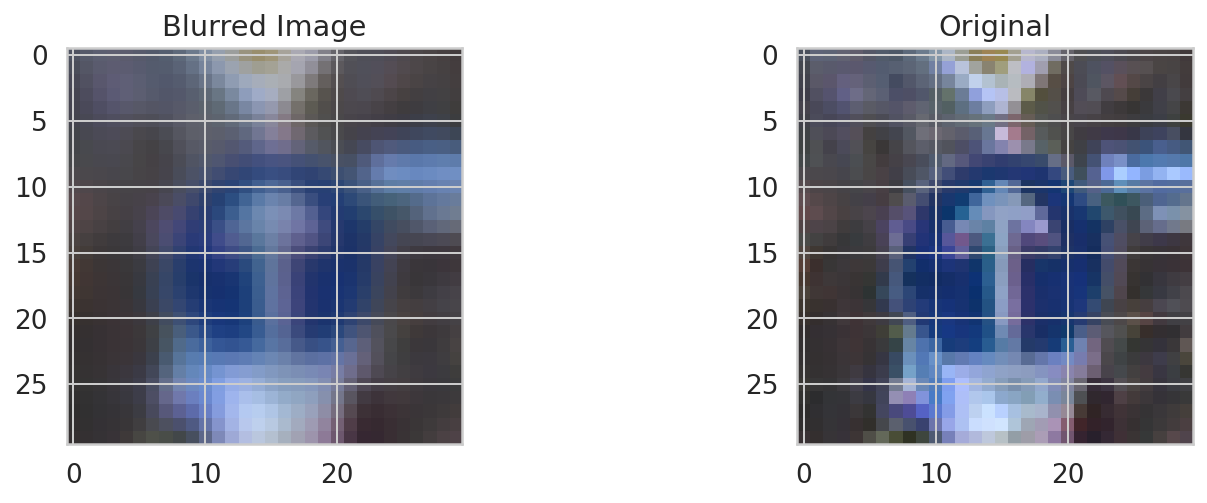

In [ ]:
#blur the image
def gaussian_image(image, max_offset=1,min_offset=0.1):
    sigma = np.random.uniform(min_offset, max_offset)
    # print("offset is "+ str(sigma))
    blurred = gaussian(image,sigma,multichannel=True)
    return blurred

# sigma = 0
# blurred = gaussian(image,sigma,multichannel=True)
blurred = gaussian_image(image)

plt.subplot(2,2,1)
plt.imshow(blurred)
plt.title('Blurred Image')
plt.subplot(2,2,2)
plt.title('Original')
plt.imshow(image)

### **Projection Images**

max_warp: 1, height: 30, width: 30


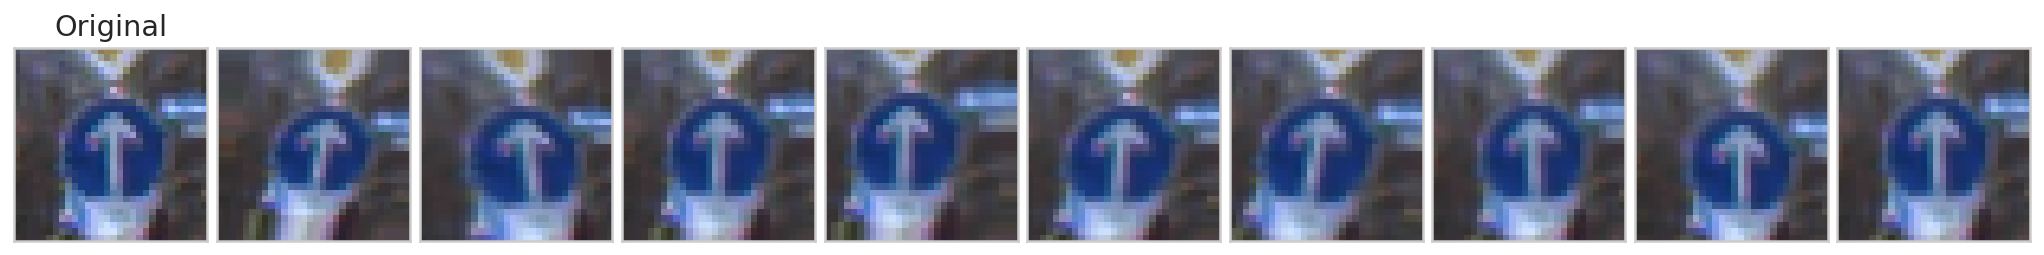

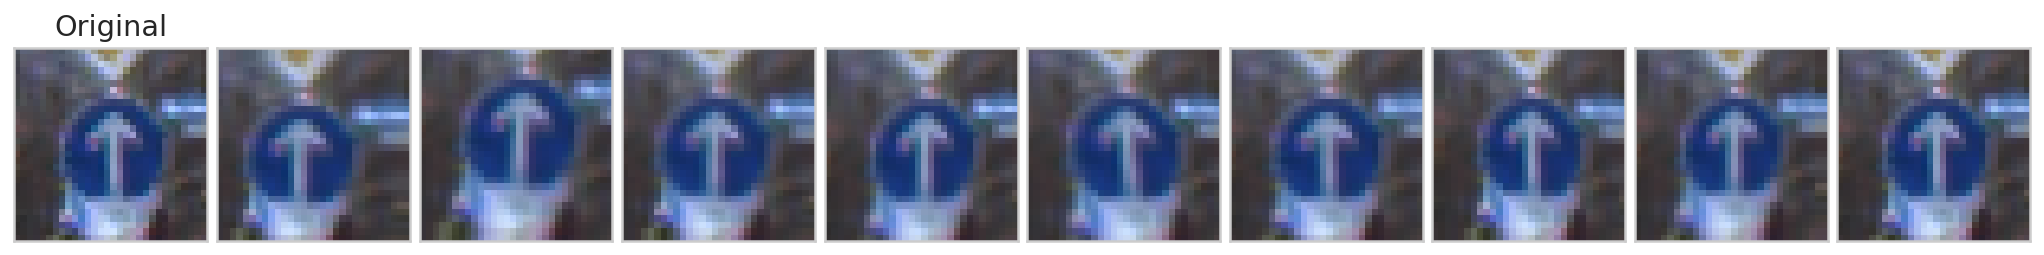

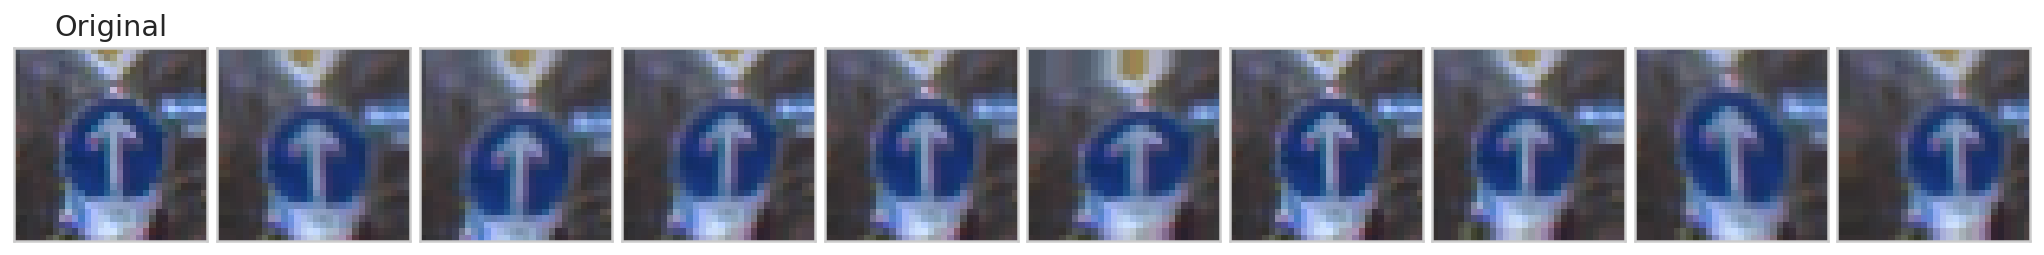

In [ ]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import cv2

def projection_transform(image, max_warp, height, width):
    # print("max_warp: {0}, height: {1}, width: {2}".format(max_warp,height, width))
    d = height * 0.2 * np.random.uniform(0,max_warp)
    
    # Top left corner, top margin
    tl_top = np.random.uniform(-d, d)   

    # Top left corner, left margin  
    tl_left = np.random.uniform(-d, d)   

    # Bottom left corner, bottom margin 
    bl_bottom = np.random.uniform(-d, d)  

    # Bottom left corner, left margin
    bl_left = np.random.uniform(-d, d)    

    # Top right corner, top margin
    tr_top = np.random.uniform(-d, d)     

     # Top right corner, right margin
    tr_right = np.random.uniform(-d, d)  

    # Bottom right corner, bottom margin
    br_bottom = np.random.uniform(-d, d)  

    # Bottom right corner, right margin
    br_right = np.random.uniform(-d, d)   
        
    transform = ProjectiveTransform()
    transform.estimate(np.array(((tl_left, tl_top),(bl_left, height - bl_bottom),(height - br_right, height - br_bottom), (height - tr_right, tr_top))), 
                       np.array(((0, 0),(0, height),(height, height),(height, 0))))
    
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    
no_examples = 3
max_warp = 1
img_height = image.shape[0]
img_width = image.shape[1]
print("max_warp: {0}, height: {1}, width: {2}".format(max_warp,img_height, img_width))

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(image)
            axis.title.set_text('Original')
        else:    
            axis.imshow(projection_transform(image,max_warp=max_warp, height=img_height, width=img_width))
    pyplot.show()
# plt.imshow(projection_transform(image,max_warp=max_warp, height=img_height, width=img_width))

# Save Imag to folder


In [ ]:
from skimage import img_as_ubyte
def save_augmented_images(images_count, class_folder, image):
  filename = "/" + str(images_count)
  final_path = class_folder + filename +'.ppm'
  print("folder is : " + final_path)
  # io.imsave(final_path, image)
  io.imsave(final_path,img_as_ubyte(image))
  # plt.imshow(image)


In [ ]:
# !ls
# # !unzip -qq GTSRB_Final_Training_Images.zip
# !rm -rf GTSRB
# ! rm -rf data_all/

# !rm -rf 'content/data_all'

In [ ]:
# !ls
# !rm -rf ./GTSRB/
# !unzip ./GTSRB_Final_Training_Images.zip 

In [ ]:
for class_folder in data_folders:
  
  #Get all images in one folder
  images = sorted(glob(class_folder + '/*.ppm'))
  #Get current count of images
  images_count = len(images);
  image_index = 0
  while images_count <= 2200:
    image = images[image_index]
    # print(image_index)
    image_index += 1;
    

    image = io.imread(image)

    #Apply rotation
    print("apply rotation")
    for i in range(5):
      rotated = rotate_image(image)
      images_count += 1
      save_augmented_images(images_count, class_folder, rotated)
    # break;

    #Apply shifting
    print("apply shifting")
    for i in range(10):
      transform = shift_image(image);
      wrapShift = warp(image,transform,mode='wrap')
      images_count += 1
      save_augmented_images(images_count, class_folder, wrapShift)

    #Apply standard deviation for noise to be added in the image  
    print("apply noising")   
    for i in range(20):   
      noisyRandom = noising_image(image)
      images_count += 1
      save_augmented_images(images_count, class_folder, noisyRandom)

    #Apply Blurring
    # print("apply Blurring") 
    # for i in range(10): 
    #   blurred = gaussian_image(image)
    #   images_count += 1
    #   save_augmented_images(images_count, class_folder, blurred)

    #Apply Projection
    print("apply Projection") 
    for i in range(10): 
      max_warp = 1
      img_height = image.shape[0]
      img_width = image.shape[1]
      projected_imag = projection_transform(image,max_warp=max_warp, height=img_height, width=img_width)
      images_count += 1
      save_augmented_images(images_count, class_folder, projected_imag)

    # # break;

apply rotation
folder is : GTSRB/Final_Training/Images/00000/211.ppm
folder is : GTSRB/Final_Training/Images/00000/212.ppm
folder is : GTSRB/Final_Training/Images/00000/213.ppm
folder is : GTSRB/Final_Training/Images/00000/214.ppm
folder is : GTSRB/Final_Training/Images/00000/215.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00000/216.ppm
folder is : GTSRB/Final_Training/Images/00000/217.ppm
folder is : GTSRB/Final_Training/Images/00000/218.ppm
folder is : GTSRB/Final_Training/Images/00000/219.ppm
folder is : GTSRB/Final_Training/Images/00000/220.ppm
folder is : GTSRB/Final_Training/Images/00000/221.ppm
folder is : GTSRB/Final_Training/Images/00000/222.ppm
folder is : GTSRB/Final_Training/Images/00000/223.ppm
folder is : GTSRB/Final_Training/Images/00000/224.ppm
folder is : GTSRB/Final_Training/Images/00000/225.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00000/226.ppm
folder is : GTSRB/Final_Training/Images/00000/227.ppm
folder is : GTSRB/Final_Training/Image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/421.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/422.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/423.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/424.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/425.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/426.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

folder is : GTSRB/Final_Training/Images/00006/473.ppm
folder is : GTSRB/Final_Training/Images/00006/474.ppm
folder is : GTSRB/Final_Training/Images/00006/475.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00006/476.ppm
folder is : GTSRB/Final_Training/Images/00006/477.ppm
folder is : GTSRB/Final_Training/Images/00006/478.ppm
folder is : GTSRB/Final_Training/Images/00006/479.ppm
folder is : GTSRB/Final_Training/Images/00006/480.ppm
folder is : GTSRB/Final_Training/Images/00006/481.ppm
folder is : GTSRB/Final_Training/Images/00006/482.ppm
folder is : GTSRB/Final_Training/Images/00006/483.ppm
folder is : GTSRB/Final_Training/Images/00006/484.ppm
folder is : GTSRB/Final_Training/Images/00006/485.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/486.ppm
folder is : GTSRB/Final_Training/Images/00006/487.ppm
folder is : GTSRB/Final_Training/Images/00006/488.ppm
folder is : GTSRB/Final_Training/Images/00006/489.ppm
folder is : GTSRB/Final_Training/Images/00006/490.ppm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/566.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/567.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/568.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/569.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/570.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/571.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

folder is : GTSRB/Final_Training/Images/00006/596.ppm
folder is : GTSRB/Final_Training/Images/00006/597.ppm
folder is : GTSRB/Final_Training/Images/00006/598.ppm
folder is : GTSRB/Final_Training/Images/00006/599.ppm
folder is : GTSRB/Final_Training/Images/00006/600.ppm
folder is : GTSRB/Final_Training/Images/00006/601.ppm
folder is : GTSRB/Final_Training/Images/00006/602.ppm
folder is : GTSRB/Final_Training/Images/00006/603.ppm
folder is : GTSRB/Final_Training/Images/00006/604.ppm
folder is : GTSRB/Final_Training/Images/00006/605.ppm
folder is : GTSRB/Final_Training/Images/00006/606.ppm
folder is : GTSRB/Final_Training/Images/00006/607.ppm
folder is : GTSRB/Final_Training/Images/00006/608.ppm
folder is : GTSRB/Final_Training/Images/00006/609.ppm
folder is : GTSRB/Final_Training/Images/00006/610.ppm
folder is : GTSRB/Final_Training/Images/00006/611.ppm
folder is : GTSRB/Final_Training/Images/00006/612.ppm
folder is : GTSRB/Final_Training/Images/00006/613.ppm
folder is : GTSRB/Final_Trai

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/680.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/681.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/682.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/683.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/684.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/685.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

folder is : GTSRB/Final_Training/Images/00006/716.ppm
folder is : GTSRB/Final_Training/Images/00006/717.ppm
folder is : GTSRB/Final_Training/Images/00006/718.ppm
folder is : GTSRB/Final_Training/Images/00006/719.ppm
folder is : GTSRB/Final_Training/Images/00006/720.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00006/721.ppm
folder is : GTSRB/Final_Training/Images/00006/722.ppm
folder is : GTSRB/Final_Training/Images/00006/723.ppm
folder is : GTSRB/Final_Training/Images/00006/724.ppm
folder is : GTSRB/Final_Training/Images/00006/725.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00006/726.ppm
folder is : GTSRB/Final_Training/Images/00006/727.ppm
folder is : GTSRB/Final_Training/Images/00006/728.ppm
folder is : GTSRB/Final_Training/Images/00006/729.ppm
folder is : GTSRB/Final_Training/Images/00006/730.ppm
folder is : GTSRB/Final_Training/Images/00006/731.ppm
folder is : GTSRB/Final_Training/Images/00006/732.ppm
folder is : GTSRB/Final_Training/Images/00006/733.pp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/816.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/817.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/818.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/819.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/820.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/821.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

folder is : GTSRB/Final_Training/Images/00006/831.ppm
folder is : GTSRB/Final_Training/Images/00006/832.ppm
folder is : GTSRB/Final_Training/Images/00006/833.ppm
folder is : GTSRB/Final_Training/Images/00006/834.ppm
folder is : GTSRB/Final_Training/Images/00006/835.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/836.ppm
folder is : GTSRB/Final_Training/Images/00006/837.ppm
folder is : GTSRB/Final_Training/Images/00006/838.ppm
folder is : GTSRB/Final_Training/Images/00006/839.ppm
folder is : GTSRB/Final_Training/Images/00006/840.ppm
folder is : GTSRB/Final_Training/Images/00006/841.ppm
folder is : GTSRB/Final_Training/Images/00006/842.ppm
folder is : GTSRB/Final_Training/Images/00006/843.ppm
folder is : GTSRB/Final_Training/Images/00006/844.ppm
folder is : GTSRB/Final_Training/Images/00006/845.ppm
folder is : GTSRB/Final_Training/Images/00006/846.ppm
folder is : GTSRB/Final_Training/Images/00006/847.ppm
folder is : GTSRB/Final_Training/Images/00006/848.ppm
folder is : GT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/928.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/929.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/930.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/931.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/932.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/933.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

folder is : GTSRB/Final_Training/Images/00006/950.ppm
folder is : GTSRB/Final_Training/Images/00006/951.ppm
folder is : GTSRB/Final_Training/Images/00006/952.ppm
folder is : GTSRB/Final_Training/Images/00006/953.ppm
folder is : GTSRB/Final_Training/Images/00006/954.ppm
folder is : GTSRB/Final_Training/Images/00006/955.ppm
folder is : GTSRB/Final_Training/Images/00006/956.ppm
folder is : GTSRB/Final_Training/Images/00006/957.ppm
folder is : GTSRB/Final_Training/Images/00006/958.ppm
folder is : GTSRB/Final_Training/Images/00006/959.ppm
folder is : GTSRB/Final_Training/Images/00006/960.ppm
folder is : GTSRB/Final_Training/Images/00006/961.ppm
folder is : GTSRB/Final_Training/Images/00006/962.ppm
folder is : GTSRB/Final_Training/Images/00006/963.ppm
folder is : GTSRB/Final_Training/Images/00006/964.ppm
folder is : GTSRB/Final_Training/Images/00006/965.ppm
apply Projection
folder is : GTSRB/Final_Training/Images/00006/966.ppm
folder is : GTSRB/Final_Training/Images/00006/967.ppm
folder is :

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1066.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1067.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1068.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1069.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1070.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1071.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1169.ppm
folder is : GTSRB/Final_Training/Images/00006/1170.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00006/1171.ppm
folder is : GTSRB/Final_Training/Images/00006/1172.ppm
folder is : GTSRB/Final_Training/Images/00006/1173.ppm
folder is : GTSRB/Final_Training/Images/00006/1174.ppm
folder is : GTSRB/Final_Training/Images/00006/1175.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00006/1176.ppm
folder is : GTSRB/Final_Training/Images/00006/1177.ppm
folder is : GTSRB/Final_Training/Images/00006/1178.ppm
folder is : GTSRB/Final_Training/Images/00006/1179.ppm
folder is : GTSRB/Final_Training/Images/00006/1180.ppm
folder is : GTSRB/Final_Training/Images/00006/1181.ppm
folder is : GTSRB/Final_Training/Images/00006/1182.ppm
folder is : GTSRB/Final_Training/Images/00006/1183.ppm
folder is : GTSRB/Final_Training/Images/00006/1184.ppm
folder is : GTSRB/Final_Training/Images/00006/1185.ppm
apply noising
folder is : GTSRB/Fin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1172.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1173.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1174.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1175.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1176.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1177.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1277.ppm
folder is : GTSRB/Final_Training/Images/00006/1278.ppm
folder is : GTSRB/Final_Training/Images/00006/1279.ppm
folder is : GTSRB/Final_Training/Images/00006/1280.ppm
folder is : GTSRB/Final_Training/Images/00006/1281.ppm
folder is : GTSRB/Final_Training/Images/00006/1282.ppm
folder is : GTSRB/Final_Training/Images/00006/1283.ppm
folder is : GTSRB/Final_Training/Images/00006/1284.ppm
folder is : GTSRB/Final_Training/Images/00006/1285.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/1286.ppm
folder is : GTSRB/Final_Training/Images/00006/1287.ppm
folder is : GTSRB/Final_Training/Images/00006/1288.ppm
folder is : GTSRB/Final_Training/Images/00006/1289.ppm
folder is : GTSRB/Final_Training/Images/00006/1290.ppm
folder is : GTSRB/Final_Training/Images/00006/1291.ppm
folder is : GTSRB/Final_Training/Images/00006/1292.ppm
folder is : GTSRB/Final_Training/Images/00006/1293.ppm
folder is : GTSRB/Final_Training/Images/00006/1294.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1280.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1281.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1282.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1283.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1284.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1285.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1381.ppm
folder is : GTSRB/Final_Training/Images/00006/1382.ppm
folder is : GTSRB/Final_Training/Images/00006/1383.ppm
folder is : GTSRB/Final_Training/Images/00006/1384.ppm
folder is : GTSRB/Final_Training/Images/00006/1385.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/1386.ppm
folder is : GTSRB/Final_Training/Images/00006/1387.ppm
folder is : GTSRB/Final_Training/Images/00006/1388.ppm
folder is : GTSRB/Final_Training/Images/00006/1389.ppm
folder is : GTSRB/Final_Training/Images/00006/1390.ppm
folder is : GTSRB/Final_Training/Images/00006/1391.ppm
folder is : GTSRB/Final_Training/Images/00006/1392.ppm
folder is : GTSRB/Final_Training/Images/00006/1393.ppm
folder is : GTSRB/Final_Training/Images/00006/1394.ppm
folder is : GTSRB/Final_Training/Images/00006/1395.ppm
folder is : GTSRB/Final_Training/Images/00006/1396.ppm
folder is : GTSRB/Final_Training/Images/00006/1397.ppm
folder is : GTSRB/Final_Training/Images/00006/1398.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1384.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1385.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1416.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1417.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1418.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1419.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1482.ppm
folder is : GTSRB/Final_Training/Images/00006/1483.ppm
folder is : GTSRB/Final_Training/Images/00006/1484.ppm
folder is : GTSRB/Final_Training/Images/00006/1485.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/1486.ppm
folder is : GTSRB/Final_Training/Images/00006/1487.ppm
folder is : GTSRB/Final_Training/Images/00006/1488.ppm
folder is : GTSRB/Final_Training/Images/00006/1489.ppm
folder is : GTSRB/Final_Training/Images/00006/1490.ppm
folder is : GTSRB/Final_Training/Images/00006/1491.ppm
folder is : GTSRB/Final_Training/Images/00006/1492.ppm
folder is : GTSRB/Final_Training/Images/00006/1493.ppm
folder is : GTSRB/Final_Training/Images/00006/1494.ppm
folder is : GTSRB/Final_Training/Images/00006/1495.ppm
folder is : GTSRB/Final_Training/Images/00006/1496.ppm
folder is : GTSRB/Final_Training/Images/00006/1497.ppm
folder is : GTSRB/Final_Training/Images/00006/1498.ppm
folder is : GTSRB/Final_Training/Images/00006/1499.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1516.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1517.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1518.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1519.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1520.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1521.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1578.ppm
folder is : GTSRB/Final_Training/Images/00006/1579.ppm
folder is : GTSRB/Final_Training/Images/00006/1580.ppm
folder is : GTSRB/Final_Training/Images/00006/1581.ppm
folder is : GTSRB/Final_Training/Images/00006/1582.ppm
folder is : GTSRB/Final_Training/Images/00006/1583.ppm
folder is : GTSRB/Final_Training/Images/00006/1584.ppm
folder is : GTSRB/Final_Training/Images/00006/1585.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/1586.ppm
folder is : GTSRB/Final_Training/Images/00006/1587.ppm
folder is : GTSRB/Final_Training/Images/00006/1588.ppm
folder is : GTSRB/Final_Training/Images/00006/1589.ppm
folder is : GTSRB/Final_Training/Images/00006/1590.ppm
folder is : GTSRB/Final_Training/Images/00006/1591.ppm
folder is : GTSRB/Final_Training/Images/00006/1592.ppm
folder is : GTSRB/Final_Training/Images/00006/1593.ppm
folder is : GTSRB/Final_Training/Images/00006/1594.ppm
folder is : GTSRB/Final_Training/Images/00006/1595.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1616.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1617.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1618.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1619.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1620.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1621.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

apply rotation
folder is : GTSRB/Final_Training/Images/00006/1671.ppm
folder is : GTSRB/Final_Training/Images/00006/1672.ppm
folder is : GTSRB/Final_Training/Images/00006/1673.ppm
folder is : GTSRB/Final_Training/Images/00006/1674.ppm
folder is : GTSRB/Final_Training/Images/00006/1675.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00006/1676.ppm
folder is : GTSRB/Final_Training/Images/00006/1677.ppm
folder is : GTSRB/Final_Training/Images/00006/1678.ppm
folder is : GTSRB/Final_Training/Images/00006/1679.ppm
folder is : GTSRB/Final_Training/Images/00006/1680.ppm
folder is : GTSRB/Final_Training/Images/00006/1681.ppm
folder is : GTSRB/Final_Training/Images/00006/1682.ppm
folder is : GTSRB/Final_Training/Images/00006/1683.ppm
folder is : GTSRB/Final_Training/Images/00006/1684.ppm
folder is : GTSRB/Final_Training/Images/00006/1685.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/1686.ppm
folder is : GTSRB/Final_Training/Images/00006/1687.ppm
folder is : GTSRB/Fin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1716.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1717.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1718.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1719.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1720.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1721.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1759.ppm
folder is : GTSRB/Final_Training/Images/00006/1760.ppm
folder is : GTSRB/Final_Training/Images/00006/1761.ppm
folder is : GTSRB/Final_Training/Images/00006/1762.ppm
folder is : GTSRB/Final_Training/Images/00006/1763.ppm
folder is : GTSRB/Final_Training/Images/00006/1764.ppm
folder is : GTSRB/Final_Training/Images/00006/1765.ppm
apply Projection
folder is : GTSRB/Final_Training/Images/00006/1766.ppm
folder is : GTSRB/Final_Training/Images/00006/1767.ppm
folder is : GTSRB/Final_Training/Images/00006/1768.ppm
folder is : GTSRB/Final_Training/Images/00006/1769.ppm
folder is : GTSRB/Final_Training/Images/00006/1770.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00006/1771.ppm
folder is : GTSRB/Final_Training/Images/00006/1772.ppm
folder is : GTSRB/Final_Training/Images/00006/1773.ppm
folder is : GTSRB/Final_Training/Images/00006/1774.ppm
folder is : GTSRB/Final_Training/Images/00006/1775.ppm
apply shifting
folder is : GTSRB/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1816.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1826.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1827.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1830.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1831.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1832.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00006/1839.ppm
folder is : GTSRB/Final_Training/Images/00006/1840.ppm
folder is : GTSRB/Final_Training/Images/00006/1841.ppm
folder is : GTSRB/Final_Training/Images/00006/1842.ppm
folder is : GTSRB/Final_Training/Images/00006/1843.ppm
folder is : GTSRB/Final_Training/Images/00006/1844.ppm
folder is : GTSRB/Final_Training/Images/00006/1845.ppm
folder is : GTSRB/Final_Training/Images/00006/1846.ppm
folder is : GTSRB/Final_Training/Images/00006/1847.ppm
folder is : GTSRB/Final_Training/Images/00006/1848.ppm
folder is : GTSRB/Final_Training/Images/00006/1849.ppm
folder is : GTSRB/Final_Training/Images/00006/1850.ppm
folder is : GTSRB/Final_Training/Images/00006/1851.ppm
folder is : GTSRB/Final_Training/Images/00006/1852.ppm
folder is : GTSRB/Final_Training/Images/00006/1853.ppm
folder is : GTSRB/Final_Training/Images/00006/1854.ppm
folder is : GTSRB/Final_Training/Images/00006/1855.ppm
folder is : GTSRB/Final_Training/Images/00006/1856.ppm
folder is 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1916.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/1920.ppm is a low contrast image
  import sys


apply shifting
folder is : GTSRB/Final_Training/Images/00006/2026.ppm
folder is : GTSRB/Final_Training/Images/00006/2027.ppm
folder is : GTSRB/Final_Training/Images/00006/2028.ppm
folder is : GTSRB/Final_Training/Images/00006/2029.ppm
folder is : GTSRB/Final_Training/Images/00006/2030.ppm
folder is : GTSRB/Final_Training/Images/00006/2031.ppm
folder is : GTSRB/Final_Training/Images/00006/2032.ppm
folder is : GTSRB/Final_Training/Images/00006/2033.ppm
folder is : GTSRB/Final_Training/Images/00006/2034.ppm
folder is : GTSRB/Final_Training/Images/00006/2035.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00006/2036.ppm
folder is : GTSRB/Final_Training/Images/00006/2037.ppm
folder is : GTSRB/Final_Training/Images/00006/2038.ppm
folder is : GTSRB/Final_Training/Images/00006/2039.ppm
folder is : GTSRB/Final_Training/Images/00006/2040.ppm
folder is : GTSRB/Final_Training/Images/00006/2041.ppm
folder is : GTSRB/Final_Training/Images/00006/2042.ppm
folder is : GTSRB/Final_Training/Ima

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00006/2216.ppm is a low contrast image
  import sys


folder is : GTSRB/Final_Training/Images/00007/1489.ppm
folder is : GTSRB/Final_Training/Images/00007/1490.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00007/1491.ppm
folder is : GTSRB/Final_Training/Images/00007/1492.ppm
folder is : GTSRB/Final_Training/Images/00007/1493.ppm
folder is : GTSRB/Final_Training/Images/00007/1494.ppm
folder is : GTSRB/Final_Training/Images/00007/1495.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00007/1496.ppm
folder is : GTSRB/Final_Training/Images/00007/1497.ppm
folder is : GTSRB/Final_Training/Images/00007/1498.ppm
folder is : GTSRB/Final_Training/Images/00007/1499.ppm
folder is : GTSRB/Final_Training/Images/00007/1500.ppm
folder is : GTSRB/Final_Training/Images/00007/1501.ppm
folder is : GTSRB/Final_Training/Images/00007/1502.ppm
folder is : GTSRB/Final_Training/Images/00007/1503.ppm
folder is : GTSRB/Final_Training/Images/00007/1504.ppm
folder is : GTSRB/Final_Training/Images/00007/1505.ppm
apply noising
folder is : GTSRB/Fin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1321.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1322.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1323.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1324.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1325.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1326.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

apply shifting
folder is : GTSRB/Final_Training/Images/00011/1376.ppm
folder is : GTSRB/Final_Training/Images/00011/1377.ppm
folder is : GTSRB/Final_Training/Images/00011/1378.ppm
folder is : GTSRB/Final_Training/Images/00011/1379.ppm
folder is : GTSRB/Final_Training/Images/00011/1380.ppm
folder is : GTSRB/Final_Training/Images/00011/1381.ppm
folder is : GTSRB/Final_Training/Images/00011/1382.ppm
folder is : GTSRB/Final_Training/Images/00011/1383.ppm
folder is : GTSRB/Final_Training/Images/00011/1384.ppm
folder is : GTSRB/Final_Training/Images/00011/1385.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00011/1386.ppm
folder is : GTSRB/Final_Training/Images/00011/1387.ppm
folder is : GTSRB/Final_Training/Images/00011/1388.ppm
folder is : GTSRB/Final_Training/Images/00011/1389.ppm
folder is : GTSRB/Final_Training/Images/00011/1390.ppm
folder is : GTSRB/Final_Training/Images/00011/1391.ppm
folder is : GTSRB/Final_Training/Images/00011/1392.ppm
folder is : GTSRB/Final_Training/Ima

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1466.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1467.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1468.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1469.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1470.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1471.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/1494.ppm
folder is : GTSRB/Final_Training/Images/00011/1495.ppm
folder is : GTSRB/Final_Training/Images/00011/1496.ppm
folder is : GTSRB/Final_Training/Images/00011/1497.ppm
folder is : GTSRB/Final_Training/Images/00011/1498.ppm
folder is : GTSRB/Final_Training/Images/00011/1499.ppm
folder is : GTSRB/Final_Training/Images/00011/1500.ppm
folder is : GTSRB/Final_Training/Images/00011/1501.ppm
folder is : GTSRB/Final_Training/Images/00011/1502.ppm
folder is : GTSRB/Final_Training/Images/00011/1503.ppm
folder is : GTSRB/Final_Training/Images/00011/1504.ppm
folder is : GTSRB/Final_Training/Images/00011/1505.ppm
folder is : GTSRB/Final_Training/Images/00011/1506.ppm
folder is : GTSRB/Final_Training/Images/00011/1507.ppm
folder is : GTSRB/Final_Training/Images/00011/1508.ppm
folder is : GTSRB/Final_Training/Images/00011/1509.ppm
folder is : GTSRB/Final_Training/Images/00011/1510.ppm
folder is : GTSRB/Final_Training/Images/00011/1511.ppm
folder is 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1584.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1585.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1616.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1617.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1618.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1619.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/1619.ppm
folder is : GTSRB/Final_Training/Images/00011/1620.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00011/1621.ppm
folder is : GTSRB/Final_Training/Images/00011/1622.ppm
folder is : GTSRB/Final_Training/Images/00011/1623.ppm
folder is : GTSRB/Final_Training/Images/00011/1624.ppm
folder is : GTSRB/Final_Training/Images/00011/1625.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00011/1626.ppm
folder is : GTSRB/Final_Training/Images/00011/1627.ppm
folder is : GTSRB/Final_Training/Images/00011/1628.ppm
folder is : GTSRB/Final_Training/Images/00011/1629.ppm
folder is : GTSRB/Final_Training/Images/00011/1630.ppm
folder is : GTSRB/Final_Training/Images/00011/1631.ppm
folder is : GTSRB/Final_Training/Images/00011/1632.ppm
folder is : GTSRB/Final_Training/Images/00011/1633.ppm
folder is : GTSRB/Final_Training/Images/00011/1634.ppm
folder is : GTSRB/Final_Training/Images/00011/1635.ppm
apply noising
folder is : GTSRB/Fin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1716.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1717.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1718.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1719.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1720.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1721.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/1739.ppm
folder is : GTSRB/Final_Training/Images/00011/1740.ppm
folder is : GTSRB/Final_Training/Images/00011/1741.ppm
folder is : GTSRB/Final_Training/Images/00011/1742.ppm
folder is : GTSRB/Final_Training/Images/00011/1743.ppm
folder is : GTSRB/Final_Training/Images/00011/1744.ppm
folder is : GTSRB/Final_Training/Images/00011/1745.ppm
folder is : GTSRB/Final_Training/Images/00011/1746.ppm
folder is : GTSRB/Final_Training/Images/00011/1747.ppm
folder is : GTSRB/Final_Training/Images/00011/1748.ppm
folder is : GTSRB/Final_Training/Images/00011/1749.ppm
folder is : GTSRB/Final_Training/Images/00011/1750.ppm
folder is : GTSRB/Final_Training/Images/00011/1751.ppm
folder is : GTSRB/Final_Training/Images/00011/1752.ppm
folder is : GTSRB/Final_Training/Images/00011/1753.ppm
folder is : GTSRB/Final_Training/Images/00011/1754.ppm
folder is : GTSRB/Final_Training/Images/00011/1755.ppm
folder is : GTSRB/Final_Training/Images/00011/1756.ppm
folder is 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1832.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1833.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1834.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1835.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1866.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1867.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/1865.ppm
apply Projection
folder is : GTSRB/Final_Training/Images/00011/1866.ppm
folder is : GTSRB/Final_Training/Images/00011/1867.ppm
folder is : GTSRB/Final_Training/Images/00011/1868.ppm
folder is : GTSRB/Final_Training/Images/00011/1869.ppm
folder is : GTSRB/Final_Training/Images/00011/1870.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00011/1871.ppm
folder is : GTSRB/Final_Training/Images/00011/1872.ppm
folder is : GTSRB/Final_Training/Images/00011/1873.ppm
folder is : GTSRB/Final_Training/Images/00011/1874.ppm
folder is : GTSRB/Final_Training/Images/00011/1875.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00011/1876.ppm
folder is : GTSRB/Final_Training/Images/00011/1877.ppm
folder is : GTSRB/Final_Training/Images/00011/1878.ppm
folder is : GTSRB/Final_Training/Images/00011/1879.ppm
folder is : GTSRB/Final_Training/Images/00011/1880.ppm
folder is : GTSRB/Final_Training/Images/00011/1881.ppm
folder is : GTSRB/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1966.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1967.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1968.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1969.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1970.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/1971.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/1983.ppm
folder is : GTSRB/Final_Training/Images/00011/1984.ppm
folder is : GTSRB/Final_Training/Images/00011/1985.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00011/1986.ppm
folder is : GTSRB/Final_Training/Images/00011/1987.ppm
folder is : GTSRB/Final_Training/Images/00011/1988.ppm
folder is : GTSRB/Final_Training/Images/00011/1989.ppm
folder is : GTSRB/Final_Training/Images/00011/1990.ppm
folder is : GTSRB/Final_Training/Images/00011/1991.ppm
folder is : GTSRB/Final_Training/Images/00011/1992.ppm
folder is : GTSRB/Final_Training/Images/00011/1993.ppm
folder is : GTSRB/Final_Training/Images/00011/1994.ppm
folder is : GTSRB/Final_Training/Images/00011/1995.ppm
folder is : GTSRB/Final_Training/Images/00011/1996.ppm
folder is : GTSRB/Final_Training/Images/00011/1997.ppm
folder is : GTSRB/Final_Training/Images/00011/1998.ppm
folder is : GTSRB/Final_Training/Images/00011/1999.ppm
folder is : GTSRB/Final_Training/Images/00011/2000.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2078.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2079.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2080.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2081.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2082.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2083.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00011/2100.ppm
folder is : GTSRB/Final_Training/Images/00011/2101.ppm
folder is : GTSRB/Final_Training/Images/00011/2102.ppm
folder is : GTSRB/Final_Training/Images/00011/2103.ppm
folder is : GTSRB/Final_Training/Images/00011/2104.ppm
folder is : GTSRB/Final_Training/Images/00011/2105.ppm
folder is : GTSRB/Final_Training/Images/00011/2106.ppm
folder is : GTSRB/Final_Training/Images/00011/2107.ppm
folder is : GTSRB/Final_Training/Images/00011/2108.ppm
folder is : GTSRB/Final_Training/Images/00011/2109.ppm
folder is : GTSRB/Final_Training/Images/00011/2110.ppm
folder is : GTSRB/Final_Training/Images/00011/2111.ppm
folder is : GTSRB/Final_Training/Images/00011/2112.ppm
folder is : GTSRB/Final_Training/Images/00011/2113.ppm
folder is : GTSRB/Final_Training/Images/00011/2114.ppm
folder is : GTSRB/Final_Training/Images/00011/2115.ppm
apply Projection
folder is : GTSRB/Final_Training/Images/00011/2116.ppm
folder is : GTSRB/Final_Training/Images/00011/21

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2216.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2217.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2218.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2219.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00011/2220.ppm is a low contrast image
  import sys


Streaming output truncated to the last 5000 lines.
apply Projection
folder is : GTSRB/Final_Training/Images/00017/1706.ppm
folder is : GTSRB/Final_Training/Images/00017/1707.ppm
folder is : GTSRB/Final_Training/Images/00017/1708.ppm
folder is : GTSRB/Final_Training/Images/00017/1709.ppm
folder is : GTSRB/Final_Training/Images/00017/1710.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00017/1711.ppm
folder is : GTSRB/Final_Training/Images/00017/1712.ppm
folder is : GTSRB/Final_Training/Images/00017/1713.ppm
folder is : GTSRB/Final_Training/Images/00017/1714.ppm
folder is : GTSRB/Final_Training/Images/00017/1715.ppm
apply shifting
folder is : GTSRB/Final_Training/Images/00017/1716.ppm
folder is : GTSRB/Final_Training/Images/00017/1717.ppm
folder is : GTSRB/Final_Training/Images/00017/1718.ppm
folder is : GTSRB/Final_Training/Images/00017/1719.ppm
folder is : GTSRB/Final_Training/Images/00017/1720.ppm
folder is : GTSRB/Final_Training/Images/00017/1721.ppm
folder is : GTSRB/Fina

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1410.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1416.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1420.ppm is a low contrast image
  import sys


folder is : GTSRB/Final_Training/Images/00020/1434.ppm
folder is : GTSRB/Final_Training/Images/00020/1435.ppm
folder is : GTSRB/Final_Training/Images/00020/1436.ppm
folder is : GTSRB/Final_Training/Images/00020/1437.ppm
folder is : GTSRB/Final_Training/Images/00020/1438.ppm
folder is : GTSRB/Final_Training/Images/00020/1439.ppm
folder is : GTSRB/Final_Training/Images/00020/1440.ppm
folder is : GTSRB/Final_Training/Images/00020/1441.ppm
folder is : GTSRB/Final_Training/Images/00020/1442.ppm
folder is : GTSRB/Final_Training/Images/00020/1443.ppm
folder is : GTSRB/Final_Training/Images/00020/1444.ppm
folder is : GTSRB/Final_Training/Images/00020/1445.ppm
folder is : GTSRB/Final_Training/Images/00020/1446.ppm
folder is : GTSRB/Final_Training/Images/00020/1447.ppm
folder is : GTSRB/Final_Training/Images/00020/1448.ppm
folder is : GTSRB/Final_Training/Images/00020/1449.ppm
folder is : GTSRB/Final_Training/Images/00020/1450.ppm
folder is : GTSRB/Final_Training/Images/00020/1451.ppm
folder is 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1509.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1568.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1569.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1570.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1571.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1573.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.

folder is : GTSRB/Final_Training/Images/00020/1525.ppm
apply noising
folder is : GTSRB/Final_Training/Images/00020/1526.ppm
folder is : GTSRB/Final_Training/Images/00020/1527.ppm
folder is : GTSRB/Final_Training/Images/00020/1528.ppm
folder is : GTSRB/Final_Training/Images/00020/1529.ppm
folder is : GTSRB/Final_Training/Images/00020/1530.ppm
folder is : GTSRB/Final_Training/Images/00020/1531.ppm
folder is : GTSRB/Final_Training/Images/00020/1532.ppm
folder is : GTSRB/Final_Training/Images/00020/1533.ppm
folder is : GTSRB/Final_Training/Images/00020/1534.ppm
folder is : GTSRB/Final_Training/Images/00020/1535.ppm
folder is : GTSRB/Final_Training/Images/00020/1536.ppm
folder is : GTSRB/Final_Training/Images/00020/1537.ppm
folder is : GTSRB/Final_Training/Images/00020/1538.ppm
folder is : GTSRB/Final_Training/Images/00020/1539.ppm
folder is : GTSRB/Final_Training/Images/00020/1540.ppm
folder is : GTSRB/Final_Training/Images/00020/1541.ppm
folder is : GTSRB/Final_Training/Images/00020/1542.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1608.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00020/1618.ppm is a low contrast image
  import sys


Streaming output truncated to the last 5000 lines.
folder is : GTSRB/Final_Training/Images/00033/878.ppm
folder is : GTSRB/Final_Training/Images/00033/879.ppm
folder is : GTSRB/Final_Training/Images/00033/880.ppm
folder is : GTSRB/Final_Training/Images/00033/881.ppm
folder is : GTSRB/Final_Training/Images/00033/882.ppm
folder is : GTSRB/Final_Training/Images/00033/883.ppm
folder is : GTSRB/Final_Training/Images/00033/884.ppm
apply Projection
folder is : GTSRB/Final_Training/Images/00033/885.ppm
folder is : GTSRB/Final_Training/Images/00033/886.ppm
folder is : GTSRB/Final_Training/Images/00033/887.ppm
folder is : GTSRB/Final_Training/Images/00033/888.ppm
folder is : GTSRB/Final_Training/Images/00033/889.ppm
apply rotation
folder is : GTSRB/Final_Training/Images/00033/890.ppm
folder is : GTSRB/Final_Training/Images/00033/891.ppm
folder is : GTSRB/Final_Training/Images/00033/892.ppm
folder is : GTSRB/Final_Training/Images/00033/893.ppm
folder is : GTSRB/Final_Training/Images/00033/894.ppm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/696.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/697.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/701.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/747.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/748.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: GTSRB/Final_Training/Images/00036/753.ppm is a low contrast image
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: 

Streaming output truncated to the last 5000 lines.
folder is : GTSRB/Final_Training/Images/00040/1580.ppm
folder is : GTSRB/Final_Training/Images/00040/1581.ppm
folder is : GTSRB/Final_Training/Images/00040/1582.ppm
folder is : GTSRB/Final_Training/Images/00040/1583.ppm
folder is : GTSRB/Final_Training/Images/00040/1584.ppm
folder is : GTSRB/Final_Training/Images/00040/1585.ppm
folder is : GTSRB/Final_Training/Images/00040/1586.ppm
folder is : GTSRB/Final_Training/Images/00040/1587.ppm
folder is : GTSRB/Final_Training/Images/00040/1588.ppm
folder is : GTSRB/Final_Training/Images/00040/1589.ppm
folder is : GTSRB/Final_Training/Images/00040/1590.ppm
folder is : GTSRB/Final_Training/Images/00040/1591.ppm
folder is : GTSRB/Final_Training/Images/00040/1592.ppm
folder is : GTSRB/Final_Training/Images/00040/1593.ppm
folder is : GTSRB/Final_Training/Images/00040/1594.ppm
folder is : GTSRB/Final_Training/Images/00040/1595.ppm
folder is : GTSRB/Final_Training/Images/00040/1596.ppm
folder is : GT

In [ ]:
labels = []
for class_folder in data_folders:
  
  #Get all images in one folder
  images = sorted(glob(class_folder + '/*.ppm'))
  #Get current count of images
  images_count = len(images);
  labels.append(images_count)
  image_index = 0
  print(images_count)
  # break;


2210
2220
2250
2210
2230
2210
2220
2240
2210
2220
2210
2220
2250
2210
2230
2230
2220
2210
2250
2210
2210
2230
2240
2210
2220
2250
2250
2240
2240
2220
2250
2230
2240
2239
2220
2250
2240
2210
2220
2250
2210
2240
2240


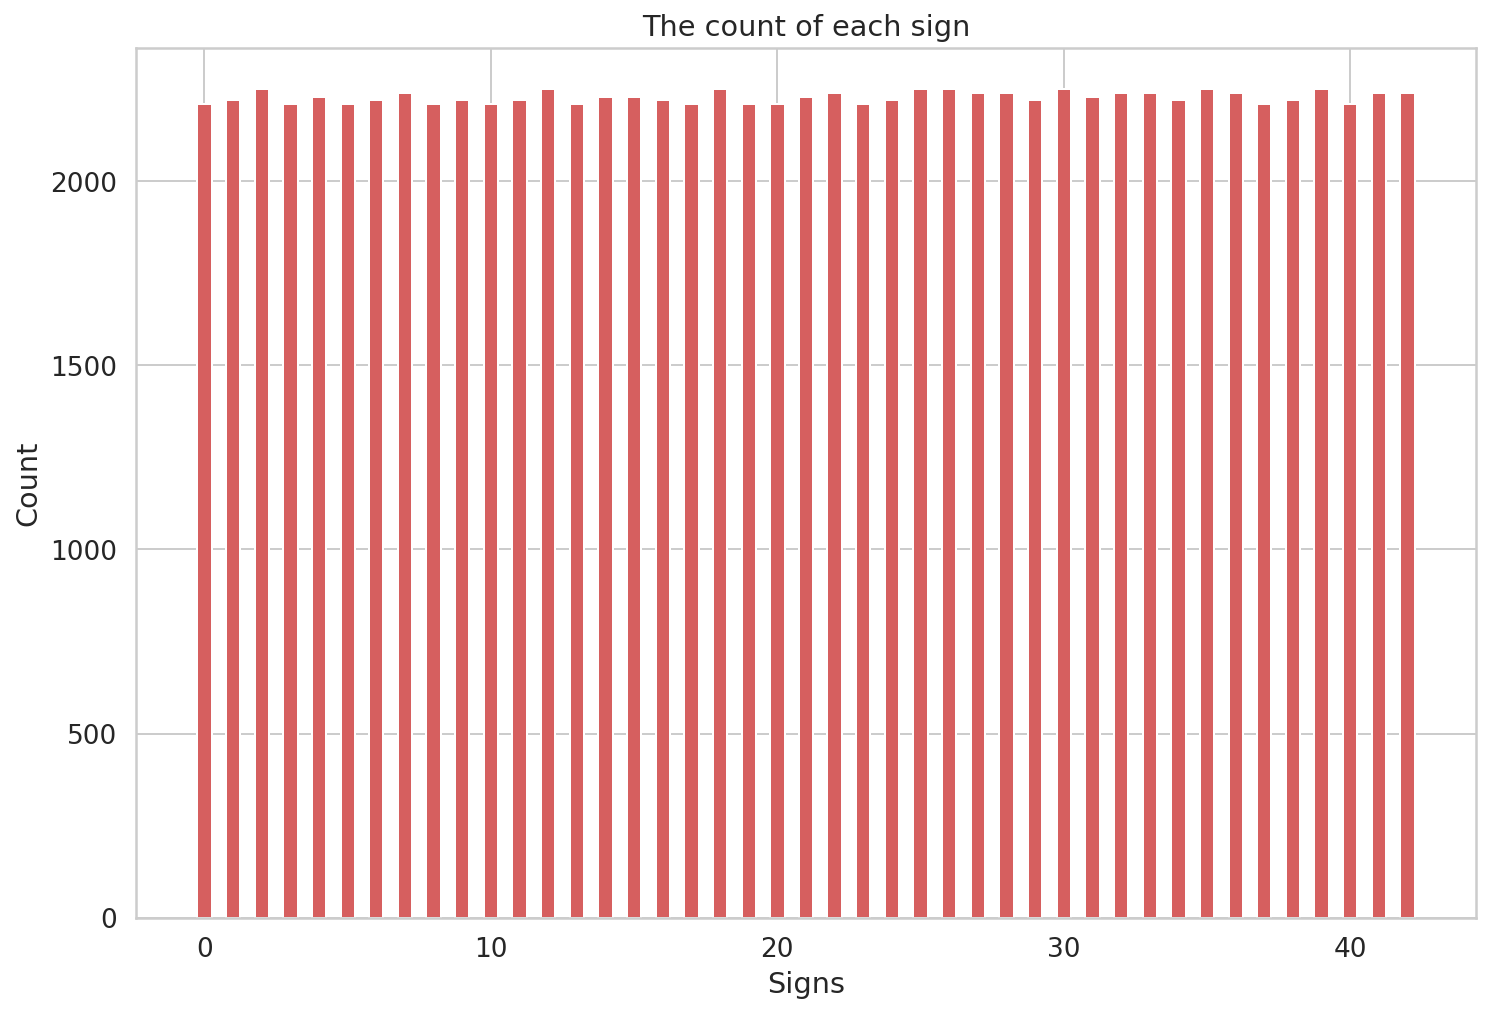

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(labels)), labels, 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

# Load Augmented Imag

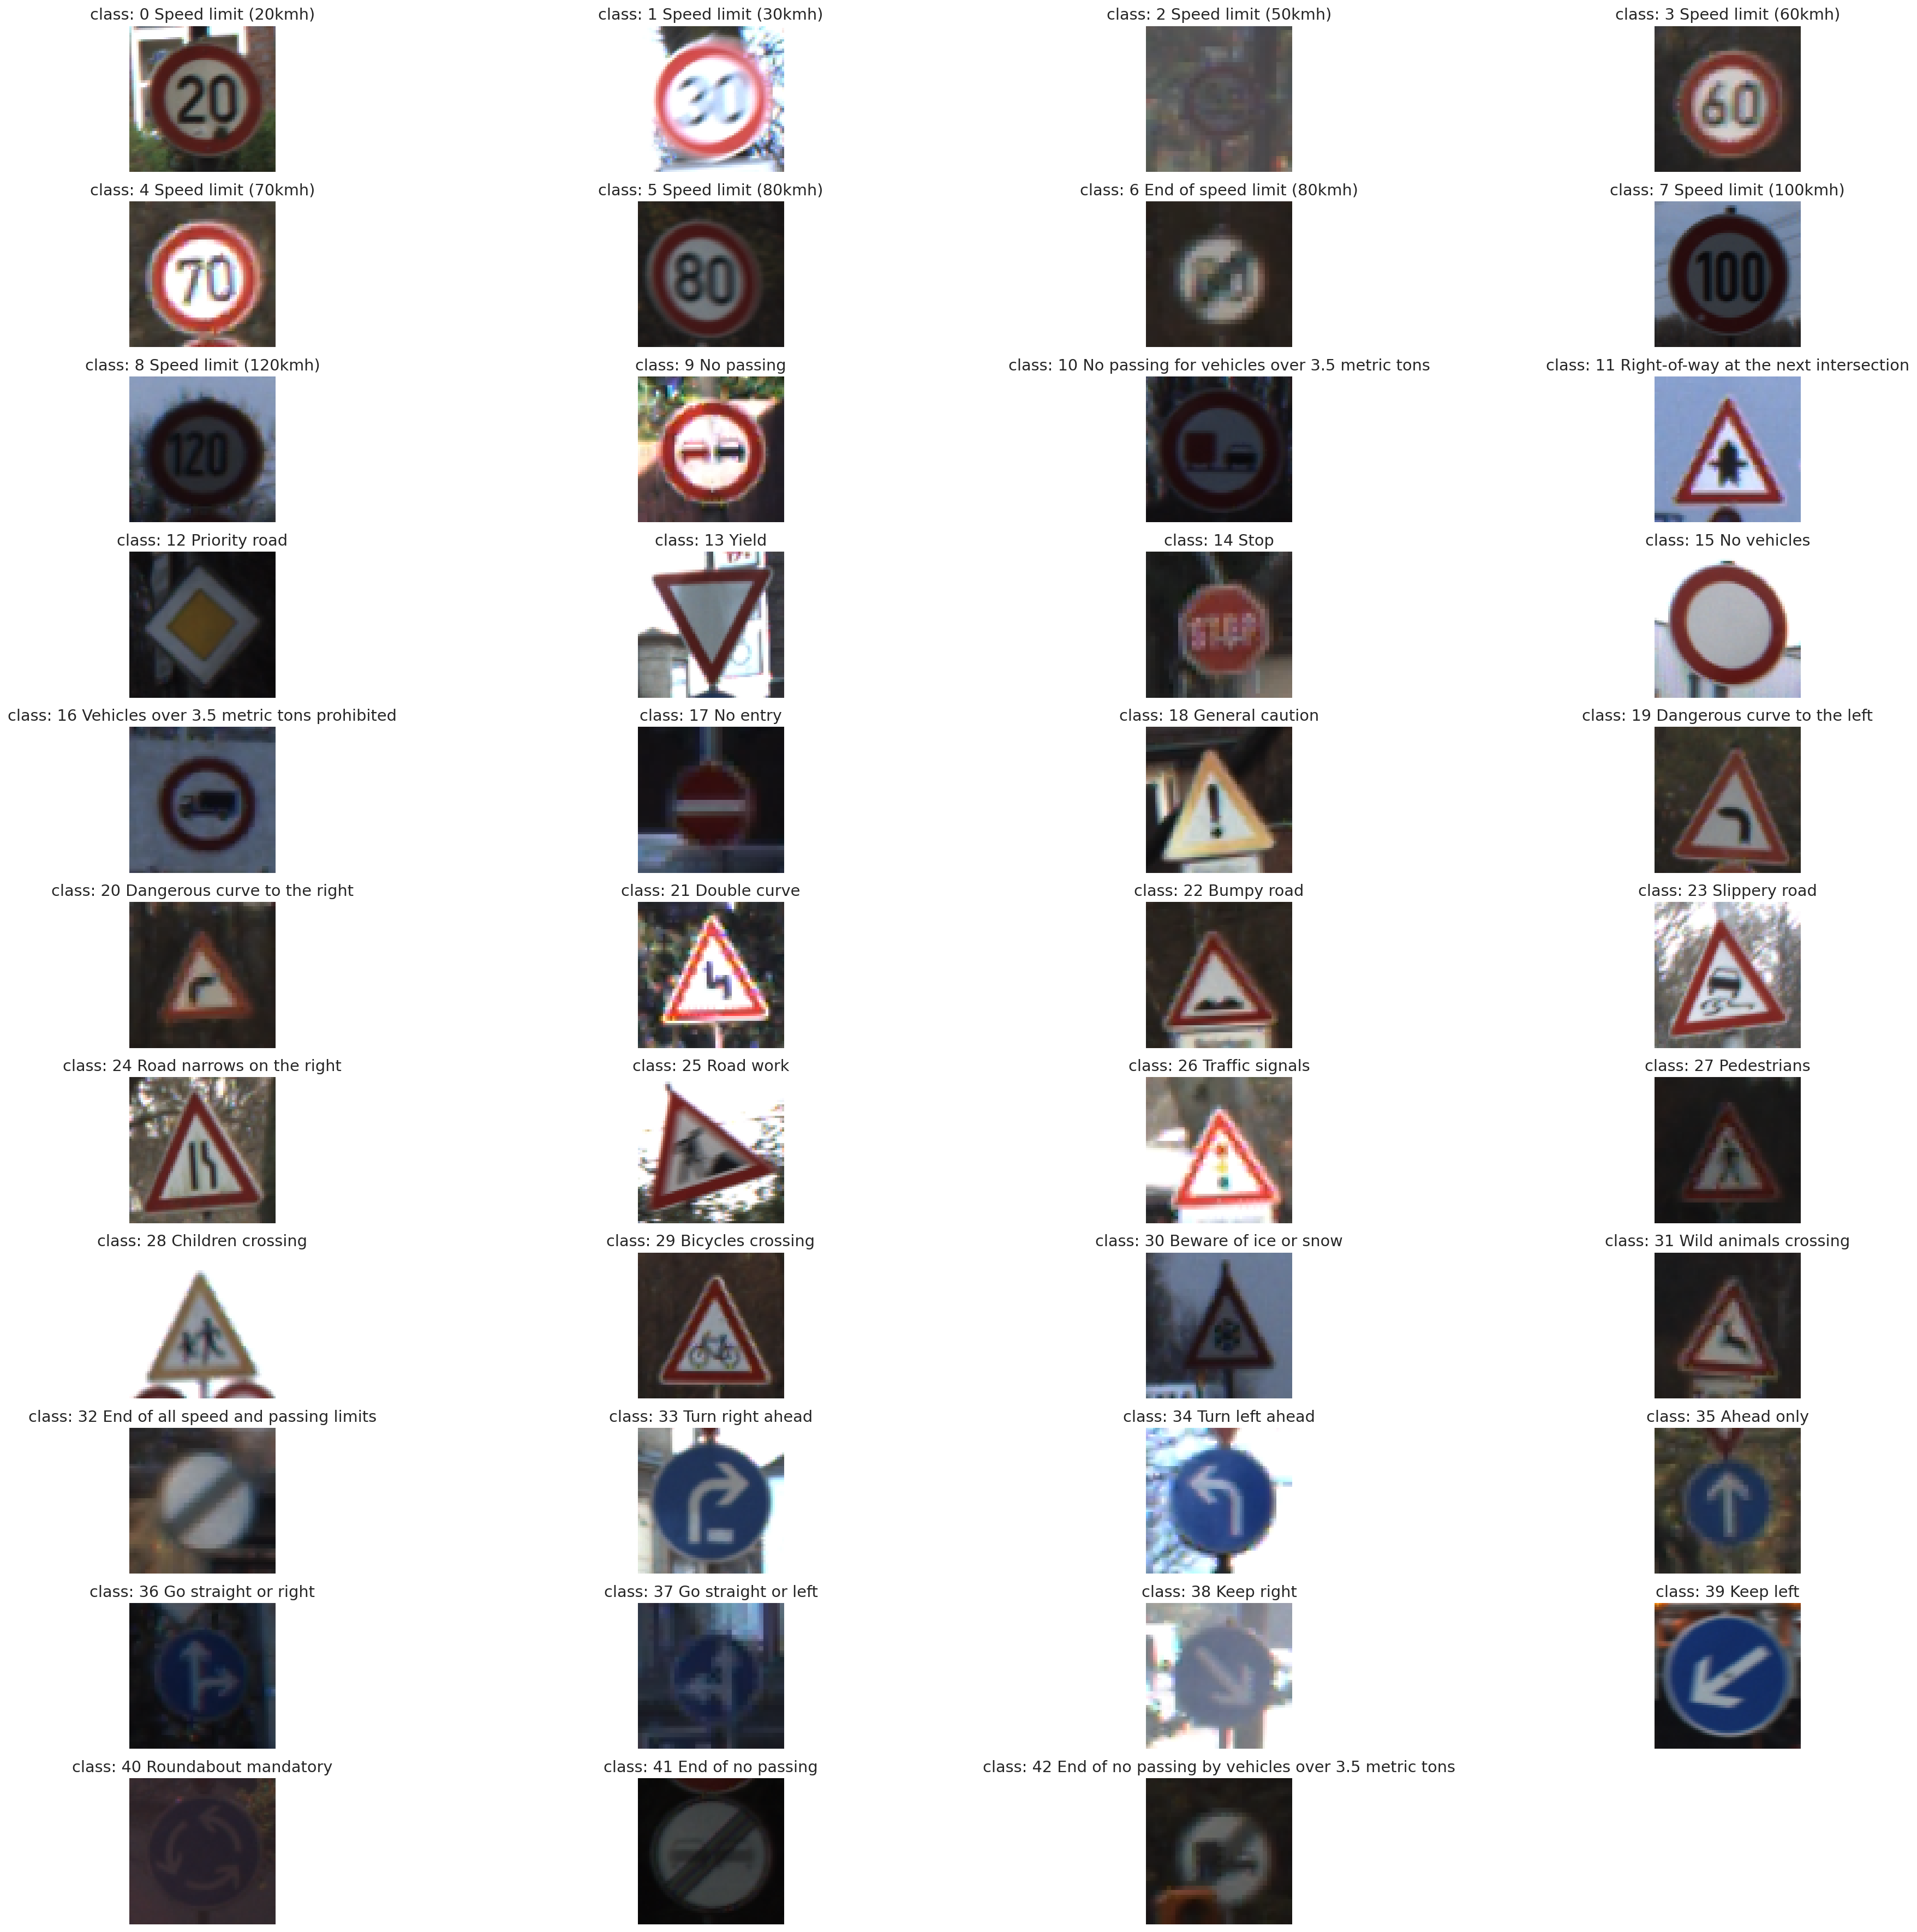

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

plt.figure(figsize=(32, 32))

def show_sign_grid():
  for i in range(len(data_folders)):
    image_paths = np.random.choice((glob(f'{data_folders[i]}/*ppm')))
    images = load_image(image_paths)
    images = torch.as_tensor(images)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.subplot(len(data_folders)/4 + 1, 4, i+1)
    plt.axis('off')
    plt.title('class: {} {}'.format(sign_names["ClassId"][i],sign_names["SignName"][i]))
    plt.imshow(grid_img)
show_sign_grid();

In [ ]:
print("Class labels: \n{}\n".format(classLabels))
print("Class index: \n{}".format(classIndex))

Class labels: 
['Speed limit (20kmh)', 'Speed limit (30kmh)', 'Speed limit (50kmh)', 'Speed limit (60kmh)', 'Speed limit (70kmh)', 'Speed limit (80kmh)', 'End of speed limit (80kmh)', 'Speed limit (100kmh)', 'Speed limit (120kmh)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice or snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons'

#Divide Data

## Splite data into: training, validation, testing in ratio 80% : 10% : 10%

In [ ]:
DATA_DIR = Path('data_all')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in classLabels:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
print(data_folders[0])
print(glob(f'{data_folders[0]}/*.ppm'))

GTSRB/Final_Training/Images/00000
['GTSRB/Final_Training/Images/00000/00002_00023.ppm', 'GTSRB/Final_Training/Images/00000/00002_00004.ppm', 'GTSRB/Final_Training/Images/00000/00003_00007.ppm', 'GTSRB/Final_Training/Images/00000/00006_00002.ppm', 'GTSRB/Final_Training/Images/00000/00004_00006.ppm', 'GTSRB/Final_Training/Images/00000/00000_00006.ppm', 'GTSRB/Final_Training/Images/00000/00004_00015.ppm', 'GTSRB/Final_Training/Images/00000/00000_00017.ppm', 'GTSRB/Final_Training/Images/00000/00000_00001.ppm', 'GTSRB/Final_Training/Images/00000/00003_00016.ppm', 'GTSRB/Final_Training/Images/00000/00004_00005.ppm', 'GTSRB/Final_Training/Images/00000/00001_00019.ppm', 'GTSRB/Final_Training/Images/00000/00005_00004.ppm', 'GTSRB/Final_Training/Images/00000/00006_00015.ppm', 'GTSRB/Final_Training/Images/00000/00001_00003.ppm', 'GTSRB/Final_Training/Images/00000/00005_00023.ppm', 'GTSRB/Final_Training/Images/00000/00000_00014.ppm', 'GTSRB/Final_Training/Images/00000/00004_00029.ppm', 'GTSRB/Fina

In [ ]:
for i, cls_index in enumerate(classIndex):
  print(cls_index)
  image_paths = np.array(glob(f'{data_folders[cls_index]}/*.ppm'))
  print(sorted(image_paths))
  print(len(sorted(image_paths)))
  break;

0
['GTSRB/Final_Training/Images/00000/00000_00000.ppm', 'GTSRB/Final_Training/Images/00000/00000_00001.ppm', 'GTSRB/Final_Training/Images/00000/00000_00002.ppm', 'GTSRB/Final_Training/Images/00000/00000_00003.ppm', 'GTSRB/Final_Training/Images/00000/00000_00004.ppm', 'GTSRB/Final_Training/Images/00000/00000_00005.ppm', 'GTSRB/Final_Training/Images/00000/00000_00006.ppm', 'GTSRB/Final_Training/Images/00000/00000_00007.ppm', 'GTSRB/Final_Training/Images/00000/00000_00008.ppm', 'GTSRB/Final_Training/Images/00000/00000_00009.ppm', 'GTSRB/Final_Training/Images/00000/00000_00010.ppm', 'GTSRB/Final_Training/Images/00000/00000_00011.ppm', 'GTSRB/Final_Training/Images/00000/00000_00012.ppm', 'GTSRB/Final_Training/Images/00000/00000_00013.ppm', 'GTSRB/Final_Training/Images/00000/00000_00014.ppm', 'GTSRB/Final_Training/Images/00000/00000_00015.ppm', 'GTSRB/Final_Training/Images/00000/00000_00016.ppm', 'GTSRB/Final_Training/Images/00000/00000_00017.ppm', 'GTSRB/Final_Training/Images/00000/00000_00

In [ ]:
for i, cls_index in enumerate(classIndex):
  image_paths = np.array(glob(f'{data_folders[cls_index]}/*.ppm'))
  class_name = classLabels[i]
  print("Class {} {}: {}".format(i, class_name, len(image_paths)))
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Class 0 Speed limit (20kmh): 2210
Class 1 Speed limit (30kmh): 2220
Class 2 Speed limit (50kmh): 2250
Class 3 Speed limit (60kmh): 2210
Class 4 Speed limit (70kmh): 2230
Class 5 Speed limit (80kmh): 2210
Class 6 End of speed limit (80kmh): 2220
Class 7 Speed limit (100kmh): 2240
Class 8 Speed limit (120kmh): 2210
Class 9 No passing: 2220
Class 10 No passing for vehicles over 3.5 metric tons: 2210
Class 11 Right-of-way at the next intersection: 2220
Class 12 Priority road: 2250
Class 13 Yield: 2210
Class 14 Stop: 2230
Class 15 No vehicles: 2230
Class 16 Vehicles over 3.5 metric tons prohibited: 2220
Class 17 No entry: 2210
Class 18 General caution: 2250
Class 19 Dangerous curve to the left: 2210
Class 20 Dangerous curve to the right: 2210
Class 21 Double curve: 2230
Class 22 Bumpy road: 2240
Class 23 Slippery road: 2210
Class 24 Road narrows on the right: 2220
Class 25 Road work: 2250
Class 26 Traffic signals: 2250
Class 27 Pedestrians: 2240
Class 28 Children crossing: 2240
Class 29 Bic

In [ ]:
master_path = '/content/data_all/'
train_path = master_path + 'train/*'
val_path = master_path + 'val/*'
test_path = master_path + 'test/*'

trainSample = sorted(glob(train_path))
valSample = sorted(glob(val_path))
testSample = sorted(glob(test_path))
len(trainSample)

43

In [ ]:
train_total = 0;
train_labels = []
for i in range(len(trainSample)):
  train = len(sorted(glob(trainSample[i] + '/*')))
  train_total += train
  train_labels.append(train)
print("Train Set Size: ", train_total)
# print(train_labels)

val_total = 0;
val_labels = []
for i in range(len(valSample)):
  val = len(sorted(glob(valSample[i] + '/*')))
  val_total += val
  val_labels.append(val)
print("Val Set Size: ", val_total)
# print(val_labels)

test_total = 0;
test_labels = []
for i in range(len(valSample)):
  test = len(sorted(glob(valSample[i] + '/*')))
  test_total += test
  test_labels.append(val)
print("Val Set Size: ", test_total)
# print(test_labels)

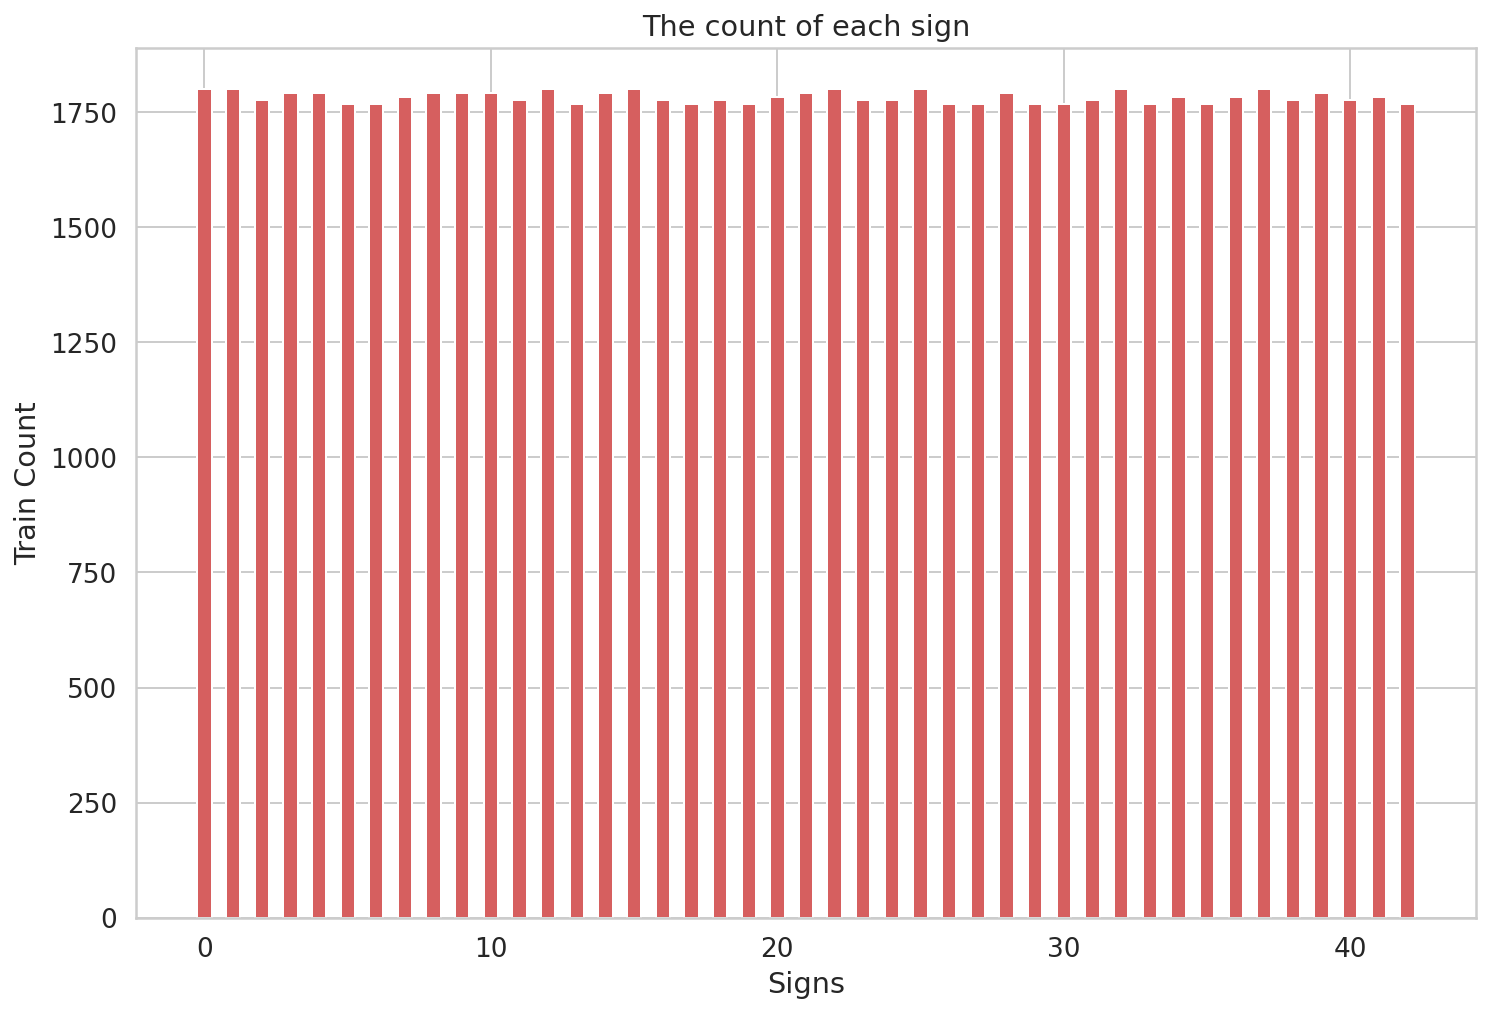

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(labels)), train_labels, 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Train Count')
ax.set_title('The count of each sign')
plt.show()

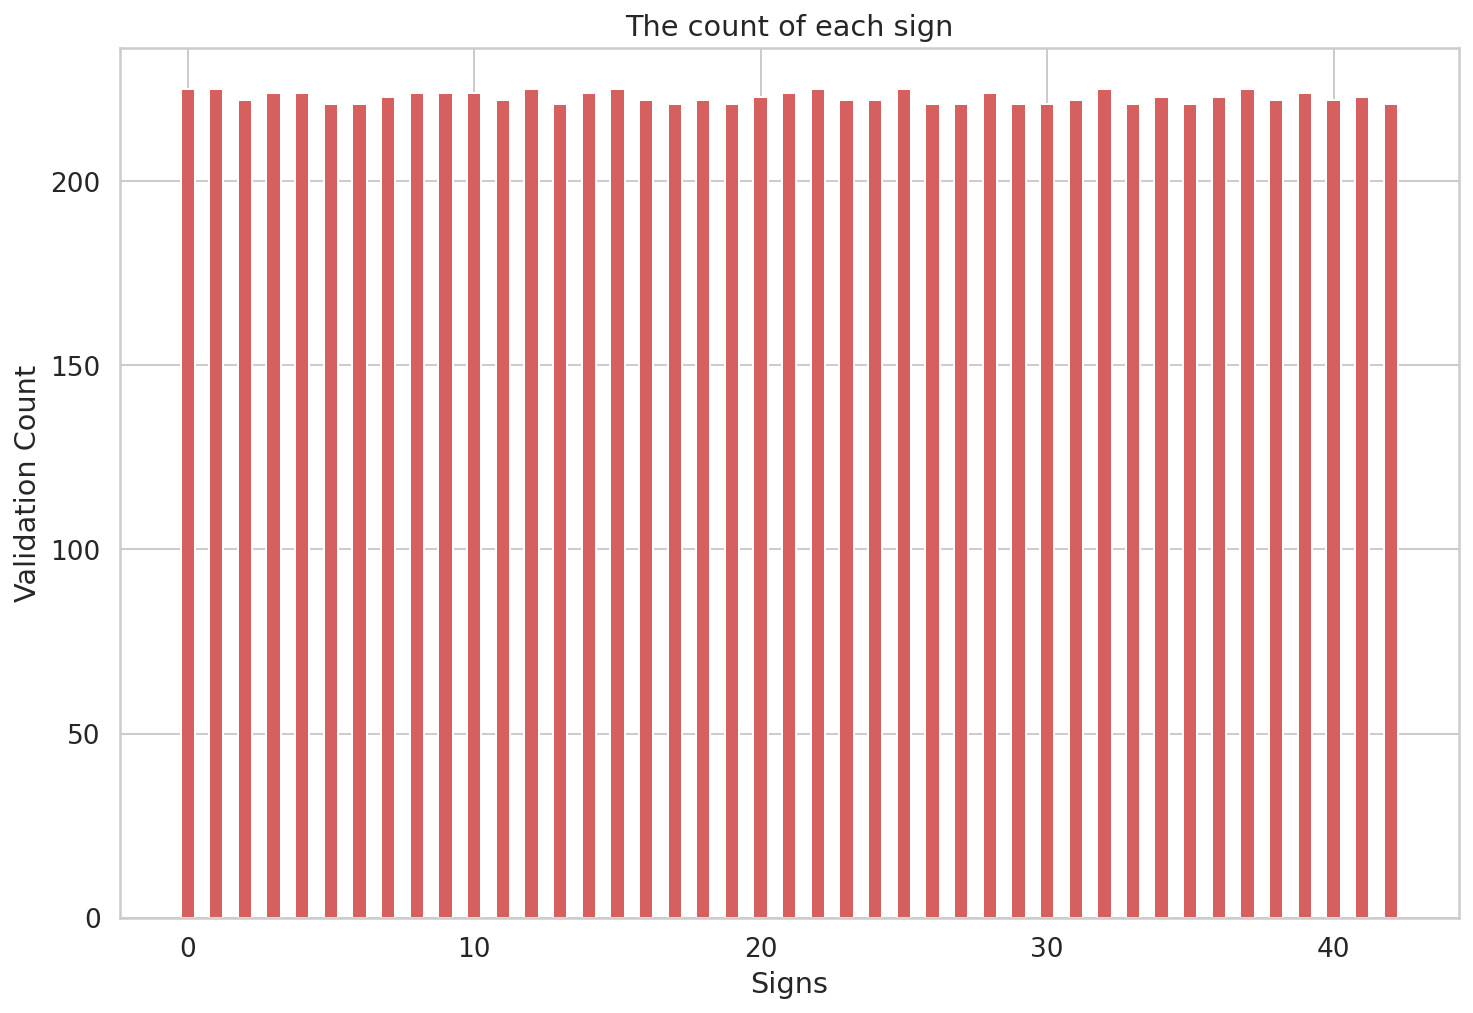

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(labels)), val_labels, 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Validation Count')
ax.set_title('The count of each sign')
plt.show()

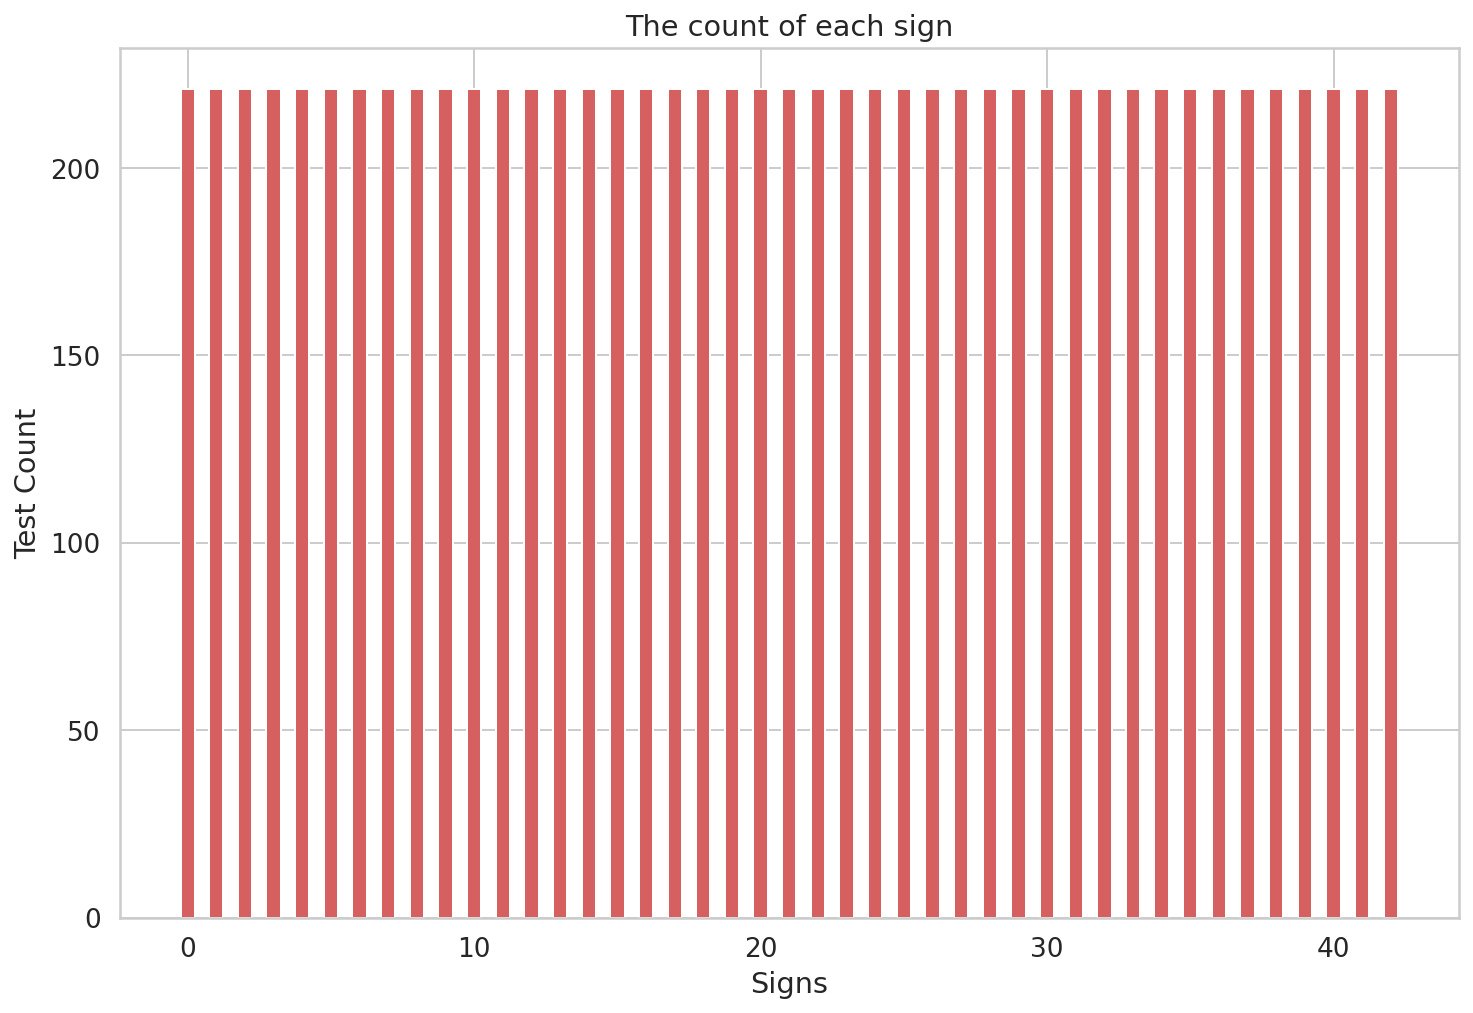

In [ ]:
fig, ax = plt.subplots()
ax.bar(range(len(labels)), test_labels, 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Test Count')
ax.set_title('The count of each sign')
plt.show()

In [ ]:
labels = []
total_images = 0
for class_folder in data_folders:
  
  #Get all images in one folder
  images = sorted(glob(class_folder + '/*.ppm'))
  #Get current count of images
  images_count = len(images);
  total_images += images_count
  labels.append(images_count)
  image_index = 0
  print(images_count)

print("Total image number: {0}".format(total_images))


2210
2220
2250
2210
2230
2210
2220
2240
2210
2220
2210
2220
2250
2210
2230
2230
2220
2210
2250
2210
2210
2230
2240
2210
2220
2250
2250
2240
2240
2220
2250
2230
2240
2239
2220
2250
2240
2210
2220
2250
2210
2240
2240
Total image number: 95809


#Load data using dataloader

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

def get_data_loader_with_augmentation(batch_size, num_workers=1):
  print("Apply augmentation")

  # transform = transforms.Compose([transforms.Resize((50,50)), transforms.ToTensor()])
  transforms_list = {'train': transforms.Compose([
                                        transforms.Resize((50,50)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean_nums, std_nums)
                                        ]), 
                     'val': transforms.Compose([
                                        transforms.Resize((50,50)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean_nums, std_nums)
                        ]), 
                     'test': transforms.Compose([
                                        transforms.Resize((50,50)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean_nums, std_nums)
                        ])
                    }

  master_path = '/content/data_all/'
  train_path = os.path.join(master_path, 'train')
  val_path = os.path.join(master_path, 'val')
  test_path = os.path.join(master_path, 'test')

  print("Train path: {}". format(train_path))
  print("Train path: {}". format(val_path))
  print("Train path: {}". format(test_path))

  train_set = torchvision.datasets.ImageFolder(train_path, transform=transforms_list['train'])
  val_set = torchvision.datasets.ImageFolder(val_path, transform=transforms_list['val'])
  test_set = torchvision.datasets.ImageFolder(test_path, transform=transforms_list['test'])

  print("The length of train set: {}".format(len(train_set)))
  print("The length of validation set: {}".format(len(val_set)))
  print("The length of test set: {}".format(len(test_set)))
  print("Batch Size is: {}".format(batch_size))

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)

  dataset_size = {'train': len(train_set), 'val': len(val_set), 'test': len(test_set)}
  data_loaders = {'train': train_loader,'val': val_loader,'test': test_loader}
  return dataset_size, data_loaders

In [ ]:
def get_data_loader_without_augmentation(batch_size, num_workers=1):
  print("No augmentation")
  transform = transforms.Compose([transforms.Resize((50,50)), transforms.ToTensor()])

  master_path = '/content/data_all/'
  train_path = os.path.join(master_path, 'train')
  val_path = os.path.join(master_path, 'val')
  test_path = os.path.join(master_path, 'test')

  print("Train path: {}". format(train_path))
  print("Train path: {}". format(val_path))
  print("Train path: {}". format(test_path))

  train_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
  val_set = torchvision.datasets.ImageFolder(val_path, transform=transform)
  test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)

  print("The length of train set: {}".format(len(train_set)))
  print("The length of validation set: {}".format(len(val_set)))
  print("The length of test set: {}".format(len(test_set)))
  print("Batch Size is: {}".format(batch_size))

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
  
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  
  dataset_size = {'train': len(train_set), 'val': len(val_set), 'test': len(test_set)}
  data_loaders = {'train': train_loader,'val': val_loader,'test': test_loader}
  return dataset_size, data_loaders

In [ ]:
dataset_size, data_loaders = get_data_loader_without_augmentation(batch_size=27, num_workers=1)

In [ ]:
dataset_size, data_loaders = get_data_loader_with_augmentation(batch_size=27, num_workers=1)

# Plot Image from loader

In [ ]:
classes = sorted(classLabels)
def show_img_with_Augmentation(data_loader):
    # Verification Step - obtain one batch of images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    print(labels)
    print(images.shape)
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    
    fig = plt.figure(figsize=(16, 16))
    for idx in np.arange(20):
        ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
        inp = np.transpose(images[idx], (1, 2, 0))
        mean = np.array([mean_nums])
        std = np.array([std_nums])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        ax.set_title(classes[labels[idx]])

In [ ]:
def show_img_without_Augmentation(data_loader):
    # Verification Step - obtain one batch of images
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    print(labels)
    print(images.shape)
    images = images.numpy() # convert images to numpy for display

    classes = sorted(classLabels)
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(24, 24))
    for idx in np.arange(20):
        ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

tensor([32, 36, 27, 24, 11, 35,  5, 41, 18, 41, 41, 40, 33, 14,  5, 31, 18, 13,
        24, 16, 15, 10, 34,  3, 34,  0, 17])
torch.Size([27, 3, 50, 50])


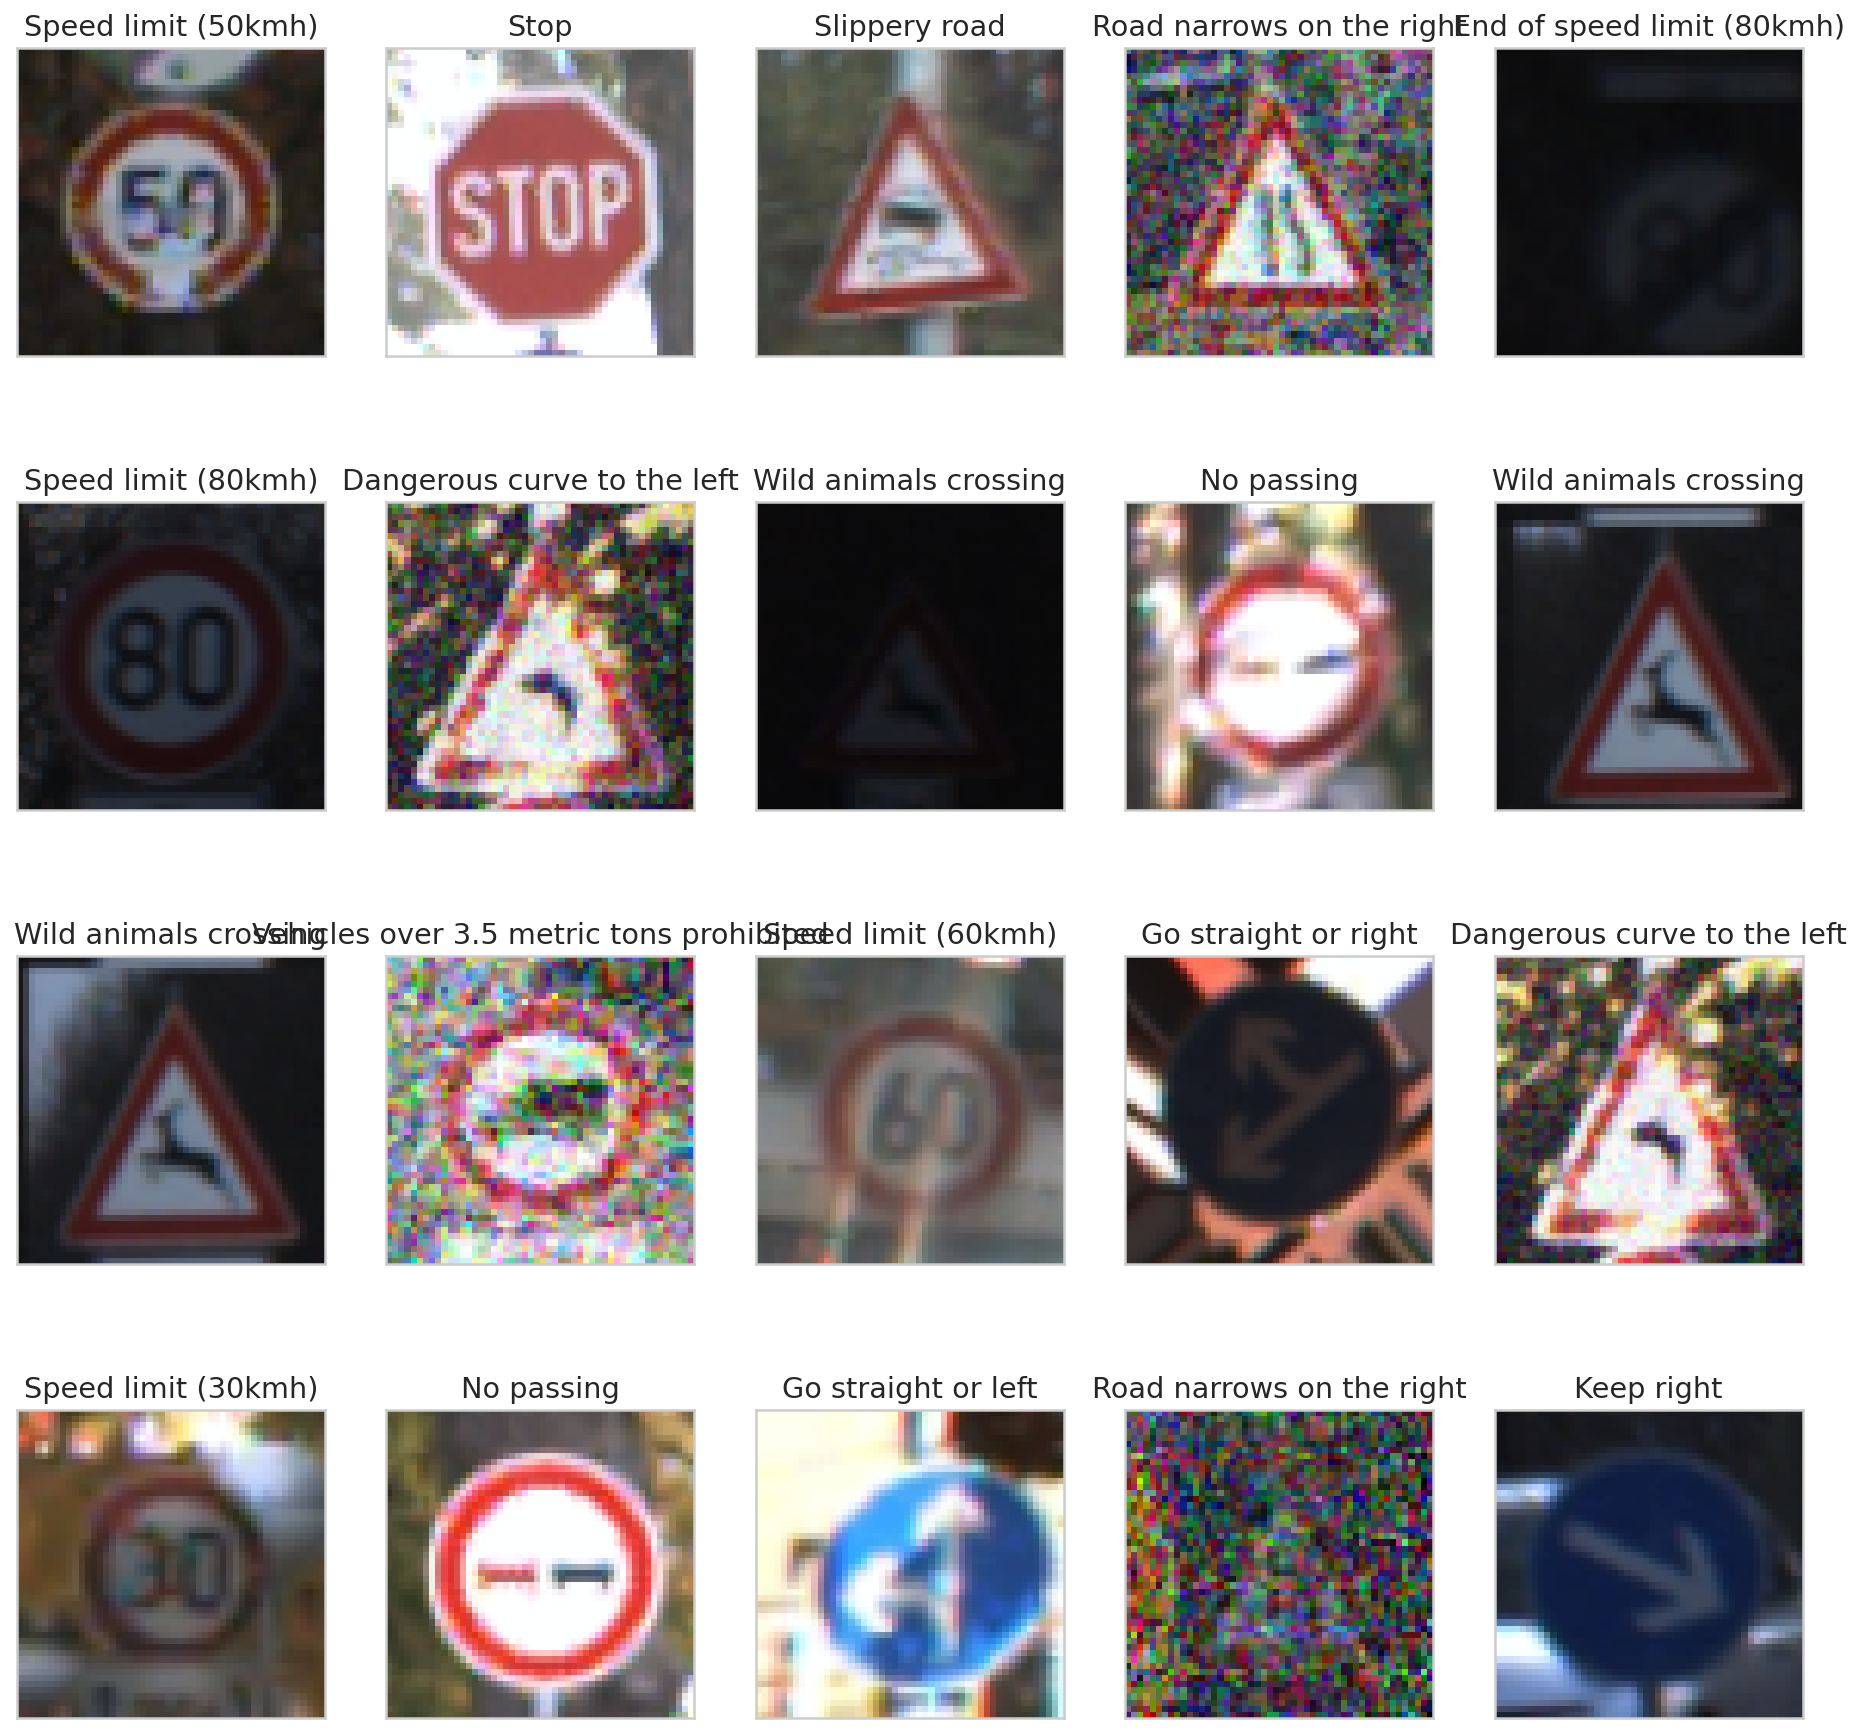

In [ ]:
show_img_with_Augmentation(data_loaders['train'])

In [ ]:
### 2. Model Building and Sanity Checking

### Part (a) Convolutional Network - LetNet

#Base Line Model Implementation

In [ ]:
# start point based on Lab 2 model

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)

        self.fc1 = nn.Linear(10 * 9 * 9, 200)
        self.fc2 = nn.Linear(200, 20)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [ ]:
class_names = sorted(classLabels)
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
def plot_curve(losses, iters, epoches, train_acc, val_acc, test_data=False):
  plt.title("Training Loss Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  if test_data == False:
    plt.title("Training VS Validation Accuracy")
    plt.plot(epoches, val_acc, label="Validation")
  else:
    plt.title("Training VS Test Accuracy")
    plt.plot(epoches, val_acc, label="Test")

  plt.plot(epoches, train_acc, label="Train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  return

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def transfer_train(model, train_features, val_features, batch_size=27, num_epochs=1, learn_rate = 0.001, test_Model=False):
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    use_cuda = True;

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    
    losses, iters, epoches, train_acc, val_acc = [], [], [], [], []

    # training
    print ("Batch Size: {}, Num_epochs: {}, Learn_rate: {}".format(batch_size,num_epochs,learn_rate))
    print ("Training Started...")
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        # print ("epoch: {}".format(epoch))
        for imgs, labels in iter(train_features):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

            # save the current training information
            losses.append(loss)
            iters.append(n)
            # print(n)

        
        # track accuracy
        train_acc.append(get_accuracy(model, train_features))
        val_acc.append(get_accuracy(model, val_features))
        epoches.append(epoch)

        if test_Model == False:
          print(("Epoch {}: Training Accuracy {} | "+
               "Validation Accuracy {}").format(
                   epoch + 1, 
                   train_acc[epoch], 
                   val_acc[epoch]))
        else:
          print(("Epoch {}: Training Accuracy {} | "+
               "Test Accuracy {}").format(
                   epoch + 1, 
                   train_acc[epoch], 
                   val_acc[epoch]))

    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    return losses, iters, epoches, train_acc, val_acc

In [ ]:
use_cuda = True
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# model = base_model
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# dataset_sizes, data_loaders = get_data_loader_with_augmentation(batch_size=27, num_workers=1)
dataset_sizes, data_loaders = get_data_loader_without_augmentation(batch_size=27, num_workers=1)

losses, iters, epoches, train_acc, val_acc = transfer_train(model, data_loaders['train'], data_loaders['val'], 
                                                   batch_size=27, 
                                                   num_epochs=10, 
                                                   learn_rate = 0.001,
                                                   test_Model=False)
plot_curve(losses, iters, epoches, train_acc, val_acc, test_data=False)

##Validation Acc = 0.752183

## Test Code

In [ ]:
losses, iters, epoches, train_acc, val_acc = transfer_train(model, data_loaders['train'], data_loaders['test'], 
                                                   batch_size=27, 
                                                   num_epochs=10, 
                                                   learn_rate = 0.001,
                                                   test_Model=True)

plot_curve(losses, iters, epoches, train_acc, val_acc, test_data=True)

##Acc = 0.8219174

**Applied Pre trained model**

In [ ]:
use_cuda = True
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

model = base_model
# model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

dataset_sizes, data_loaders = get_data_loader_without_augmentation(batch_size=27, num_workers=1)

losses, iters, epoches, train_acc, val_acc = transfer_train(model, data_loaders['train'], data_loaders['test'], 
                                                   batch_size=27, 
                                                   num_epochs=10, 
                                                   learn_rate = 0.001,
                                                   test_Model=True)
plot_curve(losses, iters, epoches, train_acc, val_acc, test_data=True)

**Applied Augmentation Transformer**

In [ ]:
use_cuda = True
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# model = base_model
model = CNNClassifier()
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

dataset_sizes, data_loaders = get_data_loader_with_augmentation(batch_size=64, num_workers=1)

losses, iters, epoches, train_acc, val_acc = transfer_train(model, data_loaders['train'], data_loaders['val'], 
                                                   batch_size=64, 
                                                   num_epochs=30, 
                                                   learn_rate = 0.001,
                                                   test_Model=False)

In [ ]:
plot_curve(losses, iters, epoches, train_acc, val_acc, test_data=False)

#Primary Model

In [ ]:
DATA_DIR = Path('data_all')
(DATA_DIR / 'features').mkdir(parents=True, exist_ok=True)

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in classLabels:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(classIndex):
  image_paths = np.array(glob(f'{data_folders[cls_index]}/*.ppm'))
  class_name = classLabels[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)
  # size = [80, 10, 10]
  # k = 0
  for ds, images in dataset_data:
    # j = 0
    # k += 1
    for img_path in images:
      # print(j, "11111  ", img_path, "to ", f'{DATA_DIR}/{ds}/{class_name}/' )
      # print("11111", img_path)
      # j += 1
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')
      # if (j > size[k-1]):
      #     break
    print(ds , ":   ",class_name, len(f'{DATA_DIR}/{ds}/{class_name}'))

Speed limit (20kmh): 2235
train :    Speed limit (20kmh) 34
val :    Speed limit (20kmh) 32
test :    Speed limit (20kmh) 33
Speed limit (30kmh): 2220
train :    Speed limit (30kmh) 34
val :    Speed limit (30kmh) 32
test :    Speed limit (30kmh) 33
Speed limit (50kmh): 2250
train :    Speed limit (50kmh) 34
val :    Speed limit (50kmh) 32
test :    Speed limit (50kmh) 33
Speed limit (60kmh): 2220
train :    Speed limit (60kmh) 34
val :    Speed limit (60kmh) 32
test :    Speed limit (60kmh) 33
Speed limit (70kmh): 2205
train :    Speed limit (70kmh) 34
val :    Speed limit (70kmh) 32
test :    Speed limit (70kmh) 33
Speed limit (80kmh): 2220
train :    Speed limit (80kmh) 34
val :    Speed limit (80kmh) 32
test :    Speed limit (80kmh) 33
End of speed limit (80kmh): 2220
train :    End of speed limit (80kmh) 41
val :    End of speed limit (80kmh) 39
test :    End of speed limit (80kmh) 40
Speed limit (100kmh): 2205
train :    Speed limit (100kmh) 35
val :    Speed limit (100kmh) 33
te

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

tensor([25, 18,  3, 28, 11, 14, 13, 22, 38,  0, 32, 12,  4,  7, 28, 27, 32, 33,
        11,  5, 31,  7, 11, 15, 39,  5, 12, 24, 21, 36])


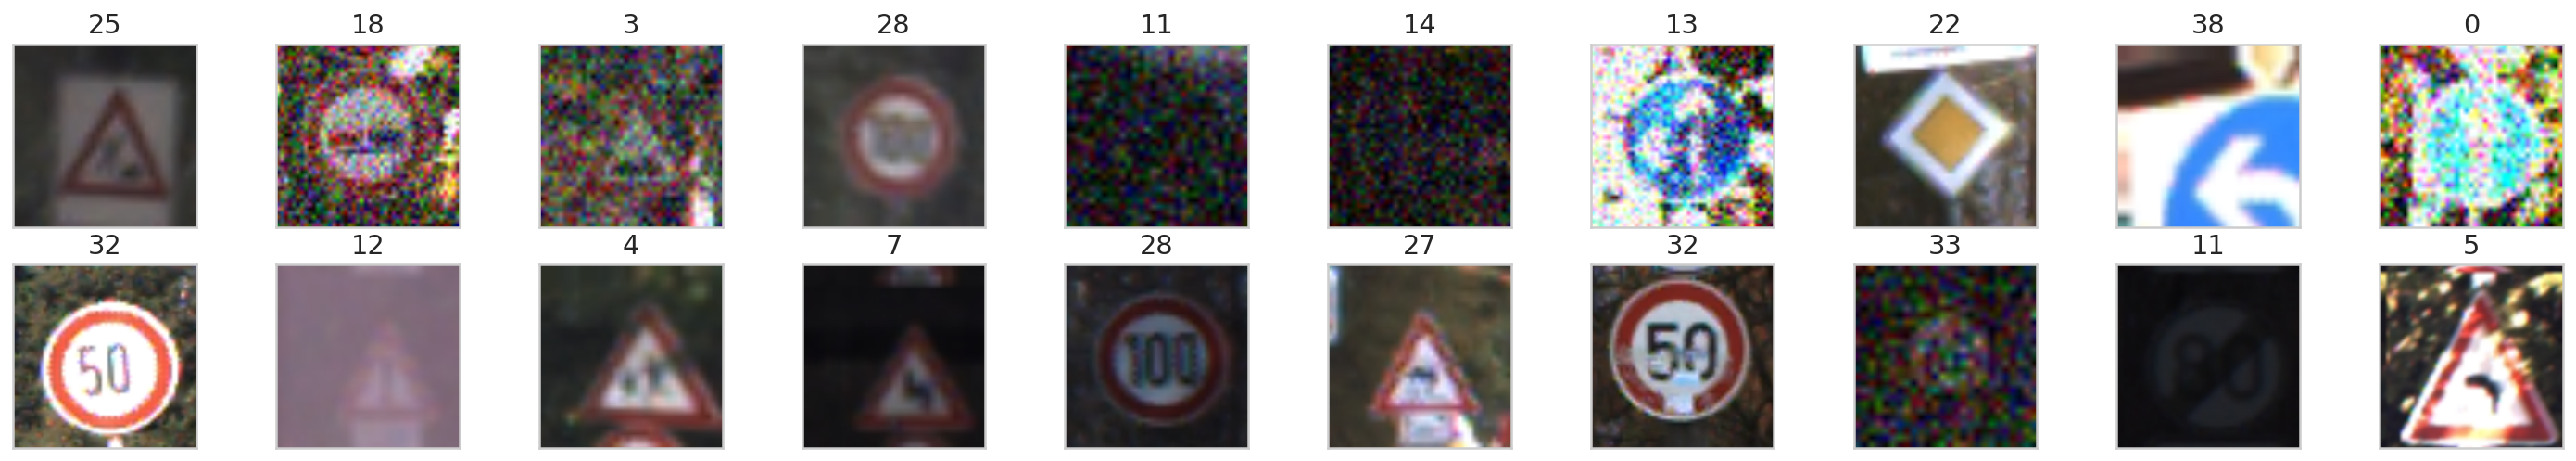

In [ ]:
################################ can be removed ##########################
batch_size = 30

alexnet = torchvision.models.alexnet(pretrained=True)

master_path = '/content/data/'

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])


train_dataset = torchvision.datasets.ImageFolder(master_path + 'train', 
                                                       transform=transform)
    
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               num_workers=1, 
                                               shuffle=True)




# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)
images = images.numpy() # convert images to numpy for display
labels = labels.numpy()
# classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(labels[idx])

# i = 0
# for img, labels in train_loader:
#     print(i)
#     i += 1
#     print(labels)
#     break

###Compute Training Feature

In [ ]:
# train feature 
batch_size = 30

alexnet = torchvision.models.alexnet(pretrained=True)

master_path = '/content/data_all/'

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])


train_dataset = torchvision.datasets.ImageFolder(master_path + 'train', 
                                                       transform=transform)
    
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               num_workers=1, 
                                               shuffle=True)
i = 0
j = 0
train_features = []
for img, labels in train_loader:

    if (i < 100): 
        out = alexnet.features(img)
        train_features.append((out,labels))
        i += 1    
    else:       #f'{data_folders[i]}/*ppm'
        print(" j = ", j)
        np.save(f'{master_path}/features/train_features_{j}.npy', train_features)
        train_features.clear()
        j += 1
        i = 0
np.save(f'{master_path}/features/train_features_{j}.npy', train_features)
print(" train feature done !")

 j =  0
 j =  1
 j =  2
 j =  3
 j =  4
 j =  5
 j =  6
 j =  7
 j =  8
 j =  9
 j =  10
 j =  11
 j =  12
 j =  13
 j =  14
 j =  15
 j =  16
 j =  17
 j =  18
 j =  19
 j =  20
 j =  21
 j =  22
 j =  23
 j =  24
 train feature done !


###Compute Validation Feature

In [ ]:
# validation feature 
batch_size = 30

alexnet = torchvision.models.alexnet(pretrained=True)

master_path = '/content/data_all/'

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])


val_dataset = torchvision.datasets.ImageFolder(master_path + 'val', 
                                                       transform=transform)
    
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=batch_size, 
                                               num_workers=1, 
                                               shuffle=True)
i = 0
j = 0
val_features = []
for img, labels in val_loader:

    if (i < 100): 
        out = alexnet.features(img)
        val_features.append((out,labels))
        i += 1    
    else:       #f'{data_folders[i]}/*ppm'
        print(" j = ", j)
        np.save(f'{master_path}/features/val_features_{j}.npy', val_features)
        val_features.clear()
        j += 1
        i = 0
np.save(f'{master_path}/features/val_features_{j}.npy', val_features)
print(" validation feature done !")

 j =  0
 j =  1
 j =  2
 validation feature done !


###Compute Test Feature

In [ ]:
# test feature 
batch_size = 30

alexnet = torchvision.models.alexnet(pretrained=True)

master_path = '/content/data_all/'

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])


test_dataset = torchvision.datasets.ImageFolder(master_path + 'test', 
                                                       transform=transform)
    
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=batch_size, 
                                               num_workers=1, 
                                               shuffle=True)
i = 0
j = 0
test_features = []
for img, labels in test_loader:

    if (i < 100): 
        out = alexnet.features(img)
        test_features.append((out,labels))
        i += 1    
    else:       #f'{data_folders[i]}/*ppm'
        print(" j = ", j)
        np.save(f'{master_path}/features/test_features_{j}.npy', test_features)
        test_features.clear()
        j += 1
        i = 0
np.save(f'{master_path}/features/test_features_{j}.npy', test_features)
print(" test feature done !")

 j =  0
 j =  1
 j =  2
 test feature done !


###Implement Transfer Net Model

In [ ]:
############################### model #######################################
import torch.nn as nn
class TransferNet(nn.Module):
    def __init__(self):
        super(TransferNet, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 1024)
        self.layer2 = nn.Linear(1024, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

###################################### load data ####################################



master_path = '/content/data_all/'


##################################### get feature ########################################
# done above 

##################################### helper functions ##################################

def plot_curve(epoches, train_acc, val_acc, train_loss, val_loss, test_data=False):
  if test_data == False:
    plt.title("Training VS Validation Loss")
    plt.plot(epoches, val_loss, label="Validation")
  else:
    plt.title("Training VS Test Loss")
    plt.plot(epoches, val_loss, label="Test")

  plt.plot(epoches, train_loss, label="Train")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  if test_data == False:
    plt.title("Training VS Validation Accuracy")
    plt.plot(epoches, val_acc, label="Validation")
  else:
    plt.title("Training VS Test Accuracy")
    plt.plot(epoches, val_acc, label="Test")

  plt.plot(epoches, train_acc, label="Train")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()
  return

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

def get_loss(model, data_loader, criterion):
    total_loss = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        total += imgs.shape[0]
        #get loss
        loss = criterion(output, labels)
        total_loss += loss.item()
    return float(total_loss) / total

In [ ]:


##################################### train ######################################

use_cuda = True
learning_rate = 0.001
num_epochs = 30
torch.manual_seed(1000)

train_feature_path = glob(f'{master_path}/features/train_features*.npy')
val_feature_path = glob(f'{master_path}/features/val_features*.npy')
# val_features = np.load(f'{master_path}/features/val_features_0.npy', allow_pickle=True) 

model = TransferNet()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_acc, val_acc = [], []

    # training
print ("Training Started...")
n = 0 # the number of iterations
for epoch in range(num_epochs):
    # i = 0
    print("epoch = ", epoch)
    train_acc_features = 0
    val_acc_features = 0
    for path in train_feature_path:
        # print(path)
        train_features = np.load(f'{path}', allow_pickle=True)
        for imgs, labels in iter(train_features):
            # print(i)
            # i += 1
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward(retain_graph=True)               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1
        
        # track accuracy
        train_acc_features += get_accuracy(model, train_features)
    for val_path in val_feature_path:
        val_features = np.load(f'{val_path}', allow_pickle=True)
        val_acc_features += get_accuracy(model, val_features)
    
        
    train_acc.append(train_acc_features/len(train_feature_path))
    val_acc.append(val_acc_features/len(val_feature_path))
    print(epoch, train_acc[-1], val_acc[-1])

# printtrain_acc, val_acc


In [ ]:
##################################### train ######################################
def primary_train(model, num_epochs, learning_rate, use_cuda=True):
  torch.manual_seed(1000)

  train_feature_path = glob(f'{master_path}/features/train_features*.npy')
  val_feature_path = glob(f'{master_path}/features/val_features*.npy')
  # val_features = np.load(f'{master_path}/features/val_features_0.npy', allow_pickle=True) 

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_acc, val_acc, train_loss, val_loss, epoches = [], [], [], [],[]

      # training
  print ("Training Started...")
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      # i = 0
      print("epoch = ", epoch)
      train_acc_features = 0
      train_loss_features = 0
      val_acc_features = 0
      val_loss_features = 0
      for path in train_feature_path:
          # print(path)
          train_features = np.load(f'{path}', allow_pickle=True)
          for imgs, labels in iter(train_features):
              # print(i)
              # i += 1
              if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

              out = model(imgs)             # forward pass
              loss = criterion(out, labels) # compute the total loss
              loss.backward(retain_graph=True)               # backward pass (compute parameter updates)
              optimizer.step()              # make the updates for each parameter
              optimizer.zero_grad()         # a clean up step for PyTorch
              n += 1
              
          # track accuracy
          train_acc_features += get_accuracy(model, train_features)
          # train_loss_features += loss.item()
          train_loss_features += get_loss(model, train_features, criterion)
      for val_path in val_feature_path:
          val_features = np.load(f'{val_path}', allow_pickle=True)
          
          val_acc_features += get_accuracy(model, val_features)
          val_loss_features += get_loss(model, val_features, criterion)
          
      train_acc.append(train_acc_features/len(train_feature_path))
      train_loss.append(train_loss_features/len(train_feature_path))
      val_acc.append(val_acc_features/len(val_feature_path))
      val_loss.append(val_loss_features/len(val_feature_path))

      epoches.append(epoch)
      print(epoch, train_acc[-1], val_acc[-1])
  return train_acc, val_acc, train_loss, val_loss, epoches;

##Primary Model Tunning

In [ ]:
learning_rate = 0.001
num_epochs = 30
use_cuda = True
model_1 = TransferNet()
train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_1, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8347711155613146 0.8764523014105419
epoch =  1
1 0.9314152825224801 0.9096943207126948
epoch =  2
2 0.9562166529233911 0.926735708982925
epoch =  3
3 0.9697748066124791 0.9288190423162583
epoch =  4
4 0.9773104802293164 0.9329023756495917
epoch =  5
5 0.9812539953665527 0.9355122494432071
epoch =  6
6 0.9845104056229631 0.9327887899034892
epoch =  7
7 0.9874975851101426 0.9402659613956942
epoch =  8
8 0.9891590489653276 0.9379023756495917
epoch =  9
9 0.9904591235716811 0.9376826280623608
epoch =  10
10 0.9915668904857267 0.9431560876020787
epoch =  11
11 0.9914282797345584 0.9431560876020787
epoch =  12
12 0.9928898181960969 0.9434591685226429
epoch =  13
13 0.9933846153846152 0.9466863400148477
epoch =  14
14 0.9941923076923077 0.9442962138084632
epoch =  15
15 0.9930488671614243 0.9452128804751299
epoch =  16
16 0.993576923076923 0.9455764662212325
epoch =  17
17 0.9948589743589745 0.9500764662212324
epoch = 

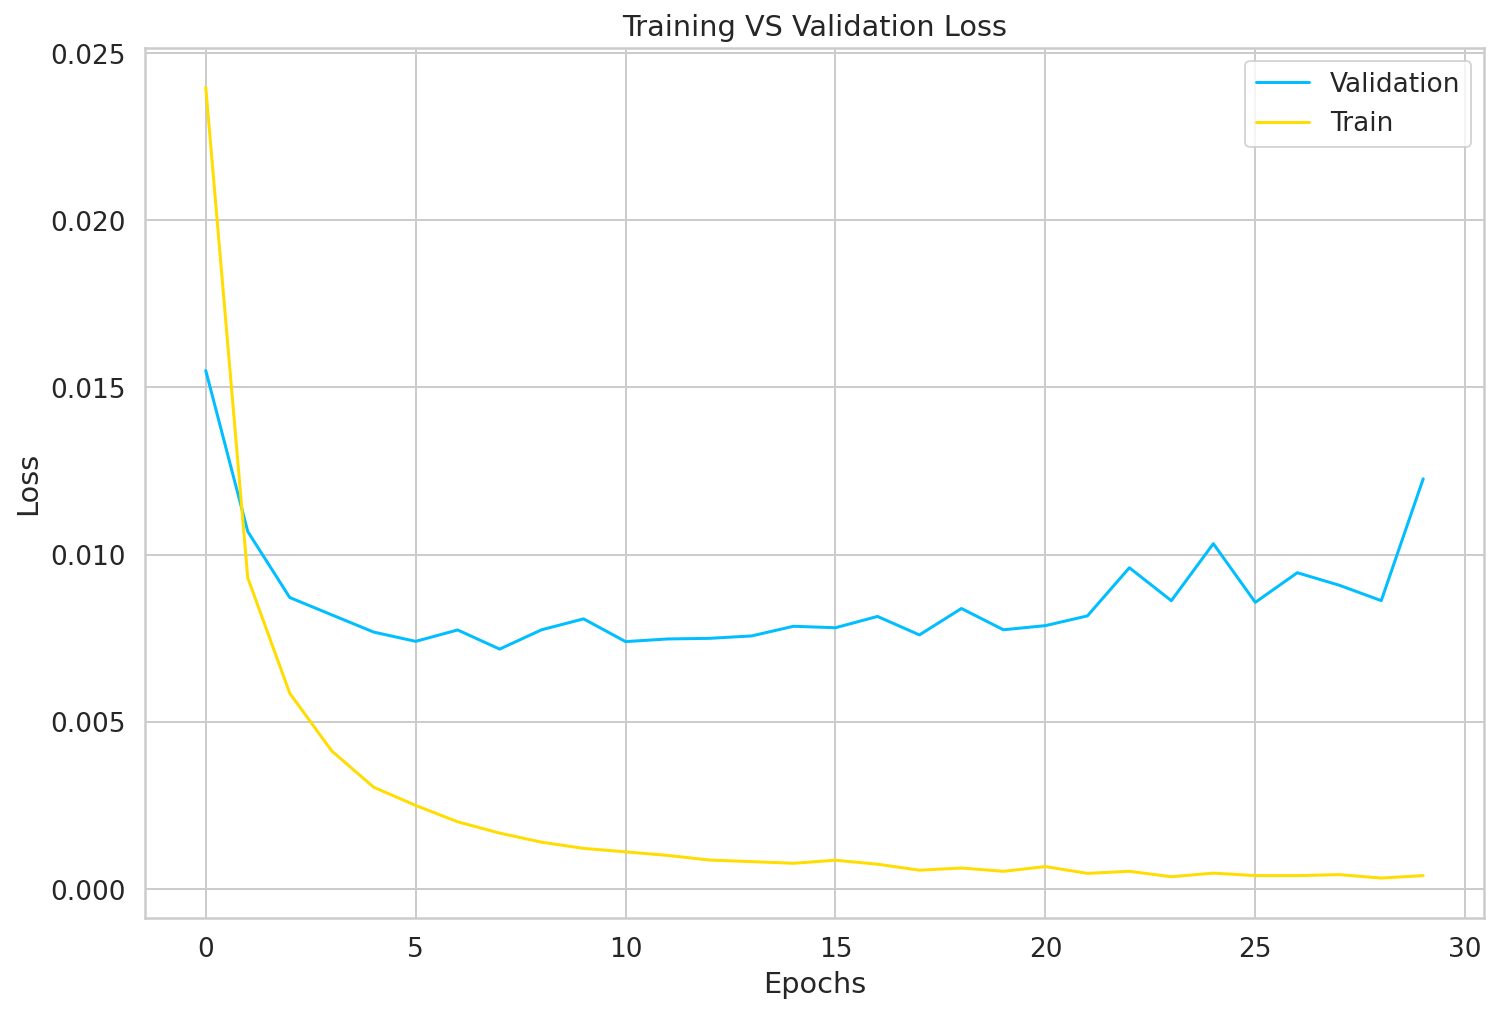

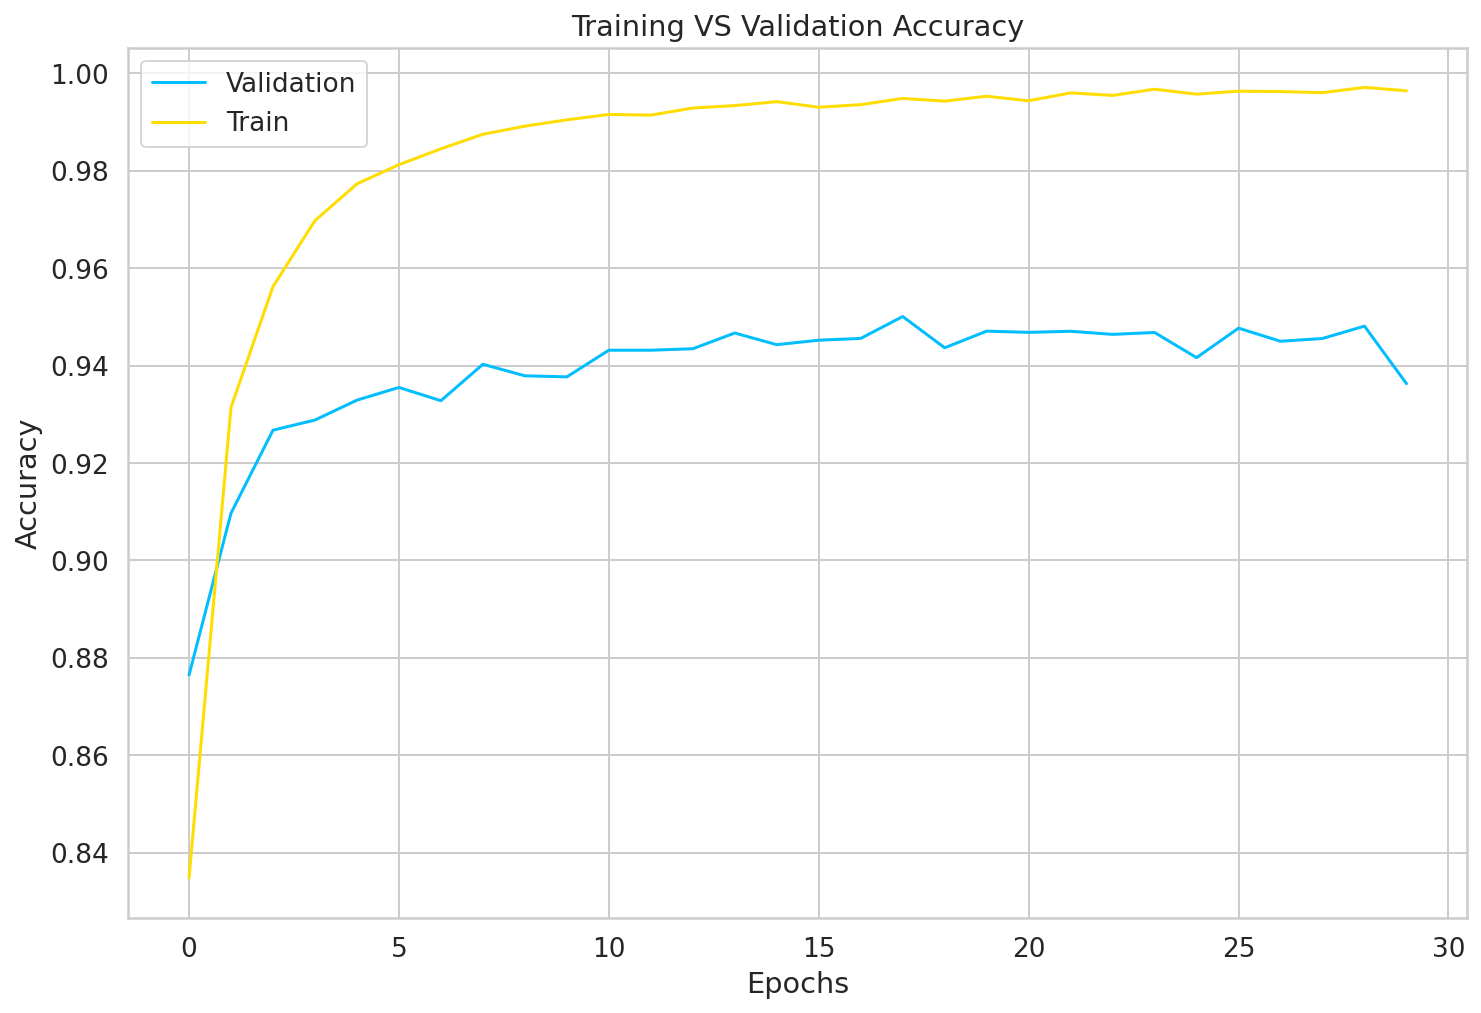

In [ ]:
####################################Setting 1
learning_rate = 0.0001
num_epochs = 30

use_cuda = True
model_1 = TransferNet()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_1, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8711497820709151 0.8933270230141055
epoch =  1
1 0.9487218557348728 0.9215122494432072
epoch =  2
2 0.9654979581419094 0.9256752041573868
epoch =  3
3 0.9747952448266385 0.9328986636971047
epoch =  4
4 0.9771514312639888 0.9315122494432072
epoch =  5
5 0.9801386107511683 0.9325653303637714
epoch =  6
6 0.9822002984254135 0.9330196733481813
epoch =  7
7 0.9852696038009973 0.9342925018559762
epoch =  8
8 0.9869282797345582 0.9398795471417966
epoch =  9
9 0.9871386107511684 0.9380425018559763
epoch =  10
10 0.9880949464012253 0.9422091685226429
epoch =  11
11 0.9906975105037895 0.9459060876020786
epoch =  12
12 0.9912307692307694 0.9483795471417965
epoch =  13
13 0.9901109278674364 0.9390159613956941
epoch =  14
14 0.9918128951191737 0.9456258351893095
epoch =  15
15 0.9925308438371225 0.9415727542687453
epoch =  16
16 0.9923104802293162 0.9506030066815145
epoch =  17
17 0.993018023324302 0.943735708982925
epoch = 

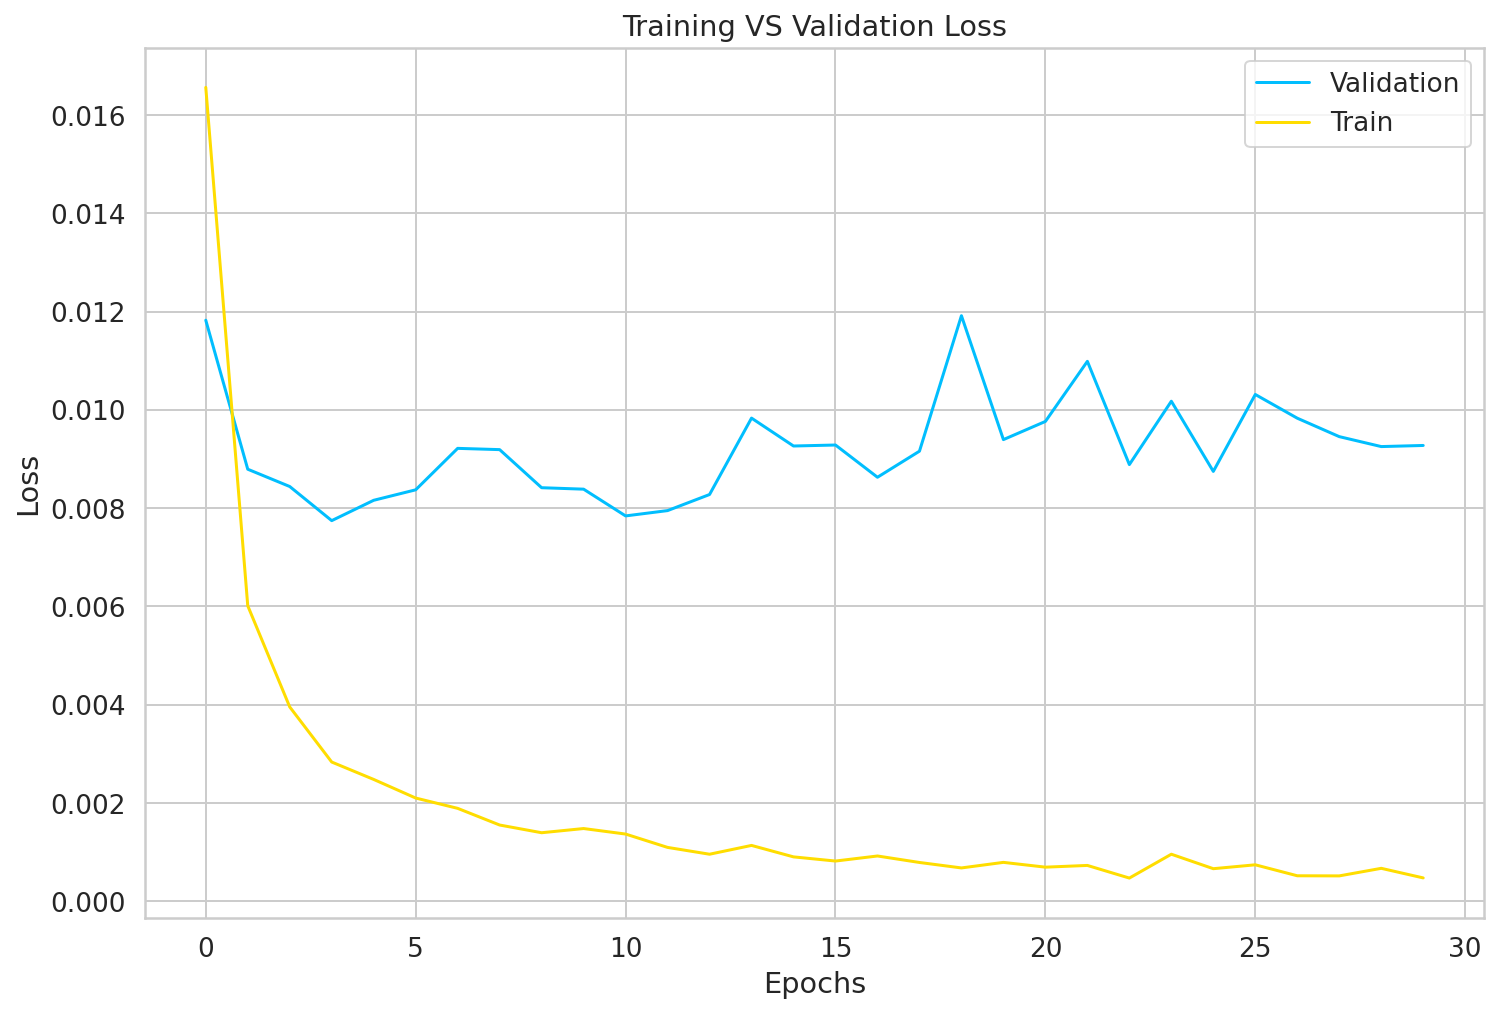

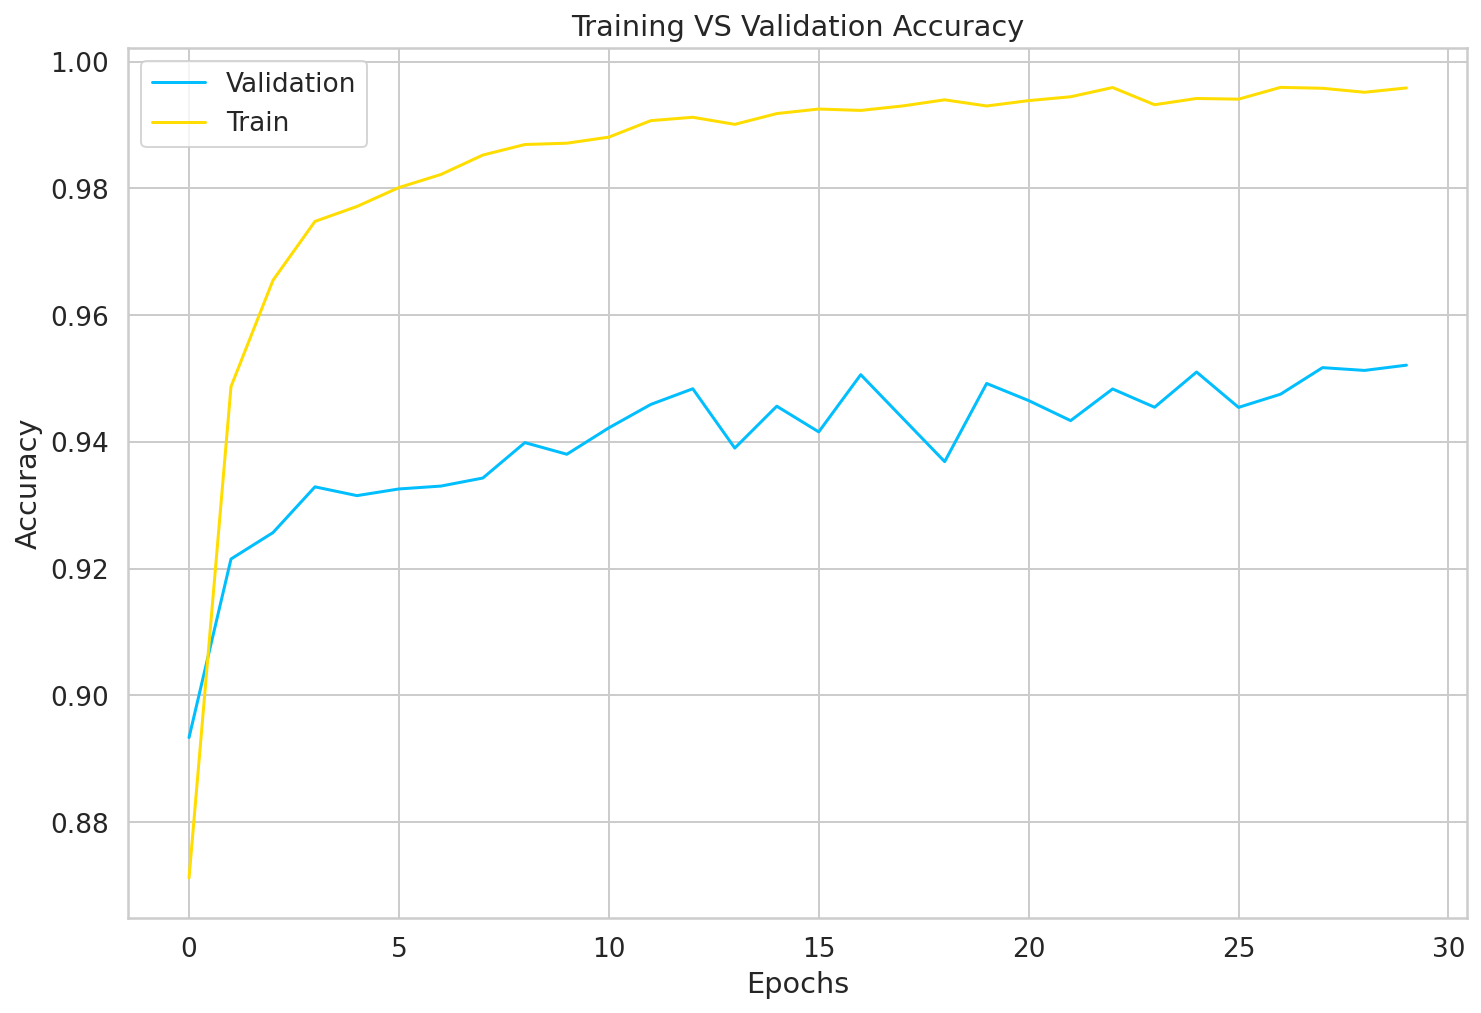

In [ ]:
####################################Setting 2
learning_rate = 0.0003
num_epochs = 30

use_cuda = True
model_1 = TransferNet()

if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_1, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8533012133349038 0.8878498515219004
epoch =  1
1 0.9404738092433345 0.9195425018559762
epoch =  2
2 0.9619314406879493 0.9322925018559763
epoch =  3
3 0.9724054266305414 0.9298684112843356
epoch =  4
4 0.9791618368869517 0.9372091685226429
epoch =  5
5 0.9816077669140456 0.9386826280623608
epoch =  6
6 0.9856874779125925 0.9390196733481813
epoch =  7
7 0.9860052028114813 0.9421863400148478
epoch =  8
8 0.9875821258884045 0.9362696733481812
epoch =  9
9 0.9887872540935329 0.9440764662212324
epoch =  10
10 0.98936696509208 0.9403758351893096
epoch =  11
11 0.9904871794871795 0.9390159613956941
epoch =  12
12 0.9920693053755841 0.9288949517446177
epoch =  13
13 0.9929154592217379 0.9445196733481811
epoch =  14
14 0.9936846899909687 0.9451863400148479
epoch =  15
15 0.9931077669140456 0.9415992947290274
epoch =  16
16 0.9929102564102563 0.9459894209354119
epoch =  17
17 0.99393348254604 0.9446560876020786
epoch =  1

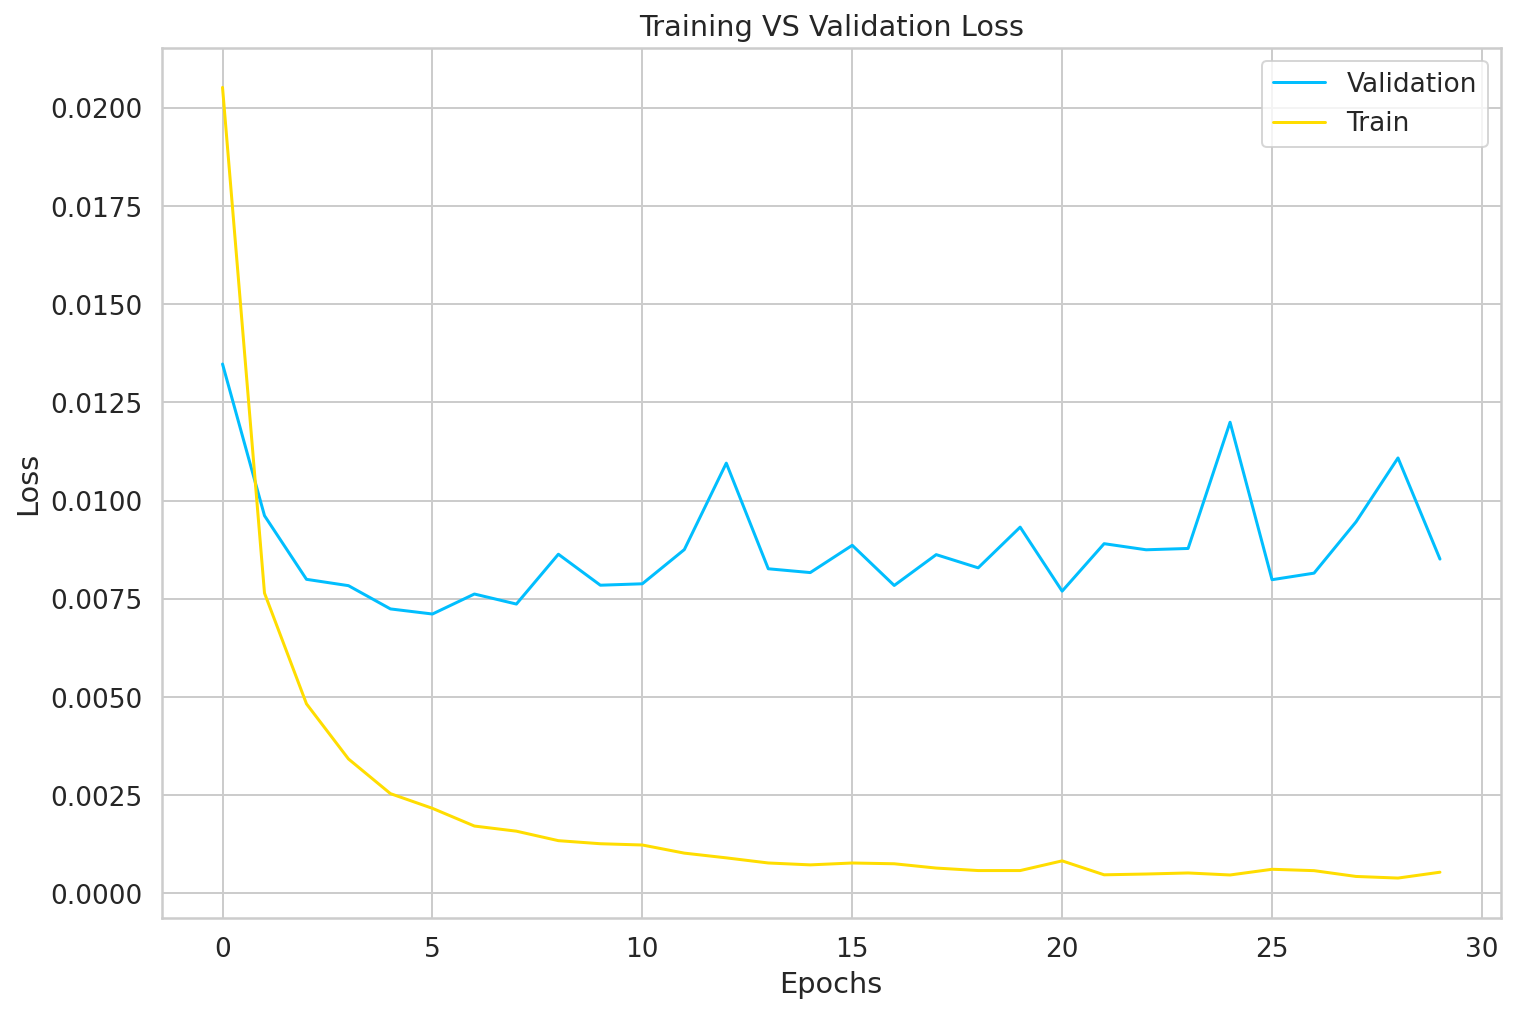

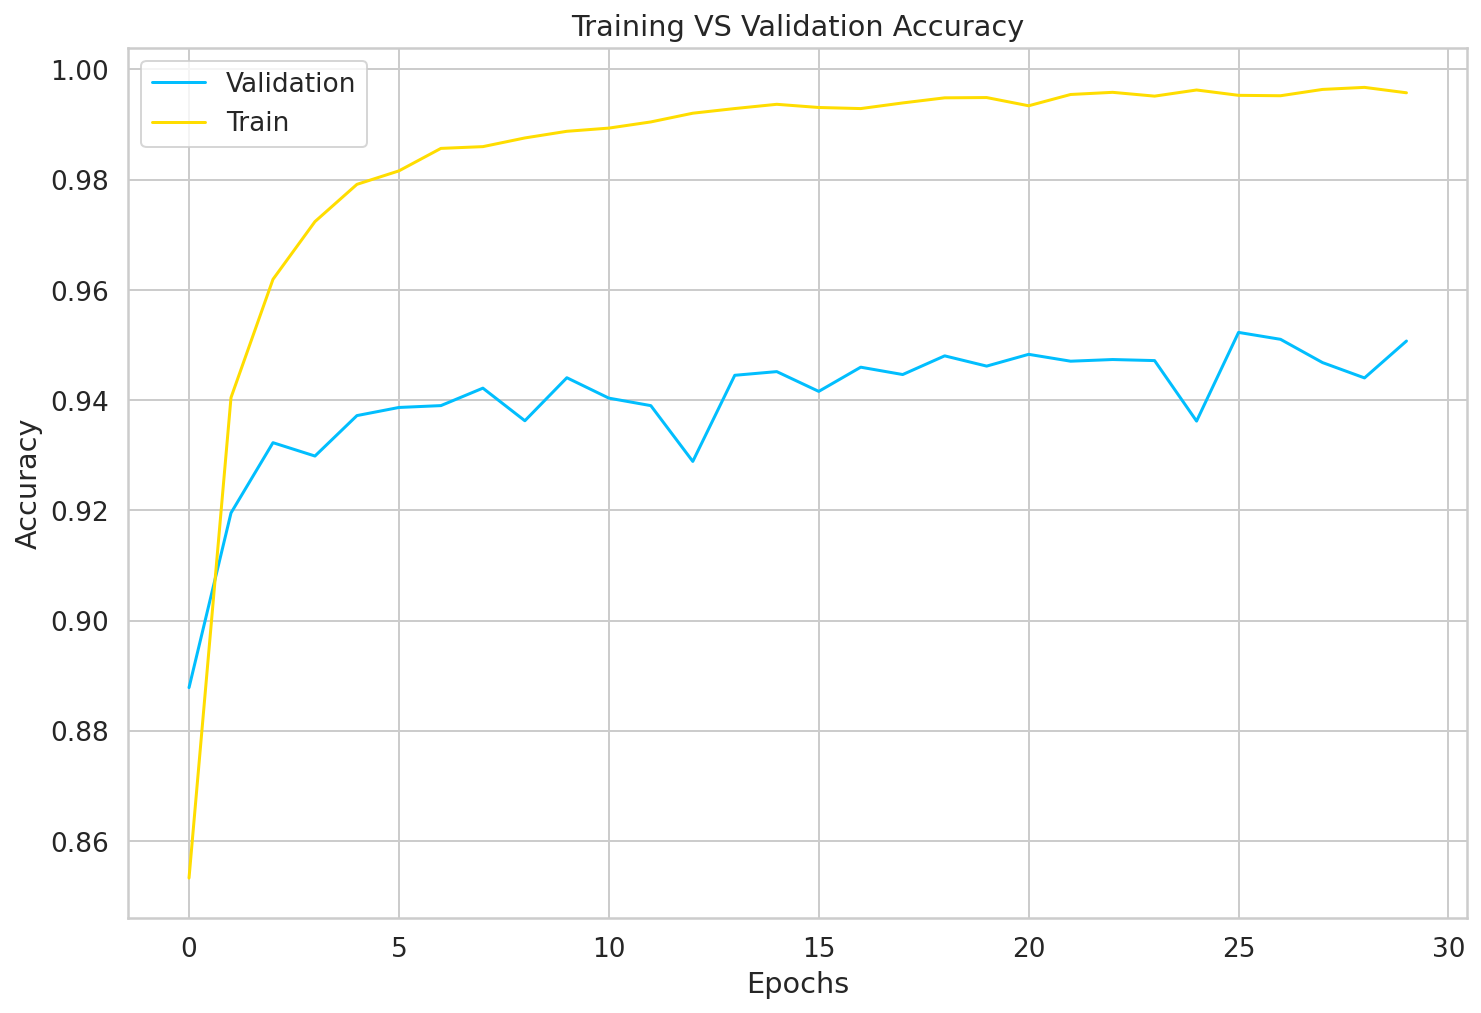

In [ ]:
####################################Setting 3
learning_rate = 0.00015
num_epochs = 30

use_cuda = True
model_3 = TransferNet()

if use_cuda and torch.cuda.is_available():
  model_3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_3, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8451657635371265 0.8794788418708241
epoch =  1
1 0.9352742568814545 0.911724573125464
epoch =  2
2 0.9579214080967529 0.9208381588715664
epoch =  3
3 0.9692055012368949 0.9282887899034893
epoch =  4
4 0.9757924569050143 0.930981997030438
epoch =  5
5 0.9801774453213964 0.9200011135857461
epoch =  6
6 0.9833898181960969 0.9307017446176689
epoch =  7
7 0.9850488671614245 0.9355425018559762
epoch =  8
8 0.98693348254604 0.9374326280623607
epoch =  9
9 0.9871001492127071 0.9319252041573867
epoch =  10
10 0.9889206620332197 0.9315122494432071
epoch =  11
11 0.9904411002473791 0.9382622494432071
epoch =  12
12 0.9904206620332194 0.9388758351893096
epoch =  13
13 0.9918641771704559 0.9439400519673349
epoch =  14
14 0.9903974358974359 0.9472733853006682
epoch =  15
15 0.9932692307692308 0.943989420935412
epoch =  16
16 0.9925564848627635 0.9379252041573867
epoch =  17
17 0.9924026387089175 0.9459363400148477
epoch =  18

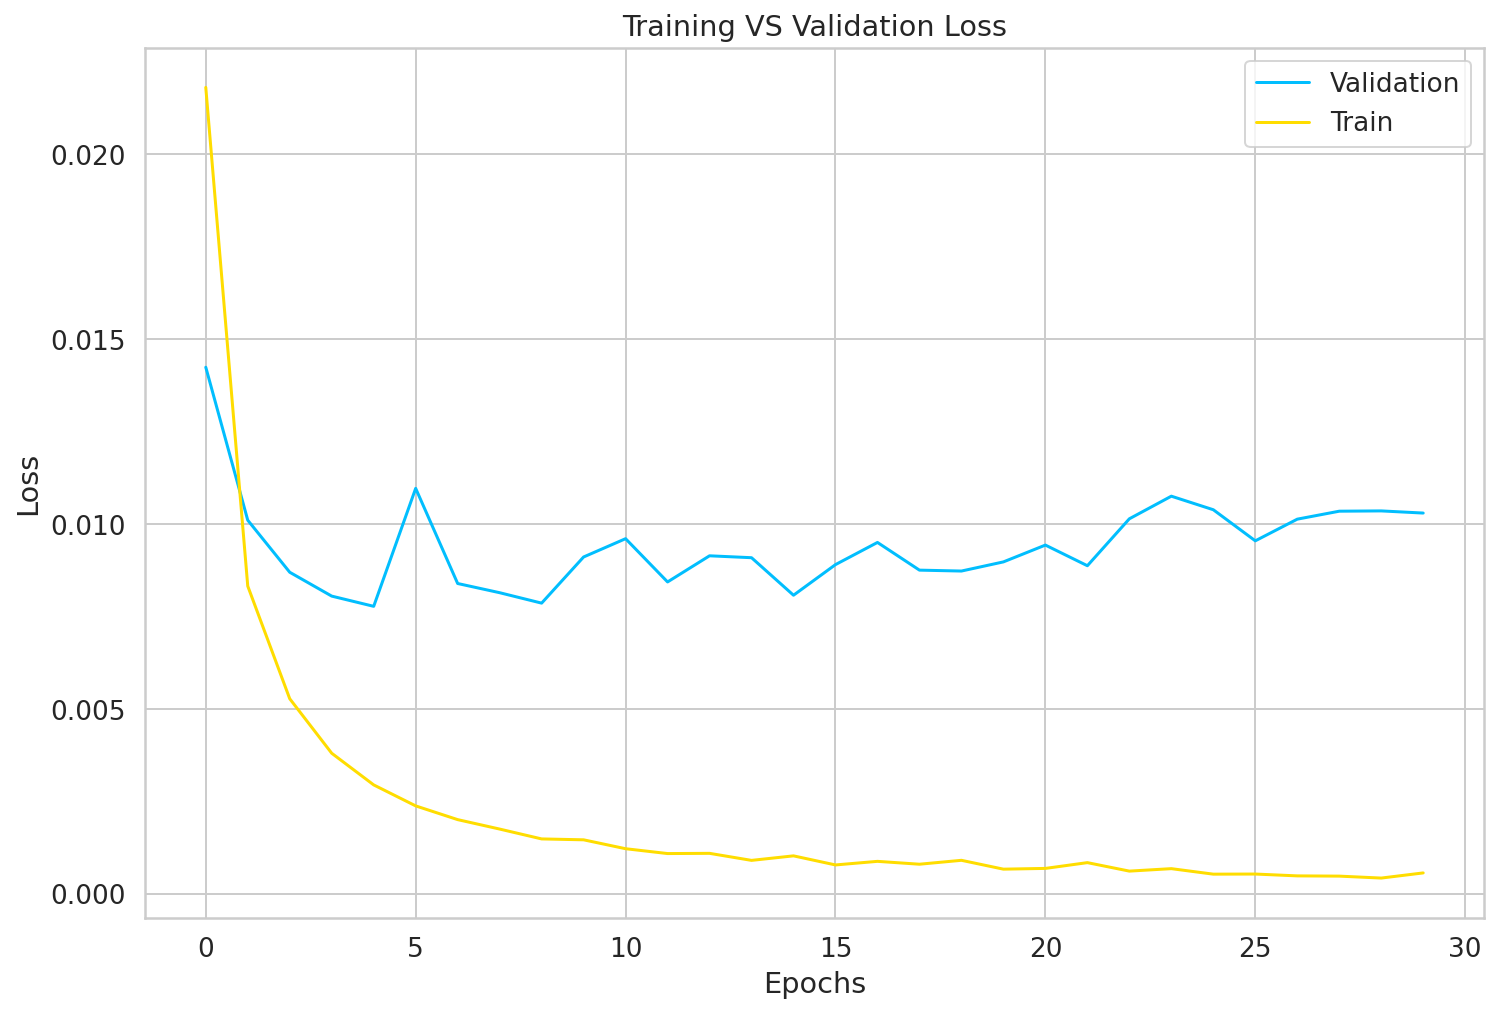

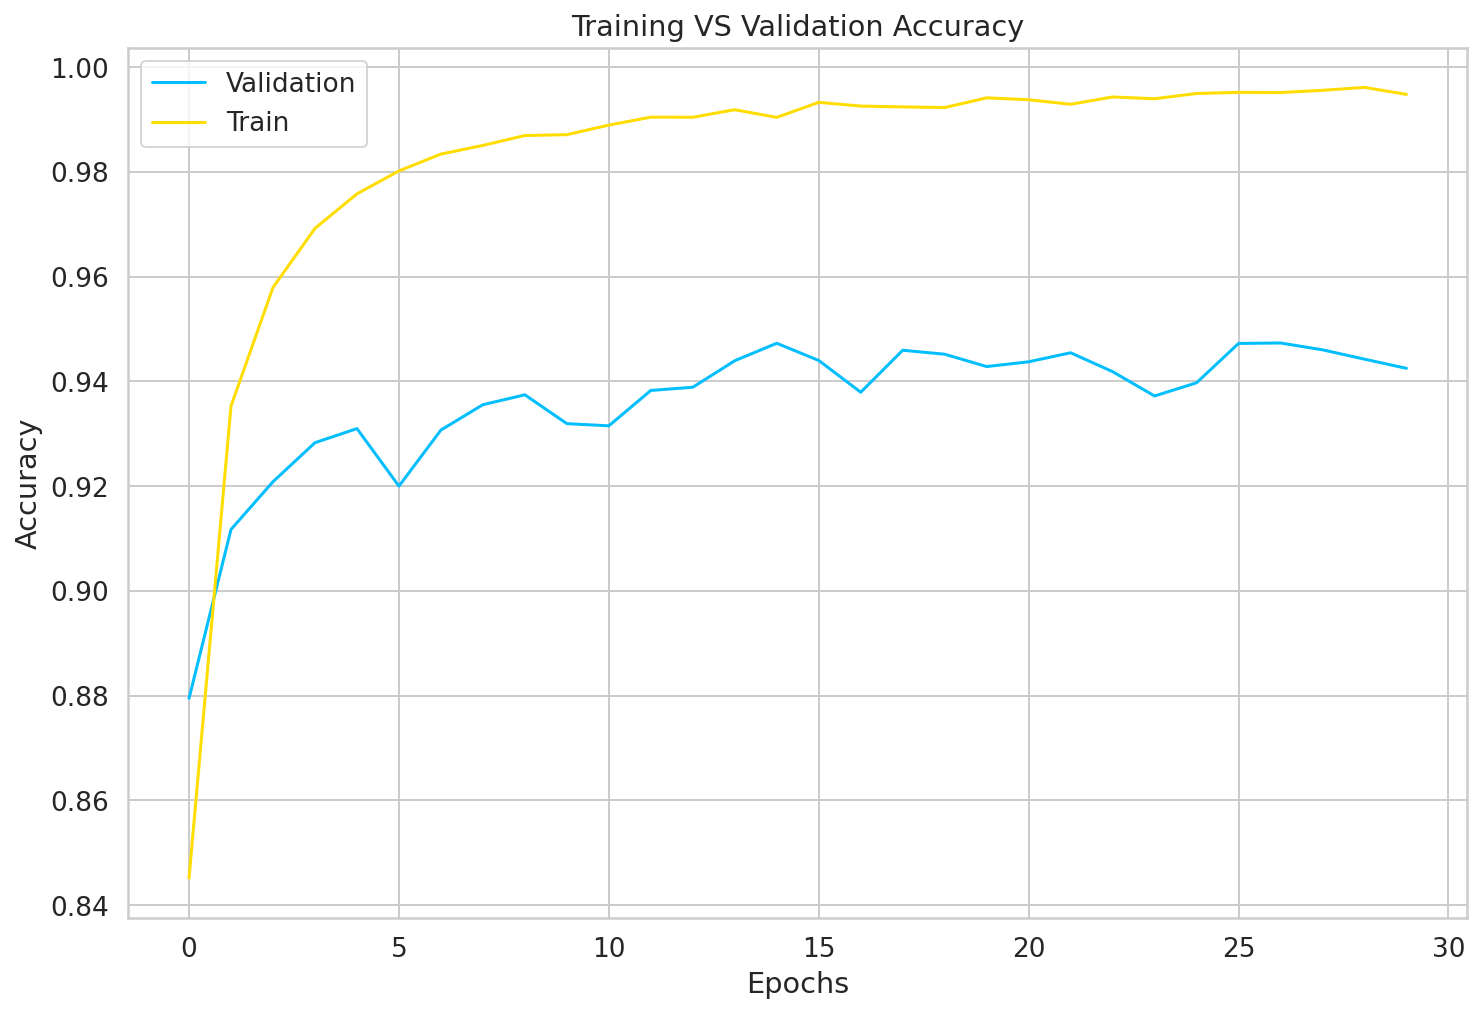

In [ ]:
####################################Setting 4
class TransferNet_1(nn.Module):
    def __init__(self):
        super(TransferNet_1, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 256)
        self.layer2 = nn.Linear(256, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

####################################Setting 4
learning_rate = 0.0003
num_epochs = 30

use_cuda = True
model_4 = TransferNet_1()

if use_cuda and torch.cuda.is_available():
  model_4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_4, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8795953390662425 0.8906566443949517
epoch =  1
1 0.9504189932068953 0.9202850779510023
epoch =  2
2 0.9649290257980917 0.9155048255382331
epoch =  3
3 0.9721361958613107 0.9263949517446177
epoch =  4
4 0.9788489417677779 0.9311184112843356
epoch =  5
5 0.9805131935445872 0.9302319970304381
epoch =  6
6 0.9828257156319942 0.9234517446176689
epoch =  7
7 0.9839438881690031 0.9401221232368225
epoch =  8
8 0.986823300742137 0.9423795471417965
epoch =  9
9 0.9885000000000002 0.9343758351893096
epoch =  10
10 0.9897924569050142 0.9391221232368226
epoch =  11
11 0.9908052774178345 0.9343418708240534
epoch =  12
12 0.9909026387089175 0.9460425018559763
epoch =  13
13 0.9911794871794873 0.946989420935412
epoch =  14
14 0.992659048965328 0.9473227542687453
epoch =  15
15 0.9920104056229628 0.9403190423162584
epoch =  16
16 0.9941538461538459 0.9500499257609503
epoch =  17
17 0.9923180979306557 0.9474060876020787
epoch =  

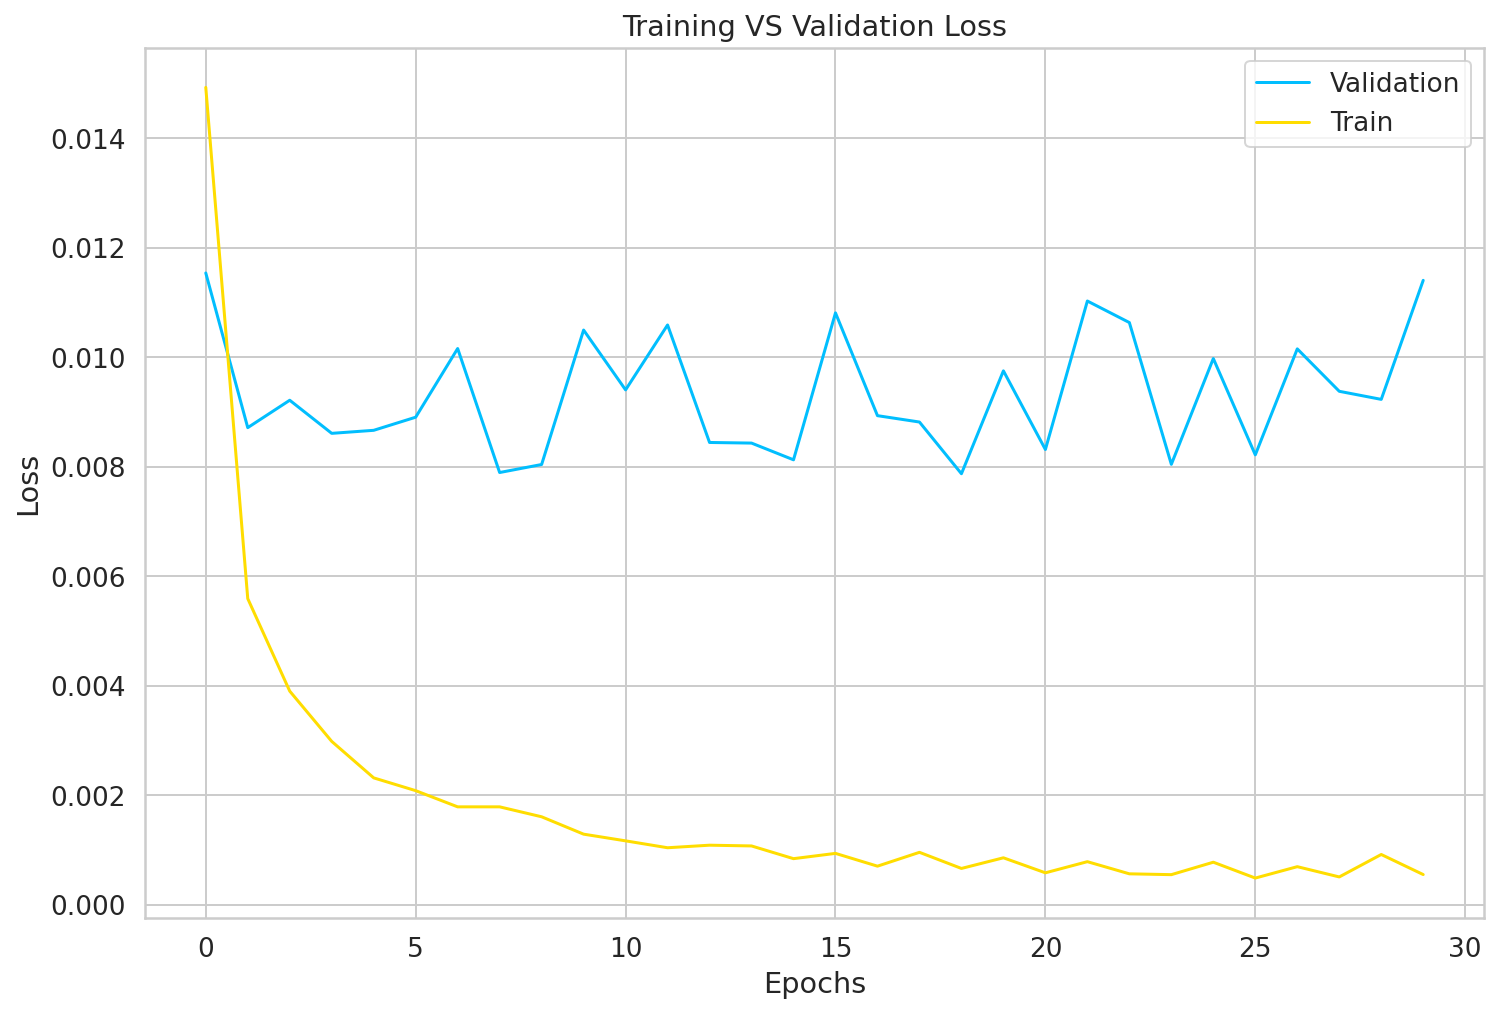

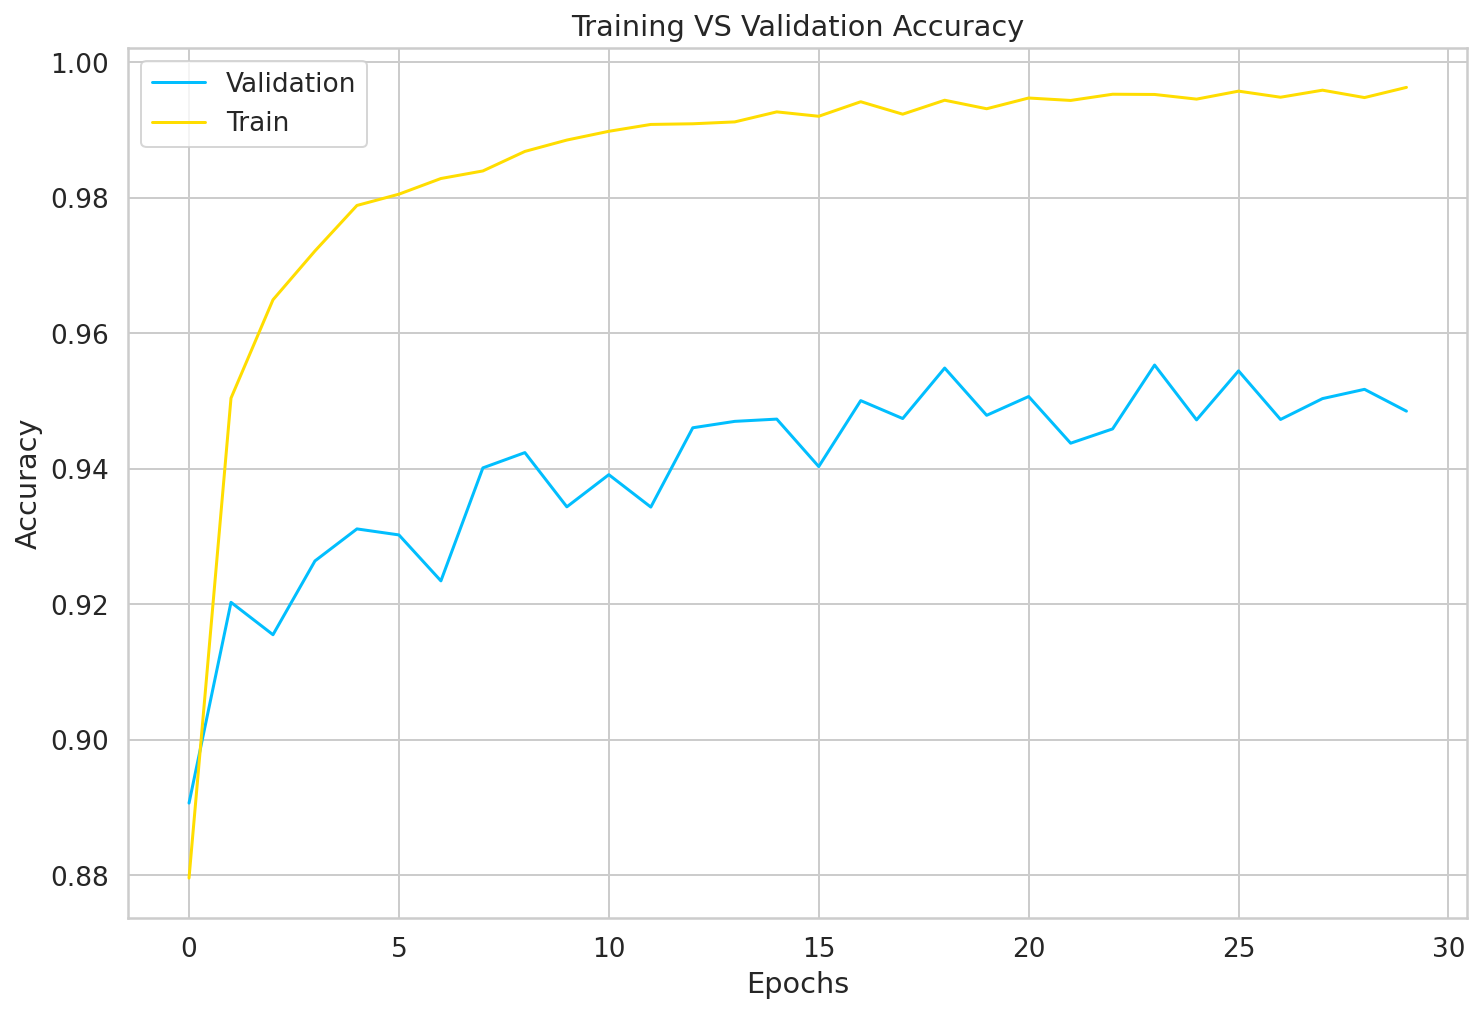

In [ ]:
####################################Setting 5
class TransferNet_2(nn.Module):
    def __init__(self):
        super(TransferNet_2, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 2048)
        self.layer2 = nn.Linear(2048, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

####################################Setting 5
learning_rate = 0.0003
num_epochs = 30

use_cuda = True
model_5 = TransferNet_2()

if use_cuda and torch.cuda.is_available():
  model_5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_5, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8615680292142774 0.8844029324424647
epoch =  1
1 0.9474758511014254 0.9073572754268746
epoch =  2
2 0.9635340047905133 0.925981997030438
epoch =  3
3 0.9714002238190598 0.932955456570156
epoch =  4
4 0.9755003730317667 0.9336789161098737
epoch =  5
5 0.9803000746063534 0.9226449517446176
epoch =  6
6 0.9801109278674363 0.9268949517446177
epoch =  7
7 0.983061687674245 0.9371900519673348
epoch =  8
8 0.986864177170456 0.9441560876020786
epoch =  9
9 0.987602564102564 0.9407925018559762
epoch =  10
10 0.987425864844701 0.9378832590942836
epoch =  11
11 0.991436270467664 0.9452999257609502
epoch =  12
12 0.9900821258884046 0.9546332590942836
epoch =  13
13 0.9905436643499429 0.9395425018559763
epoch =  14
14 0.9919130443318807 0.9435992947290274
epoch =  15
15 0.9926538461538461 0.9362622494432071
epoch =  16
16 0.9926718694781482 0.9485270972531552
epoch =  17
17 0.9931410256410257 0.9497696733481811
epoch =  18
1

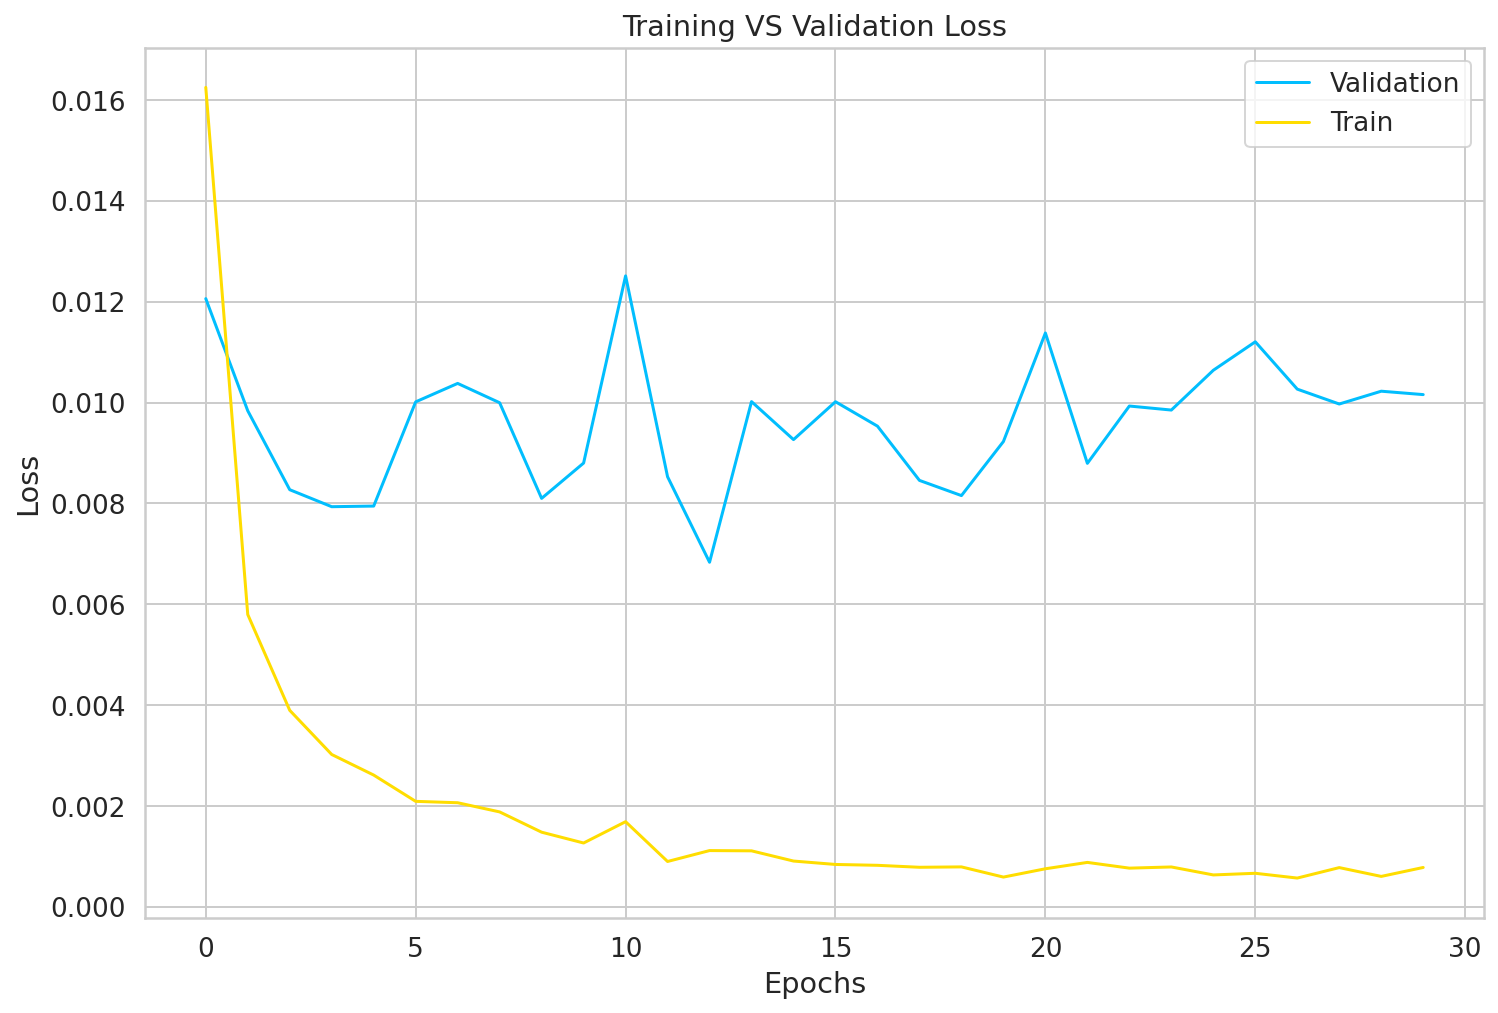

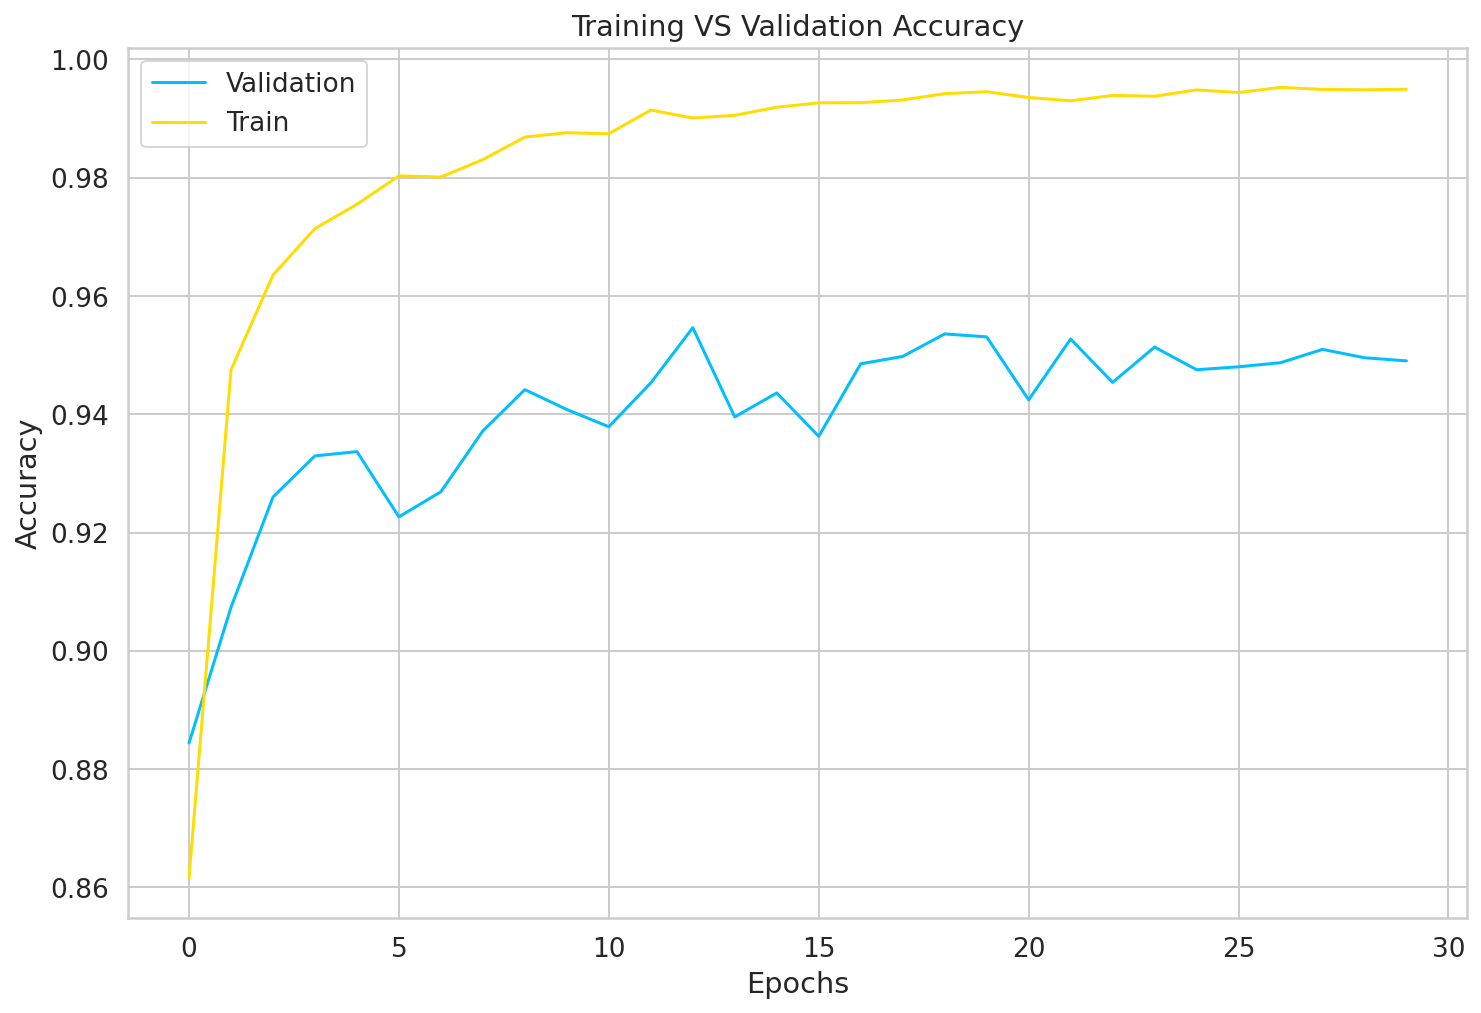

In [ ]:
####################################Setting 6
class TransferNet_3(nn.Module):
    def __init__(self):
        super(TransferNet_3, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 2048)
        self.layer2 = nn.Linear(2048, 512) 
        self.layer3 = nn.Linear(512, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

####################################Setting 6
learning_rate = 0.0003
num_epochs = 30

use_cuda = True
model_6 = TransferNet_3()

if use_cuda and torch.cuda.is_available():
  model_6.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_6, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8444065653590923 0.8731757609502598
epoch =  1
1 0.9267670122118822 0.9019368968077208
epoch =  2
2 0.9499020889778929 0.9160011135857461
epoch =  3
3 0.9628961401028782 0.9237282850779511
epoch =  4
4 0.9716033101660972 0.9275085374907202
epoch =  5
5 0.9774927553304279 0.9311486636971047
epoch =  6
6 0.9816157576471513 0.9348721232368226
epoch =  7
7 0.9847002984254133 0.9357054565701559
epoch =  8
8 0.9872002984254136 0.936955456570156
epoch =  9
9 0.9894975851101429 0.9372887899034893
epoch =  10
10 0.9910745081870657 0.9378721232368226
epoch =  11
11 0.9922155338280914 0.9378721232368226
epoch =  12
12 0.993389818196097 0.9387887899034892
epoch =  13
13 0.9941538461538463 0.9399554565701559
epoch =  14
14 0.9948717948717948 0.9380085374907201
epoch =  15
15 0.9955256410256411 0.93850853749072
epoch =  16
16 0.9961025641025643 0.9379252041573867
epoch =  17
17 0.9967051282051282 0.9378418708240535
epoch =  1

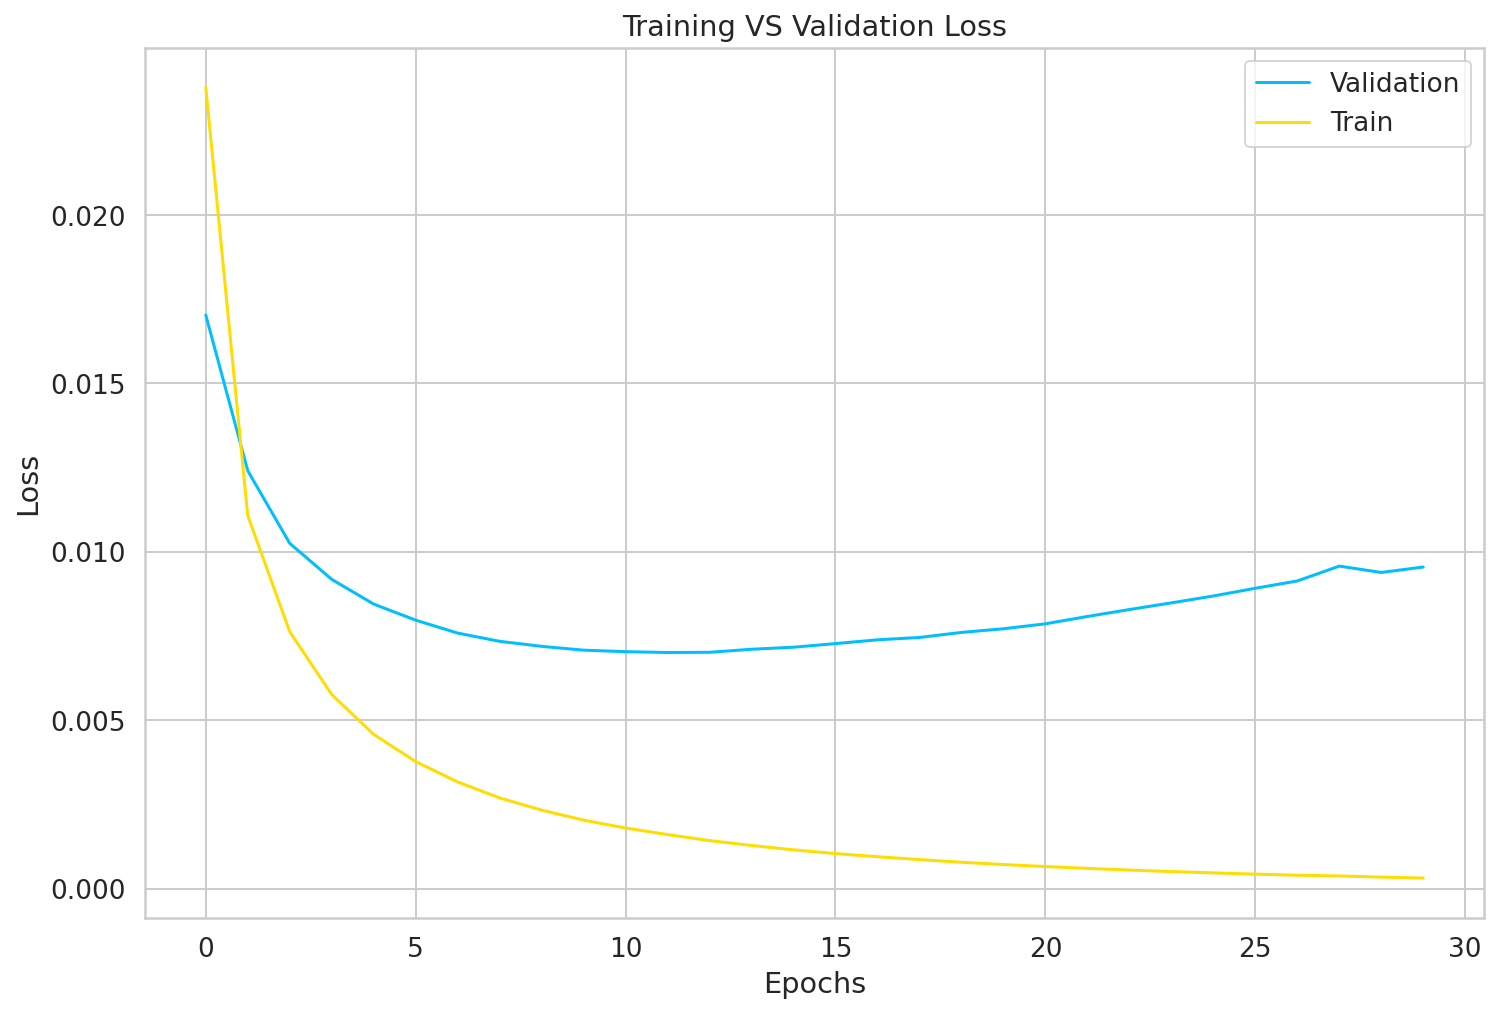

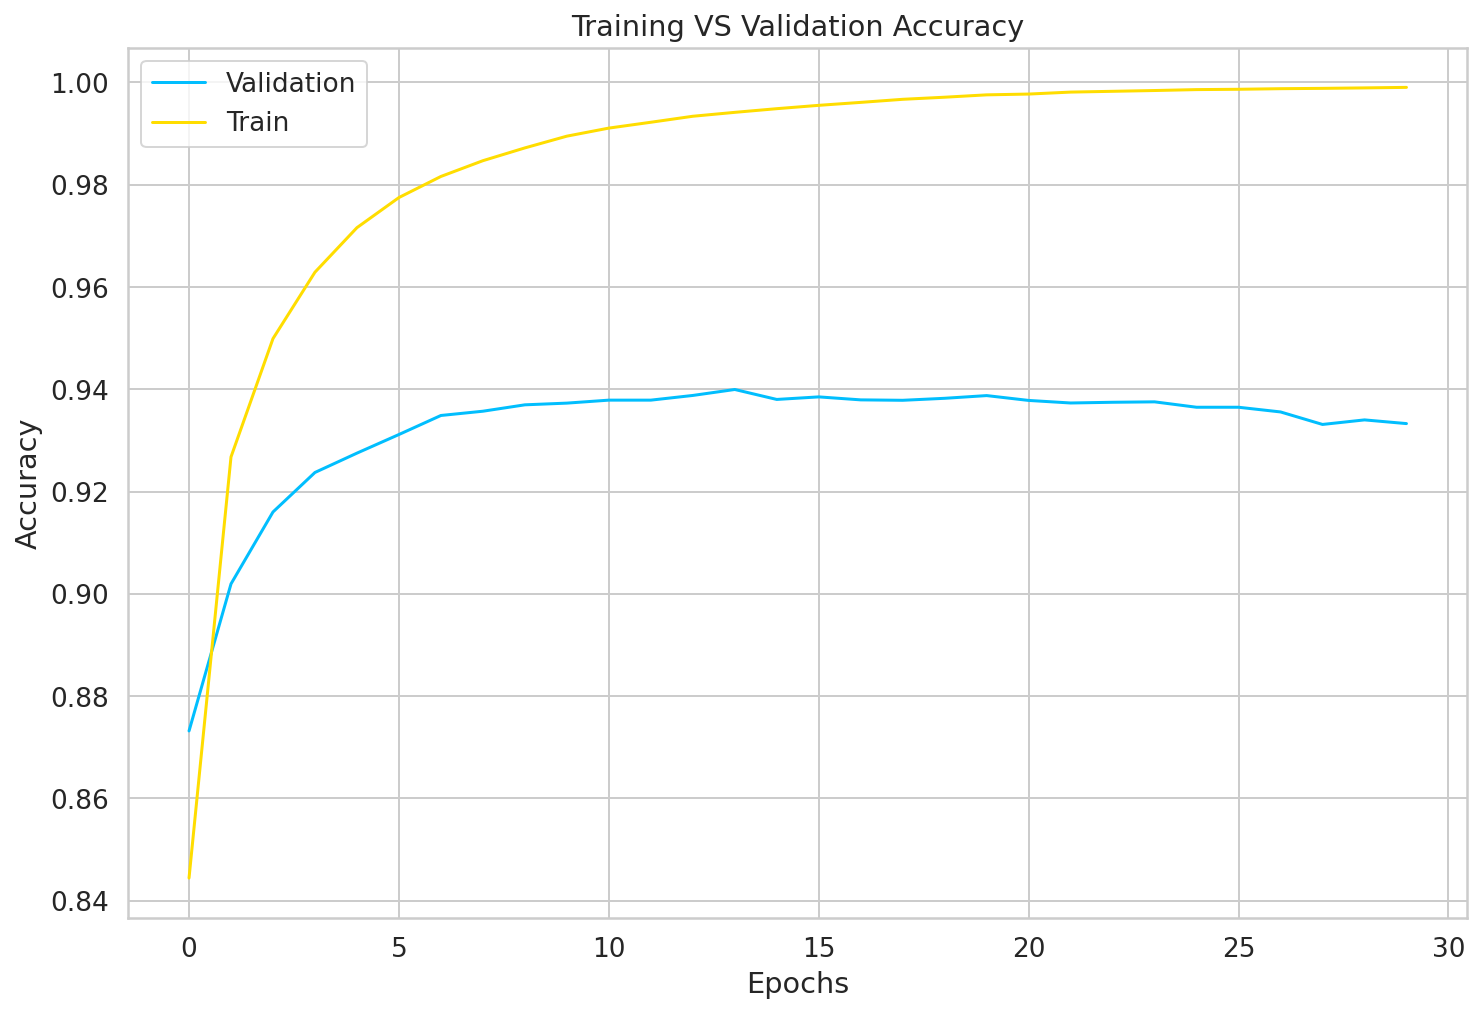

In [ ]:
####################################Setting 7
class TransferNet_4(nn.Module):
    def __init__(self):
        super(TransferNet_4, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 43)
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = self.layer1(x)
        return x

####################################Setting 7
learning_rate = 0.0003
num_epochs = 30

use_cuda = True
model_7 = TransferNet_4()

if use_cuda and torch.cuda.is_available():
  model_7.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_7, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8843853810813994 0.8851529324424647
epoch =  1
1 0.9481269093336473 0.9116412397921306
epoch =  2
2 0.9618829465582912 0.9209517446176689
epoch =  3
3 0.9712515804766954 0.9197548255382331
epoch =  4
4 0.9748208858522793 0.9278153303637714
epoch =  5
5 0.9803593473907408 0.9273721232368226
epoch =  6
6 0.9820260140574079 0.9241184112843355
epoch =  7
7 0.9844206620332194 0.9291523756495917
epoch =  8
8 0.9856822751011113 0.9260350779510023
epoch =  9
9 0.9885616876742452 0.9286221232368226
epoch =  10
10 0.9887463776652137 0.9238116184112843
epoch =  11
11 0.990423076923077 0.9325955827765405
epoch =  12
12 0.9900384615384615 0.9288684112843355
epoch =  13
13 0.9903589743589744 0.9332622494432071
epoch =  14
14 0.9910693053755841 0.9351523756495916
epoch =  15
15 0.9920821258884044 0.9363153303637713
epoch =  16
16 0.9929102564102565 0.932239420935412
epoch =  17
17 0.99275641025641 0.9338758351893096
epoch =  1

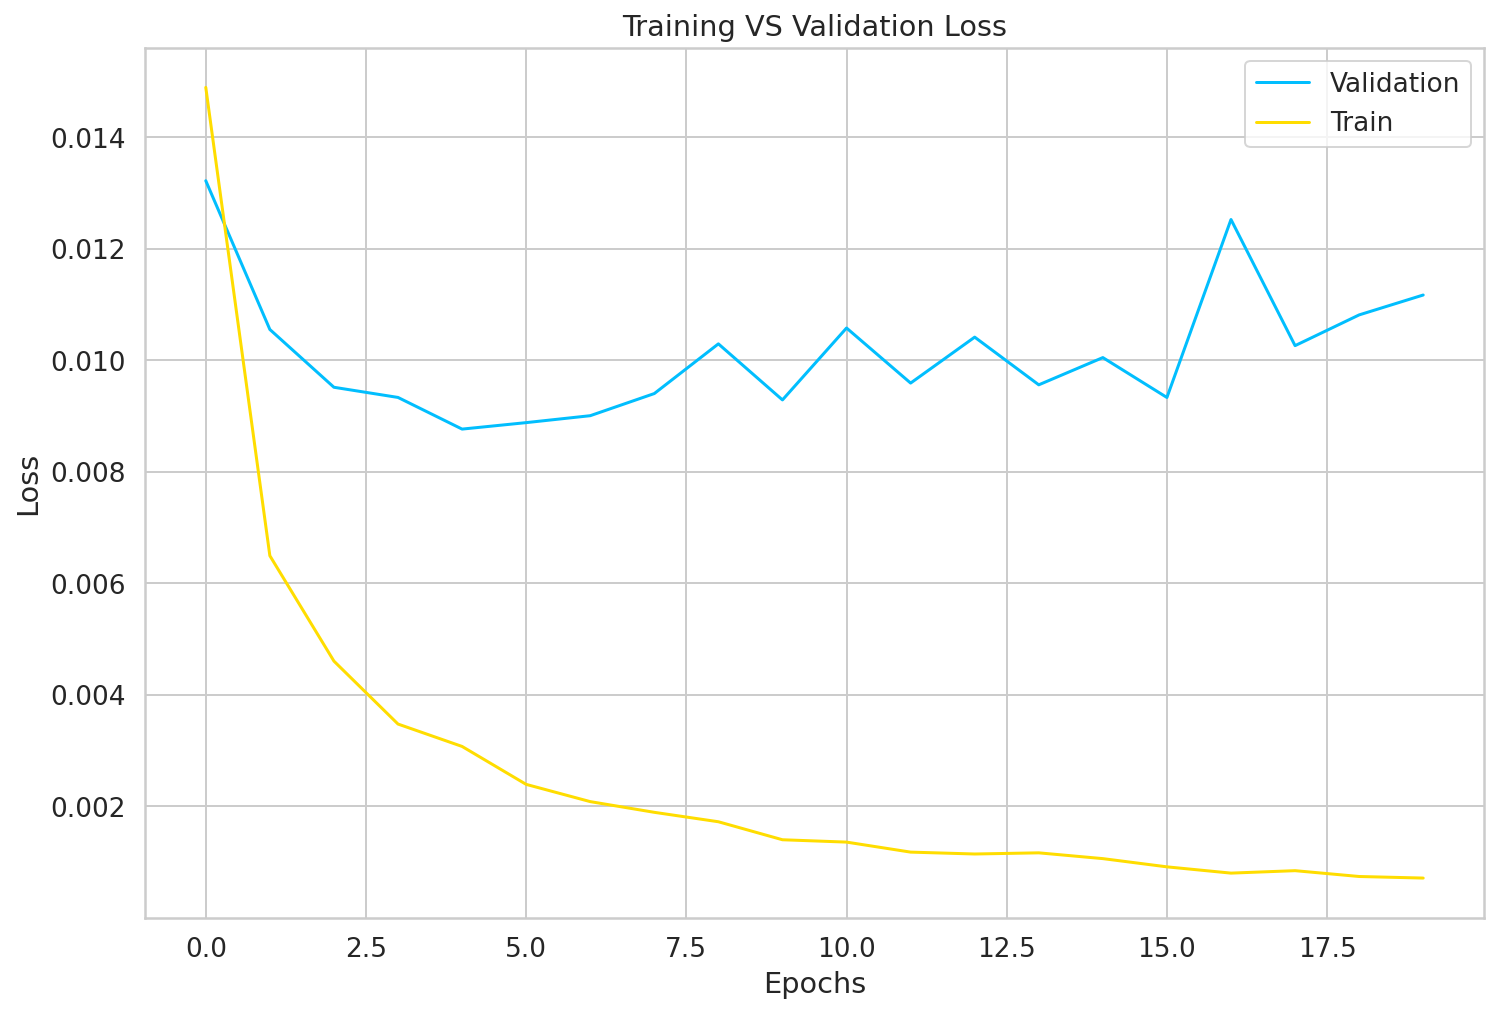

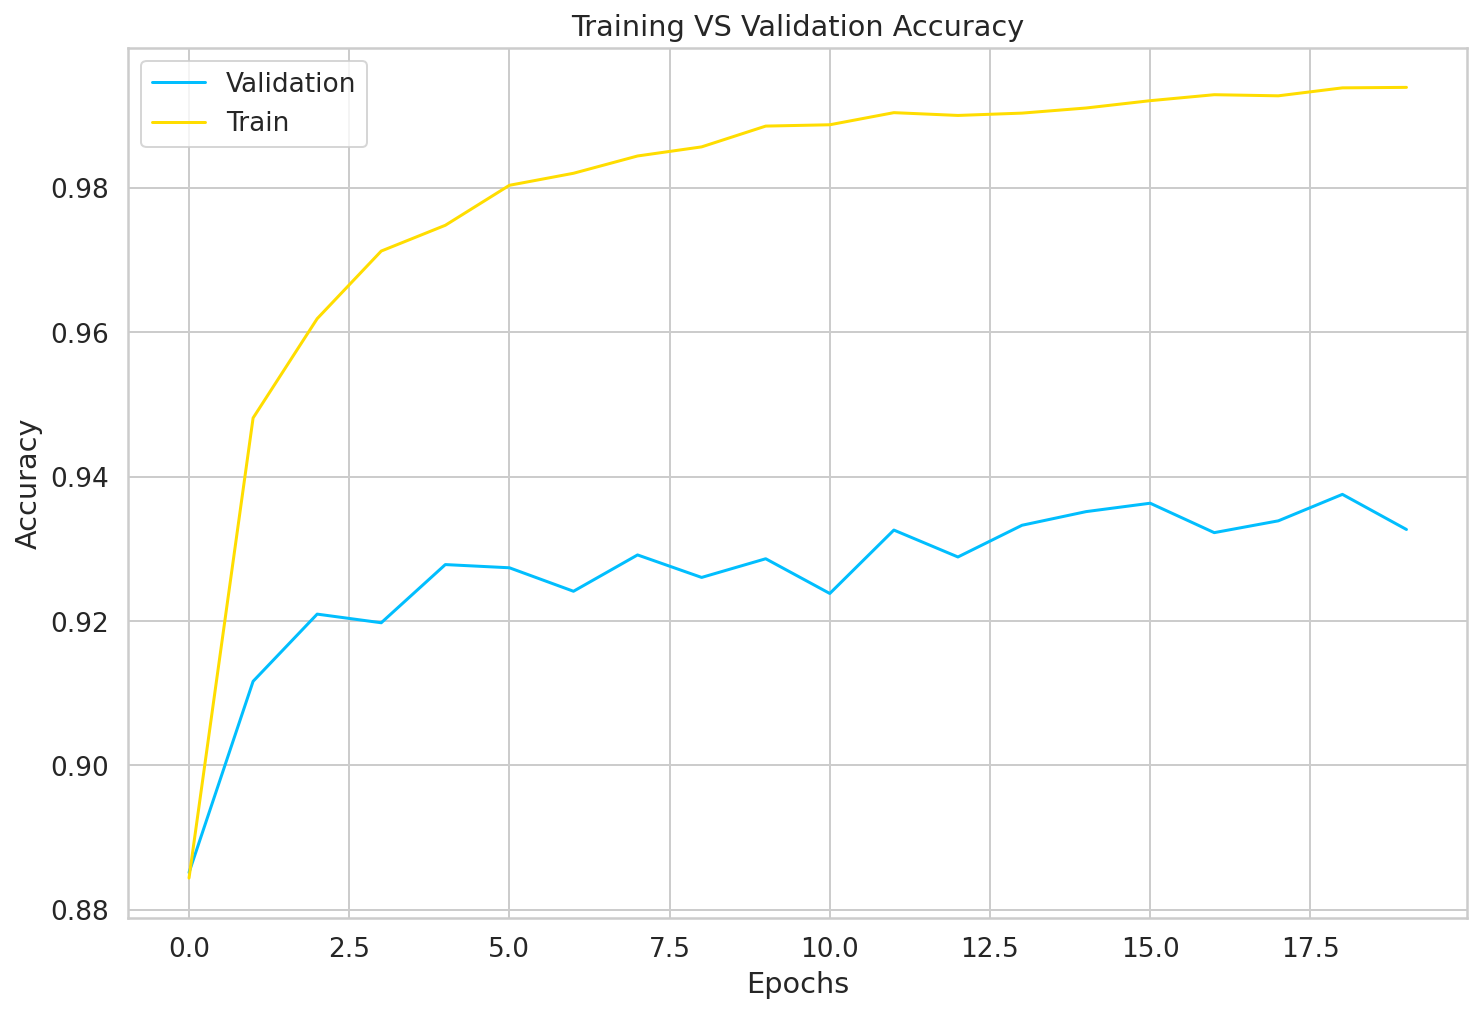

In [ ]:
####################################Setting 8
class TransferNet_4(nn.Module):
    def __init__(self):
        super(TransferNet_4, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 43)
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = self.layer1(x)
        return x

####################################Setting 8
learning_rate = 0.001
num_epochs = 20

use_cuda = True
model_7 = TransferNet_4()

if use_cuda and torch.cuda.is_available():
  model_7.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_7, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8176208033926258 0.8669523014105418
epoch =  1
1 0.9347922802057563 0.9001375278396436
epoch =  2
2 0.9574117485373228 0.912724573125464
epoch =  3
3 0.9700059488750148 0.921701744617669
epoch =  4
4 0.9753978089292027 0.9303153303637713
epoch =  5
5 0.9803156830407977 0.9280616184112844
epoch =  6
6 0.9826029371343308 0.9342622494432071
epoch =  7
7 0.9840308438371227 0.9400727542687454
epoch =  8
8 0.9849206620332196 0.9358492947290274
epoch =  9
9 0.9857796363921939 0.9409326280623608
epoch =  10
10 0.9875492401931912 0.9393492947290275
epoch =  11
11 0.9890436643499433 0.9423758351893096
epoch =  12
12 0.9923461538461539 0.9388721232368226
epoch =  13
13 0.989397435897436 0.9406560876020786
epoch =  14
14 0.9919487179487179 0.9418264662212323
epoch =  15
15 0.9916025641025641 0.9509326280623608
epoch =  16
16 0.9927948717948717 0.9488832590942837
epoch =  17
17 0.9936590489653278 0.9381789161098738
epoch =  

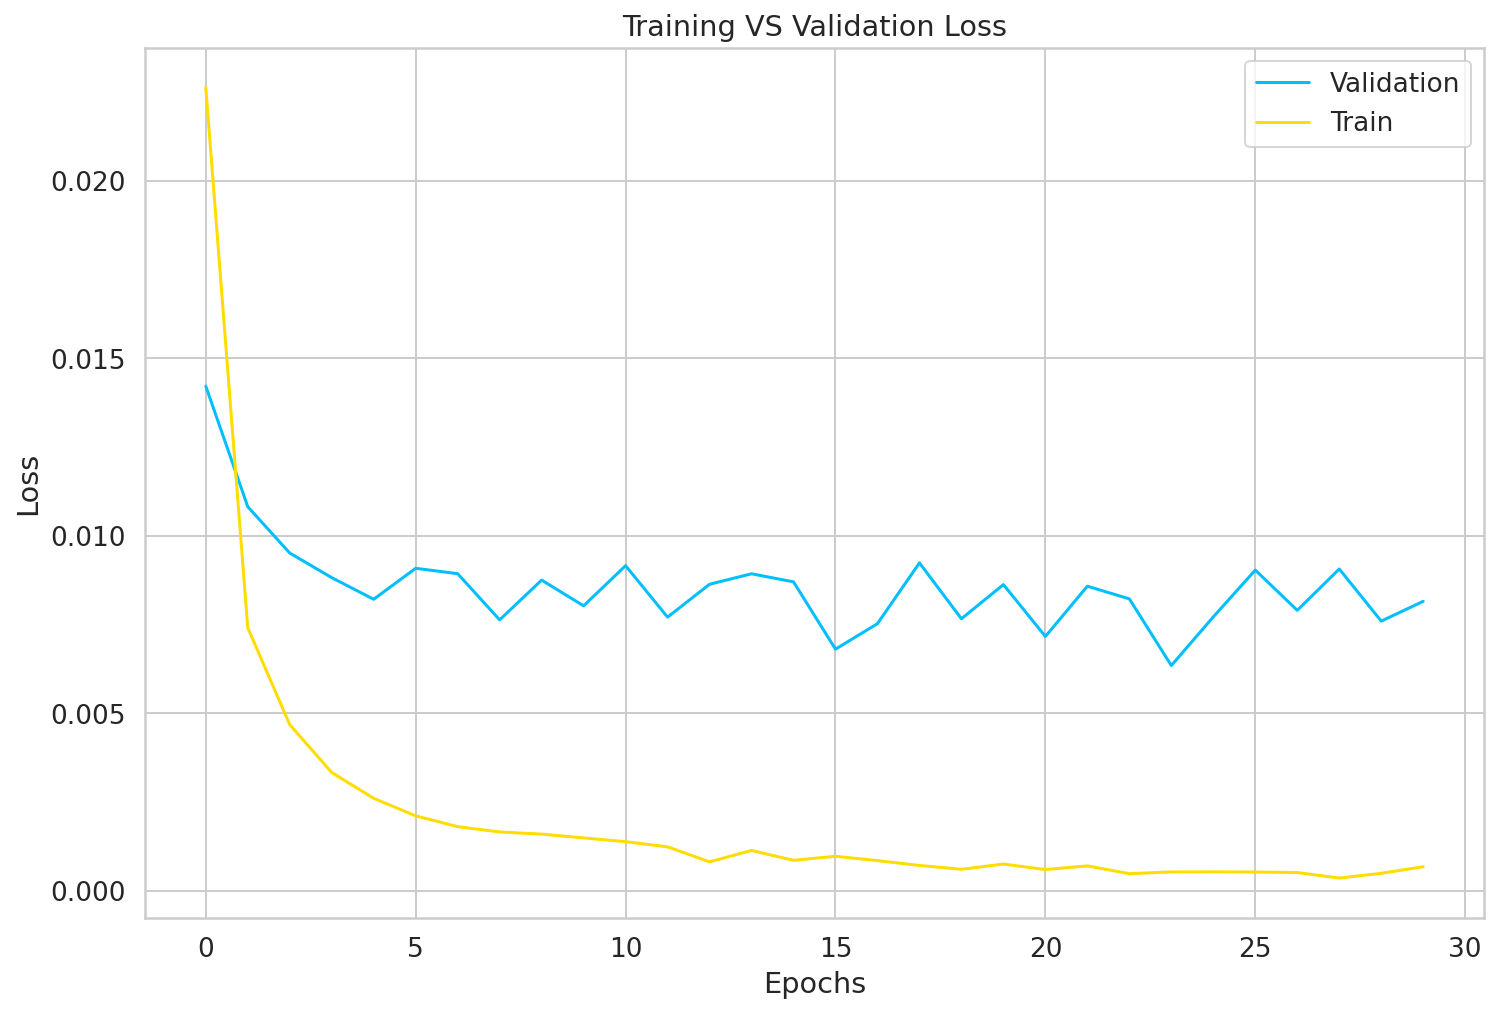

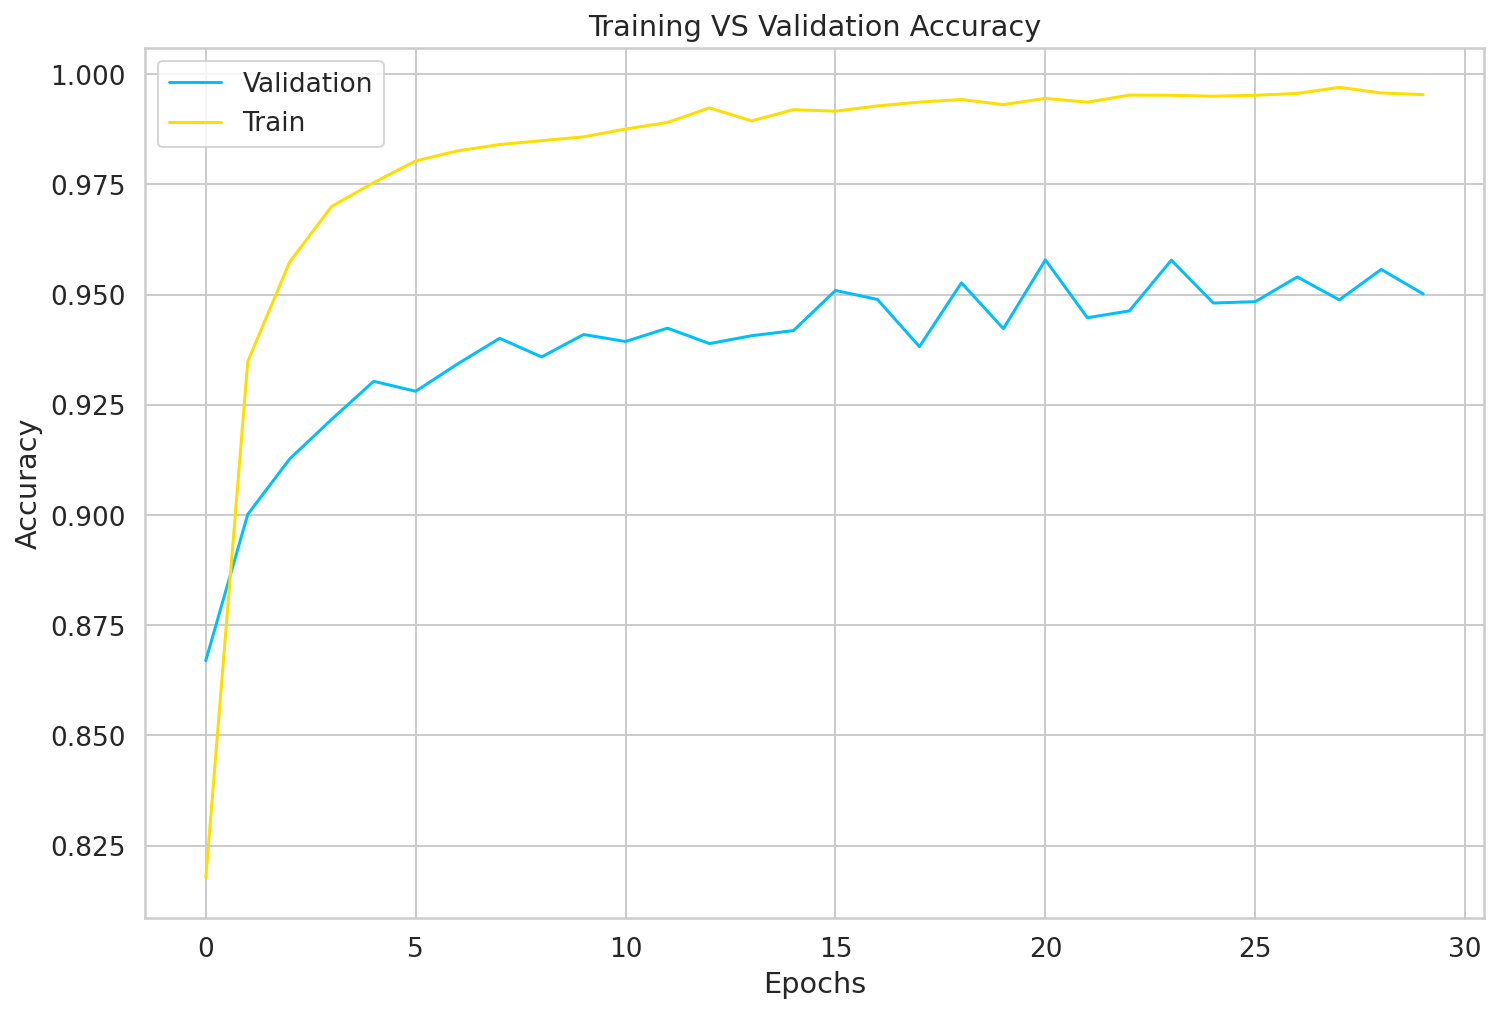

In [ ]:
####################################Setting 9
class TransferNet_4(nn.Module):
    def __init__(self):
        super(TransferNet_4, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 3072)
        self.layer2 = nn.Linear(3072, 1024) 
        self.layer3 = nn.Linear(1024, 256) 
        self.layer4 = nn.Linear(256, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

####################################Setting 9
learning_rate = 0.0001
num_epochs = 30

use_cuda = True
model_9 = TransferNet_4()

if use_cuda and torch.cuda.is_available():
  model_9.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_9, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

###Test Model

In [ ]:
master_path = '/content/data_all/'
test_feature_path = glob(f'{master_path}/features/test_features*.npy')
test_acc_features = 0
use_cuda = True

for test_path in test_feature_path:
    test_features = np.load(f'{test_path}', allow_pickle=True)
    test_acc_features += get_accuracy(model_9, test_features)

test_acc_features = test_acc_features/len(test_feature_path)
print("Test accuracy: ", test_acc_features)

Test accuracy:  0.9472937853107345


In [ ]:
master_path = '/content/data_all/'
test_feature_path = glob(f'{master_path}/features/test_features*.npy')
test_acc_features = 0
correct_label, pred_label = [], []
use_cuda = True

for test_path in test_feature_path:
    test_features = np.load(f'{test_path}', allow_pickle=True)
    acc, corr, pred = get_accuracy_for_confusion(model_9, test_features)
    test_acc_features += acc
    correct_label.extend(corr)
    pred_label.extend(pred)
test_acc_features = test_acc_features/len(test_feature_path)
print("Test accuracy: ", test_acc_features)
print("correct_label: ", len(correct_label))
print("pred_label: ", len(pred_label))

Test accuracy:  0.9472937853107345
correct_label:  9472
pred_label:  9472


In [ ]:
print(pred_label)

[tensor([30], device='cuda:0'), tensor([30], device='cuda:0'), tensor([28], device='cuda:0'), tensor([41], device='cuda:0'), tensor([24], device='cuda:0'), tensor([38], device='cuda:0'), tensor([13], device='cuda:0'), tensor([42], device='cuda:0'), tensor([0], device='cuda:0'), tensor([4], device='cuda:0'), tensor([10], device='cuda:0'), tensor([23], device='cuda:0'), tensor([0], device='cuda:0'), tensor([22], device='cuda:0'), tensor([39], device='cuda:0'), tensor([7], device='cuda:0'), tensor([21], device='cuda:0'), tensor([28], device='cuda:0'), tensor([37], device='cuda:0'), tensor([33], device='cuda:0'), tensor([39], device='cuda:0'), tensor([41], device='cuda:0'), tensor([36], device='cuda:0'), tensor([21], device='cuda:0'), tensor([33], device='cuda:0'), tensor([9], device='cuda:0'), tensor([38], device='cuda:0'), tensor([2], device='cuda:0'), tensor([28], device='cuda:0'), tensor([31], device='cuda:0'), tensor([38], device='cuda:0'), tensor([3], device='cuda:0'), tensor([6], de

In [ ]:
correct_label.cuda()
classifier = confusion_matrix(correct_label, pred_label)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, correct_label, pred_label,
                                 display_labels=new_class,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

AttributeError: ignored

In [ ]:
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)


CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.7577571955864453 0.840963994060876
epoch =  1
1 0.909475301370401 0.8826794729027468
epoch =  2
2 0.9413684572191463 0.9019936896807721
epoch =  3
3 0.9582855852672084 0.916724573125464
epoch =  4
4 0.9683877763380063 0.9268418708240536
epoch =  5
5 0.9753056504496013 0.9307319970304381
epoch =  6
6 0.9786698276200572 0.929228285077951
epoch =  7
7 0.9816566340754699 0.9243949517446177
epoch =  8
8 0.982348941767778 0.9303418708240534
epoch =  9
9 0.9858641771704557 0.9285616184112844
epoch =  10
10 0.9874719440845016 0.9300690423162583
epoch =  11
11 0.9891898928024503 0.9358190423162583
epoch =  12
12 0.9889110024737898 0.9341523756495916
epoch =  13
13 0.9898617622805984 0.9376258351893095
epoch =  14
14 0.9912796363921939 0.9383530066815144
epoch =  15
15 0.9913257156319943 0.9371826280623609
epoch =  16
16 0.9914230769230771 0.9426332590942836
epoch =  17
17 0.9928128951191736 0.9469097995545657
epoch =  18

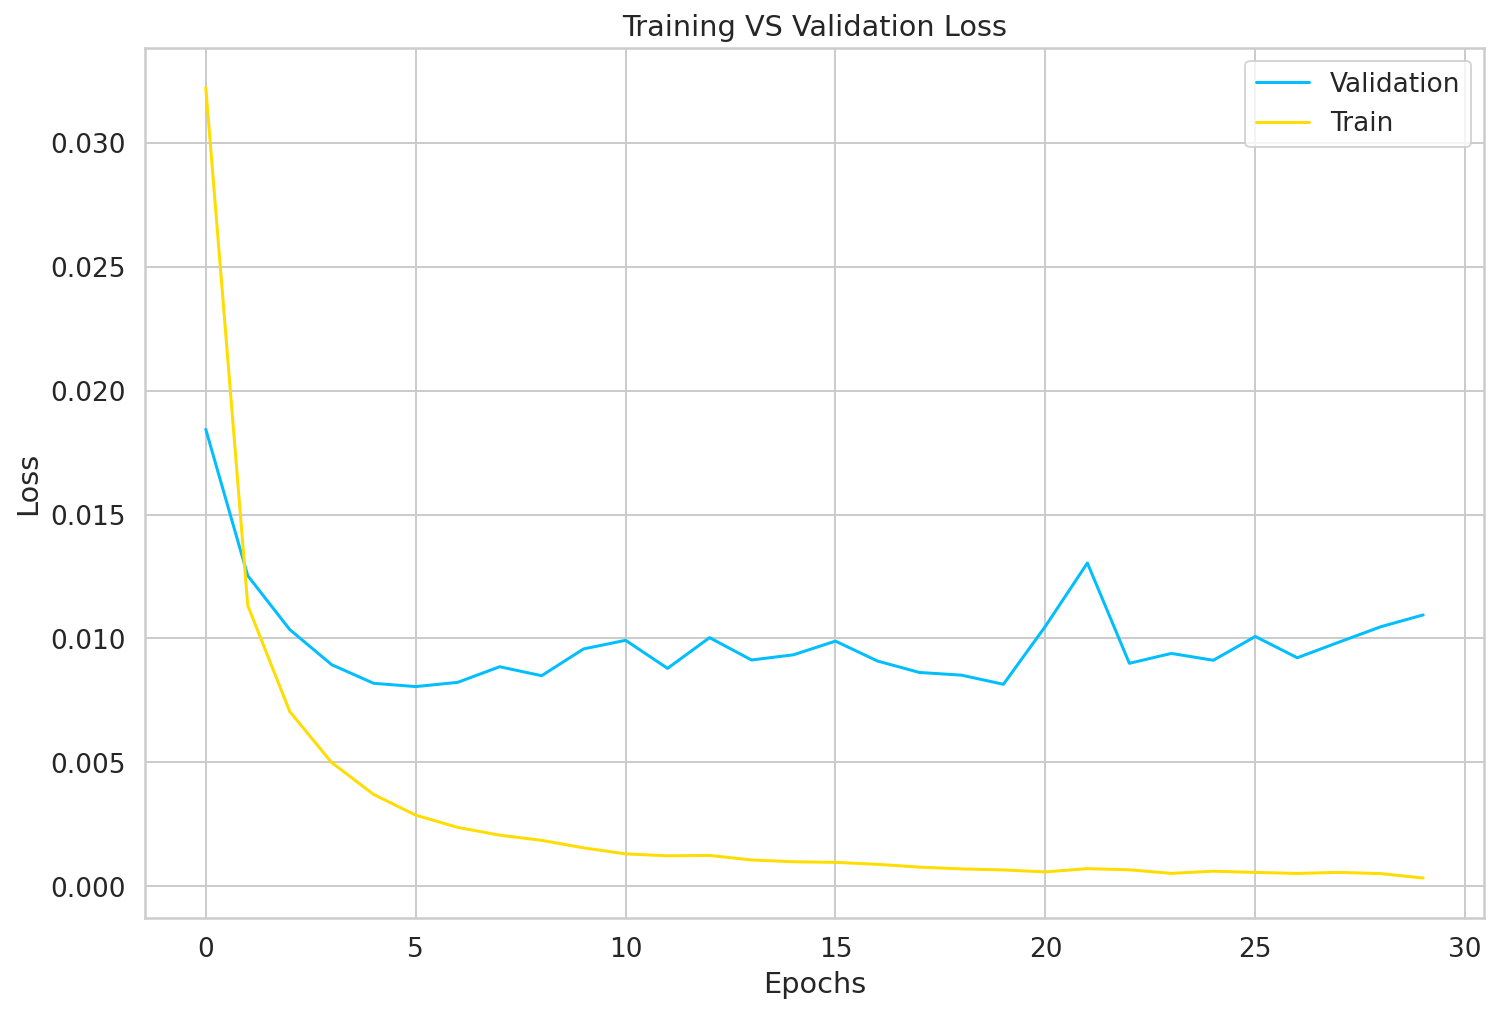

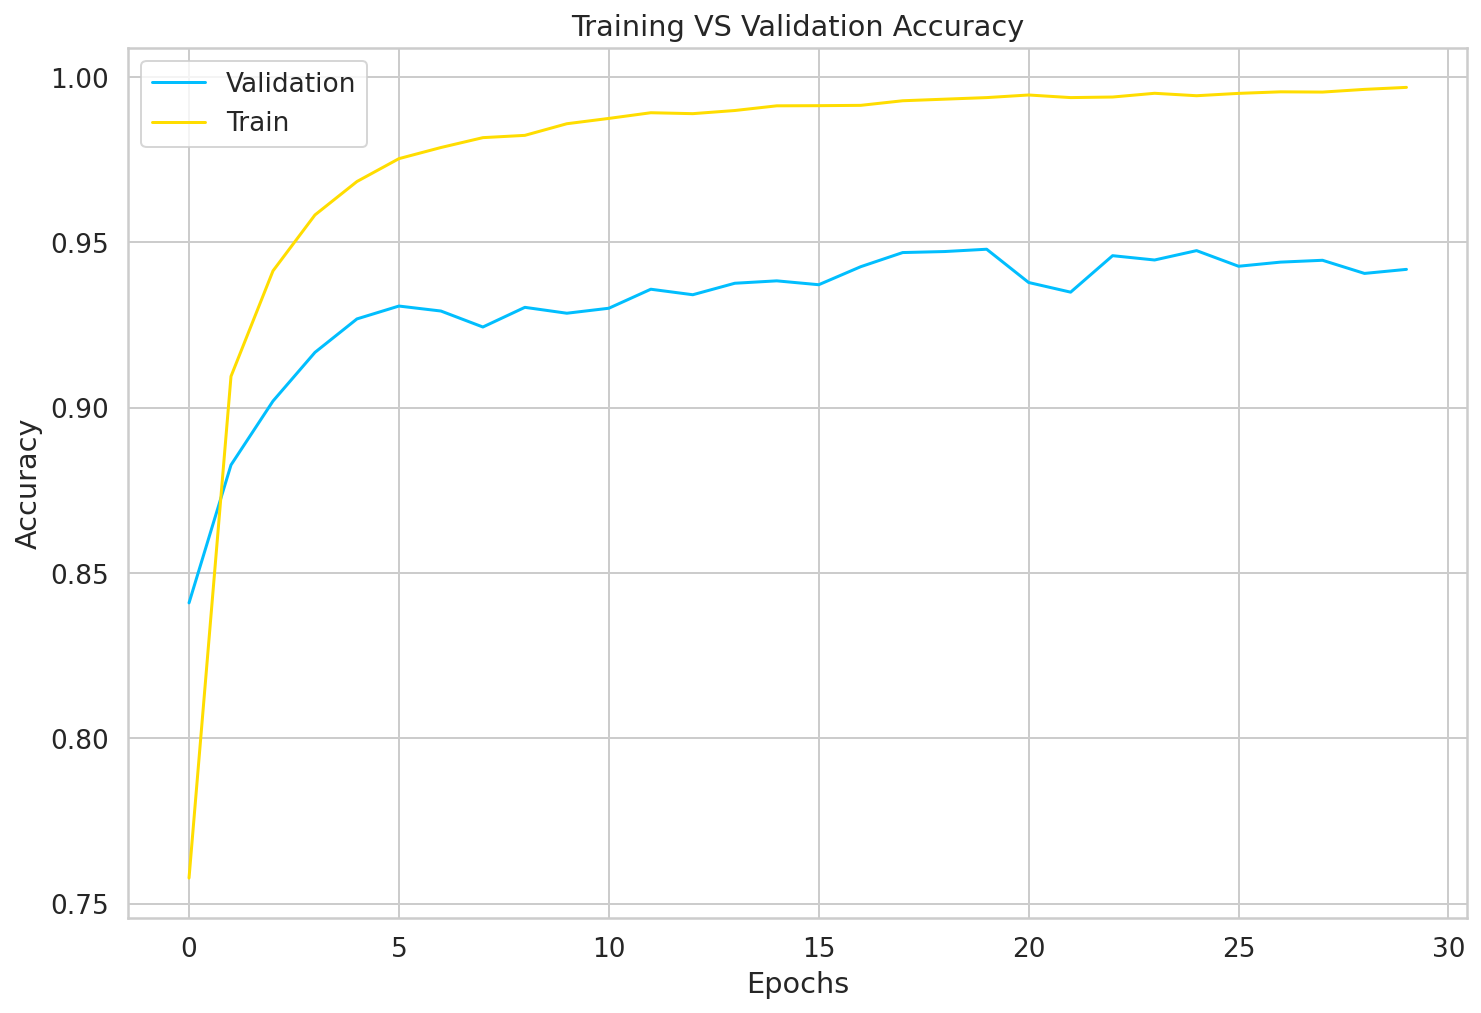

In [ ]:
####################################Setting 10
class TransferNet_4(nn.Module):
    def __init__(self):
        super(TransferNet_4, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 3072)
        self.layer2 = nn.Linear(3072, 768) 
        self.layer3 = nn.Linear(768, 128) 
        self.layer4 = nn.Linear(128, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

####################################Setting 10
learning_rate = 0.00005
num_epochs = 30

use_cuda = True
model_9 = TransferNet_4()

if use_cuda and torch.cuda.is_available():
  model_9.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_9, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

CUDA is available!  Training on GPU ...
Training Started...
epoch =  0
0 0.8658248125024544 0.8733158871566444
epoch =  1
1 0.9354842148662976 0.9068838158871567
epoch =  2
2 0.9515499862567243 0.9139745731254639
epoch =  3
3 0.9581726155416814 0.9206486636971047
epoch =  4
4 0.9637827973455845 0.9100202301410543
epoch =  5
5 0.9688028625279774 0.9230918708240534
epoch =  6
6 0.9722723917226215 0.9188344469190795
epoch =  7
7 0.9763697530137041 0.9139368968077208
epoch =  8
8 0.9792796363921938 0.9248912397921306
epoch =  9
9 0.9797463776652139 0.9237813659985151
epoch =  10
10 0.9814927553304276 0.927231997030438
epoch =  11
11 0.981913790395414 0.92575853749072
epoch =  12
12 0.9822796363921937 0.9050770230141054
epoch =  13
13 0.9845388345702282 0.9254252041573867
epoch =  14
14 0.9828413240664393 0.9183609873793616
epoch =  15
15 0.9841001492127066 0.919978285077951
epoch =  16
16 0.9846694545882908 0.9165011135857462
epoch =  17
17 0.984882200494758 0.9296752041573868
epoch =  18


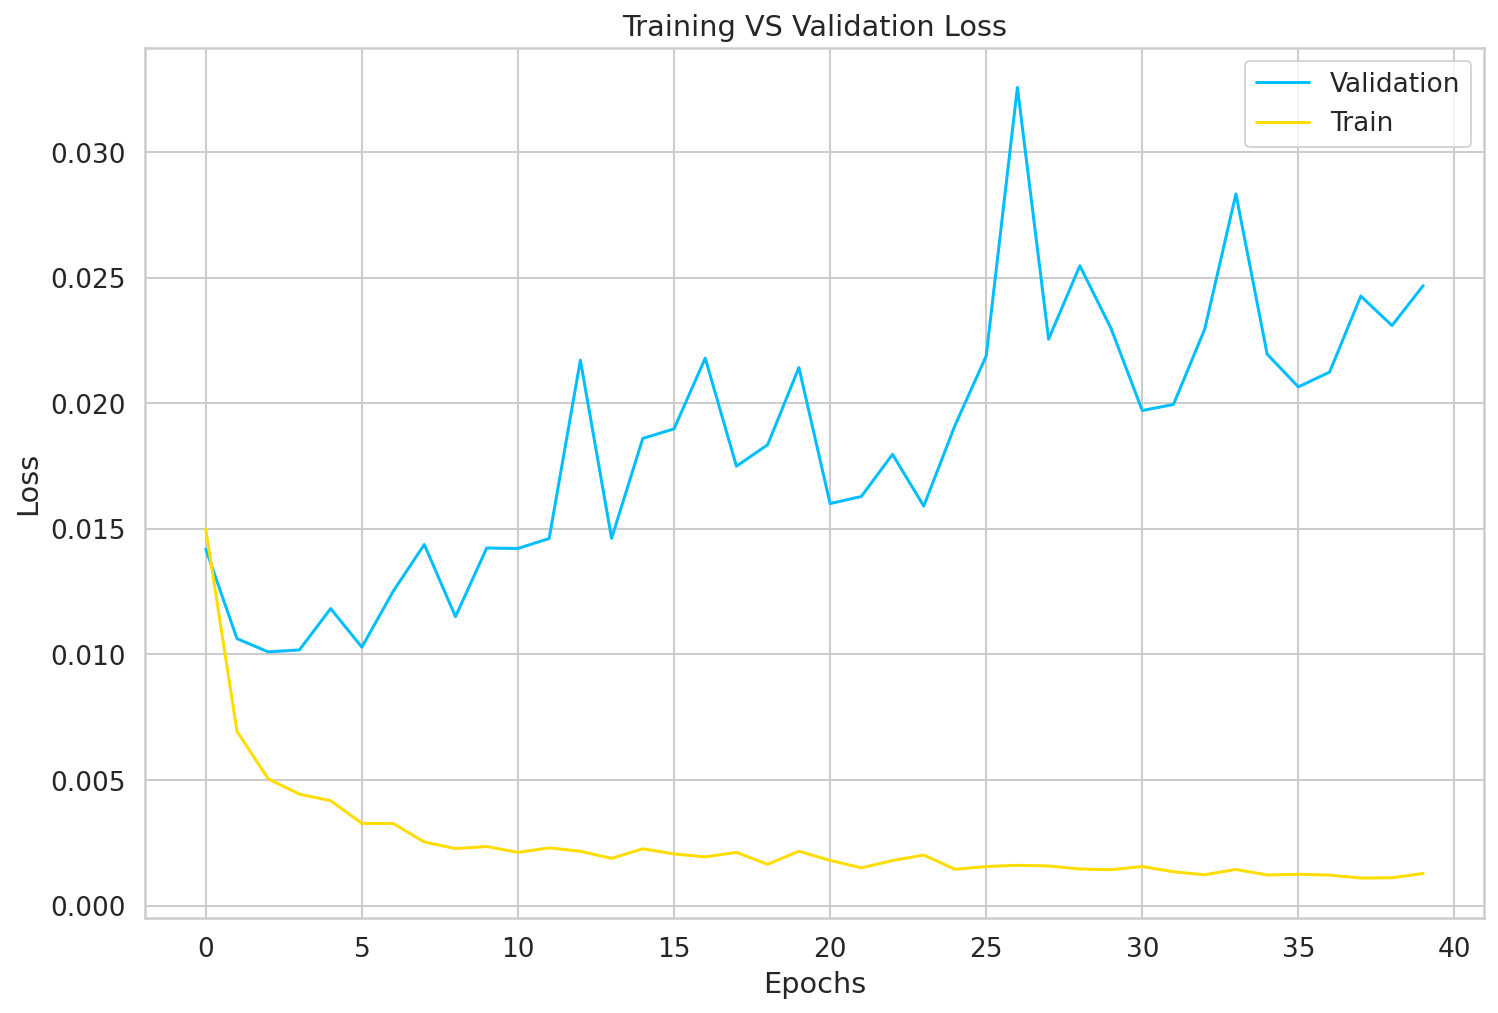

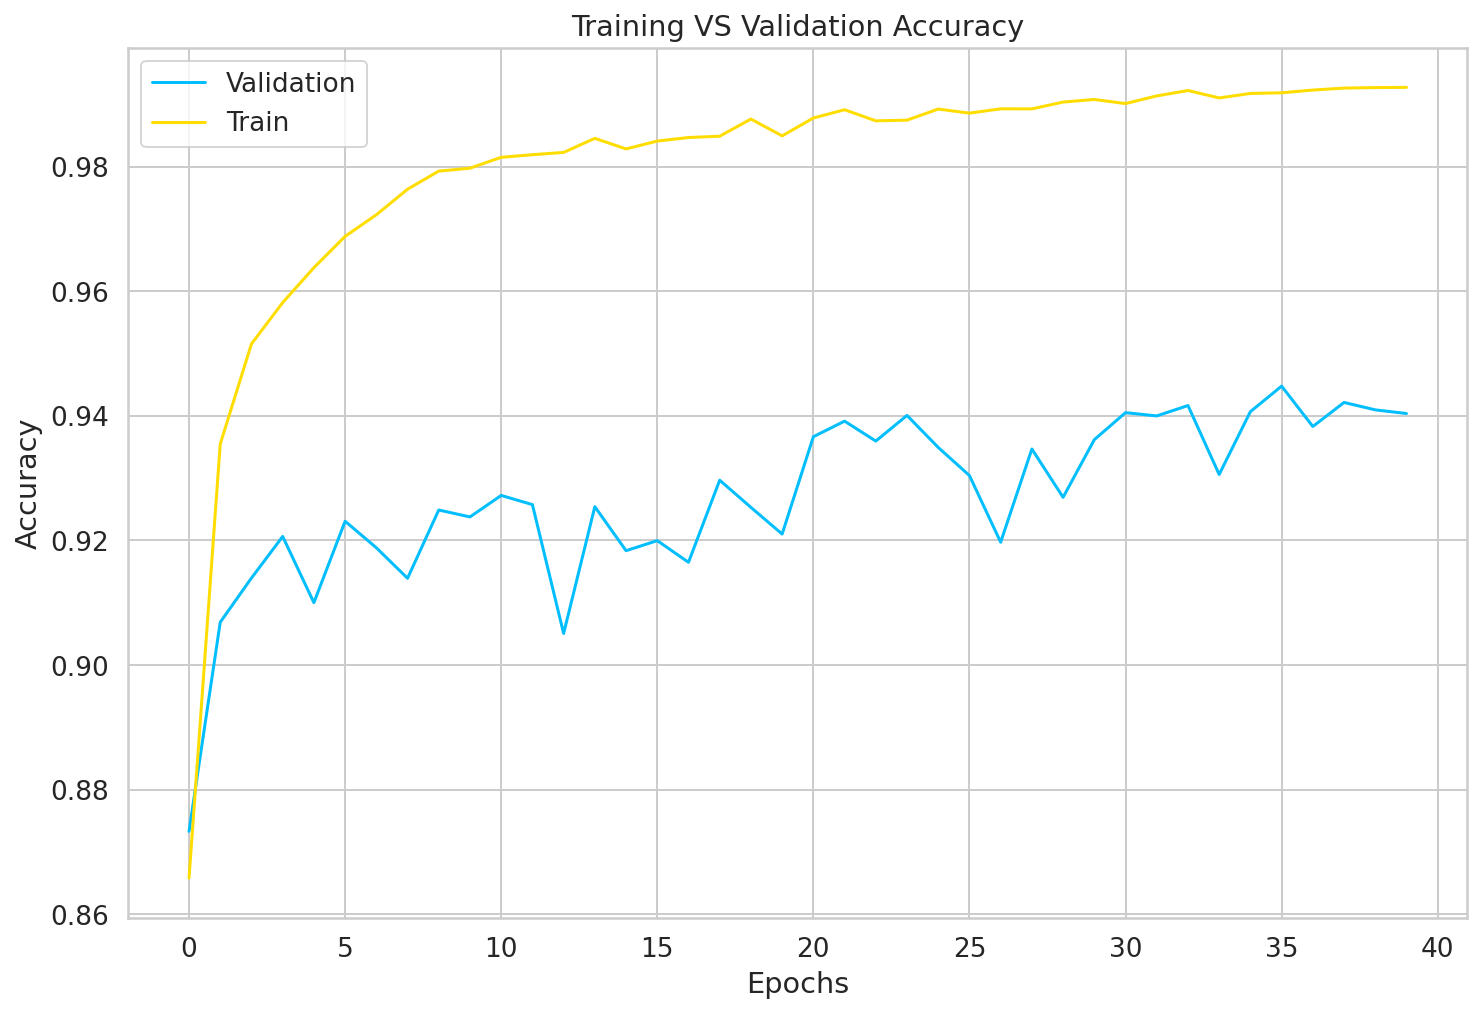

In [ ]:
####################################Setting 11
learning_rate = 0.0015
num_epochs = 40

use_cuda = True
# model = base_model
model_2 = TransferNet()
if use_cuda and torch.cuda.is_available():
  model_2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  

train_acc, val_acc, train_loss, val_loss, epoches = primary_train(model_2, num_epochs, learning_rate, use_cuda=True)
plot_curve(epoches = epoches, train_acc = train_acc, val_acc = val_acc, train_loss = train_loss, val_loss = val_loss, test_data=False)

##Save Trained Model

In [ ]:
model_save_name = 'AlexNet_9.pt'
path = F"/content/data_all/{model_save_name}" 
torch.save(model_9.state_dict(), path)

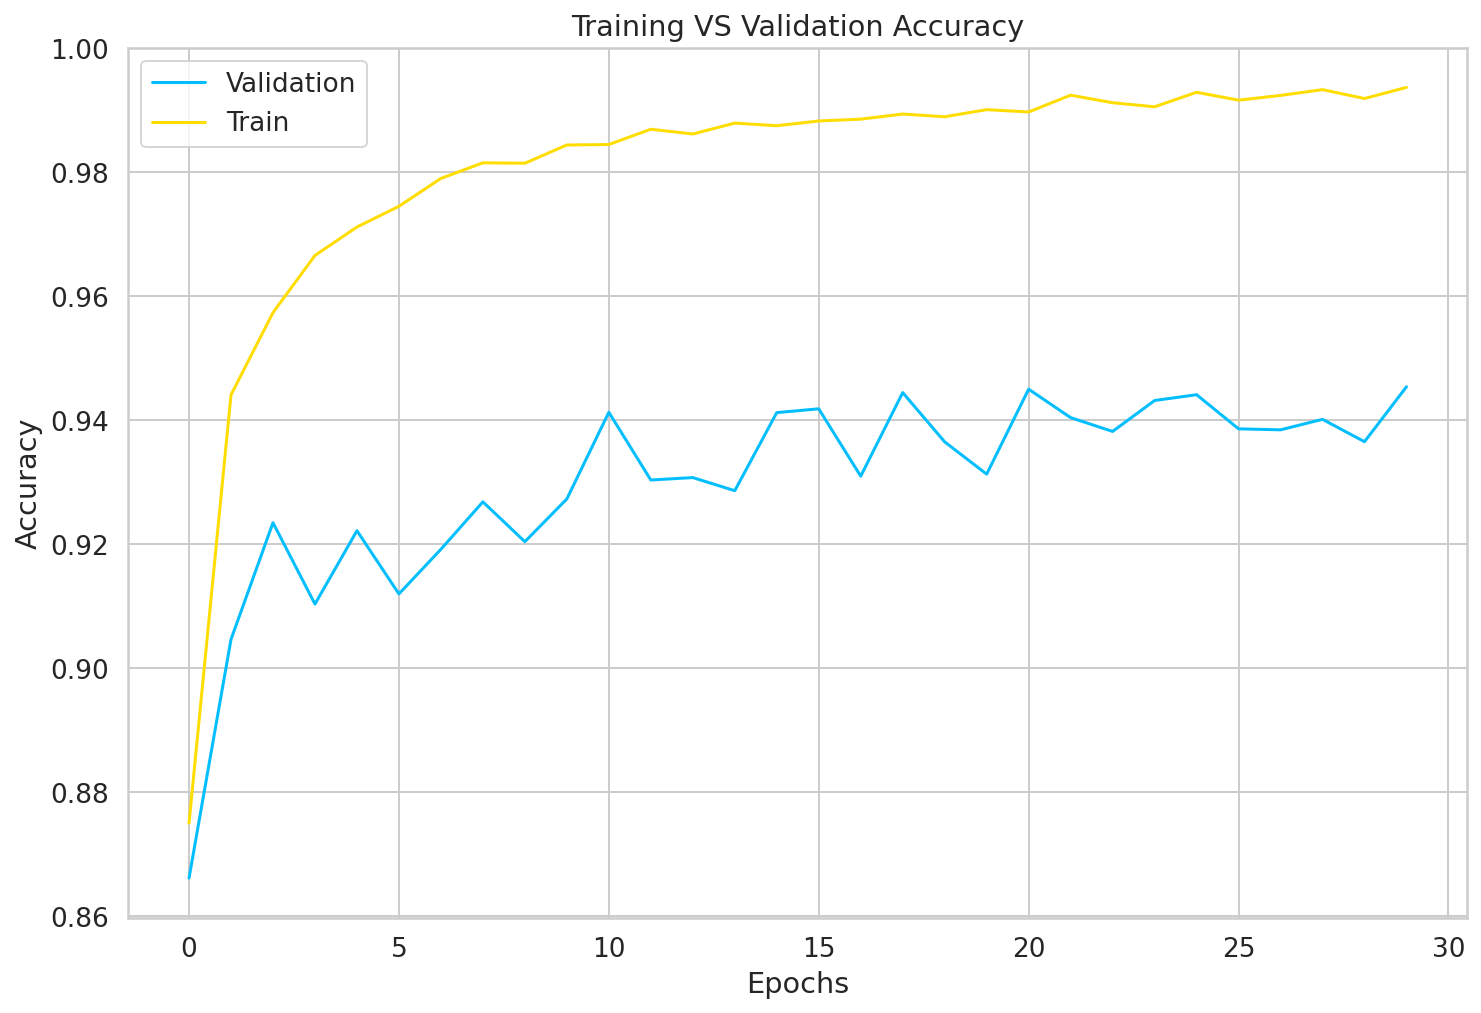

In [ ]:
epoches = list(range(0,30))
plot_curve(losses = 0, iters = 0, epoches = epoches, train_acc = train_acc, val_acc = val_acc, test_data=False)

In [ ]:
test_feature_path = glob(f'{master_path}/features/test_features*.npy')
test_acc_features = 0

for test_path in test_feature_path:
    test_features = np.load(f'{test_path}', allow_pickle=True)
    test_acc_features += get_accuracy(model, test_features)

test_acc_features = test_acc_features/len(test_feature_path)
print("Test accuracy: ", test_acc_features)

Test accuracy:  0.9456694915254238


# Reload model and features

In [ ]:
# zip the features

# !tar zcf feature.tar.gz ./data_all/features/

In [ ]:
# unzip features && need to upload the saved model into '/content/data_all'
# !scp chaoshan@192.168.0.12://Users/chaoshan/Downloads/AlexNet_new.pt ./
!tar xvf ./feature_new.tar.gz

./data_all/features/
./data_all/features/train_features_8.npy
./data_all/features/train_features_12.npy
./data_all/features/train_features_11.npy
./data_all/features/test_features_2.npy
./data_all/features/train_features_7.npy
./data_all/features/train_features_6.npy
./data_all/features/train_features_22.npy
./data_all/features/train_features_9.npy
./data_all/features/train_features_3.npy
./data_all/features/val_features_1.npy
./data_all/features/train_features_1.npy
./data_all/features/train_features_2.npy
./data_all/features/train_features_23.npy
./data_all/features/train_features_19.npy
./data_all/features/train_features_5.npy
./data_all/features/train_features_24.npy
./data_all/features/train_features_0.npy
./data_all/features/train_features_13.npy
./data_all/features/test_features_1.npy
./data_all/features/train_features_18.npy
./data_all/features/train_features_17.npy
./data_all/features/test_features_3.npy
./data_all/features/train_features_15.npy
./data_all/features/train_featu

In [ ]:
class TransferNet(nn.Module):
    def __init__(self):
        super(TransferNet, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 1024)
        self.layer2 = nn.Linear(1024, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

class TransferNet_4(nn.Module):
    def __init__(self):
        super(TransferNet_4, self).__init__()
        self.name = "TransferNet"
        self.layer1 = nn.Linear(256 * 6 * 6, 3072)
        self.layer2 = nn.Linear(3072, 768) 
        self.layer3 = nn.Linear(768, 128) 
        self.layer4 = nn.Linear(128, 43) 
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [ ]:
# reload saved model
model_save_name = 'AlexNet_9.pt'
path = F"/content/data_all/{model_save_name}" 

model = TransferNet_4()
model.load_state_dict(torch.load(path))
model.cuda()

TransferNet_4(
  (layer1): Linear(in_features=9216, out_features=3072, bias=True)
  (layer2): Linear(in_features=3072, out_features=768, bias=True)
  (layer3): Linear(in_features=768, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=43, bias=True)
)

In [ ]:
master_path = '/content/data_all/'
test_feature_path = glob(f'{master_path}/features/test_features*.npy')
test_acc_features = 0
use_cuda = True

for test_path in test_feature_path:
    test_features = np.load(f'{test_path}', allow_pickle=True)
    test_acc_features += get_accuracy(model, test_features)

test_acc_features = test_acc_features/len(test_feature_path)
print("Test accuracy: ", test_acc_features)

Test accuracy:  0.9456101694915254


In [ ]:
def get_accuracy_for_confusion(model, data_loader):
    correct = 0
    total = 0
    correct_label = []
    pred_label = []
    for imgs, labels in data_loader:
        correct_label.extend(labels)
        # print(": ", labels)
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        # print("output: ", output)
        pred = output.max(1, keepdim=True)[1]
        # print("pred: ", pred)
        pred_label.extend(pred)
        # print(type(pred))
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total, correct_label, pred_label

In [ ]:
master_path = '/content/data_all/'
test_feature_path = glob(f'{master_path}/features/test_features*.npy')
test_acc_features = 0
correct_label, pred_label = [], []
use_cuda = True

for test_path in test_feature_path:
    test_features = np.load(f'{test_path}', allow_pickle=True)
    acc, corr, pred = get_accuracy_for_confusion(model, test_features)
    test_acc_features += acc
    correct_label.extend(corr)
    pred_label.extend(pred)
test_acc_features = test_acc_features/len(test_feature_path)
print("Test accuracy: ", test_acc_features)
print("correct_label: ", len(correct_label))
print("pred_label: ", len(pred_label))
conf_matrix = confusion_matrix(correct_label, pred_label)
show_confusion_matrix(conf_matrix, class_names)

###Show Predicted Label and True Label with images

In [ ]:
# img = Image.open('/content/data_all/70-speed-limit.jpg')
# img = img.convert('RGB')

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
alexnet = torchvision.models.alexnet(pretrained=True)
test_dataset = torchvision.datasets.ImageFolder('/content/data_all/test/', 
                                                       transform=transform)
    
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=30, 
                                               num_workers=1, 
                                               shuffle=True)  
# img = transform(img).unsqueeze(0)

for img, labels in test_loader:
    imgs = alexnet.features(img)
    fig = plt.figure(figsize=(50, 20))
    for idx in np.arange(24):
        ax = fig.add_subplot(5, 6, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(img[idx], (1, 2, 0)))
        ax.set_title(labels[idx])
    break
imgs = imgs.cuda()
  # print(imgs)
model.cuda()

output = model(imgs)
pred = output.max(1, keepdim=True)[1]
print("pred =. ", pred.squeeze(-1))
  # pred = F.softmax(output, dim=1)



  

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
imgs = Image.open('/content/data_all/test_img/Screen Shot 2020-12-05 at 10.49.07 PM.png')
# imgs = Image.open('/content/data_all/test_img/stop.png')
# imgs = Image.open('/content/data_all/test_img/passenger.png')
# imgs = Image.open('/content/data_all/test_img/Screen Shot 2020-12-05 at 10.49.07 PM.png')
imgs = imgs.convert('RGB')

transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])
alexnet = torchvision.models.alexnet(pretrained=True)
# test_dataset = torchvision.datasets.ImageFolder('/content/data/test/', 
#                                                        transform=transform)
    
# test_loader = torch.utils.data.DataLoader(test_dataset, 
#                                                batch_size=24, 
#                                                num_workers=1, 
#                                                shuffle=True)  
imgs = transform(imgs).unsqueeze(0)

# for img, labels in test_loader:
#     imgs = alexnet.features(img)
#     fig = plt.figure(figsize=(25, 4))
#     for idx in np.arange(24):
#         ax = fig.add_subplot(2, 24/2, idx+1, xticks=[], yticks=[])
#         plt.imshow(np.transpose(img[idx], (1, 2, 0)))
#         ax.set_title(labels[idx])
#     break
imgs = alexnet.features(imgs)
imgs = imgs.cuda()
model.cuda()

output = model(imgs)
# pred = output.max(1, keepdim=True)[1]
pred = F.softmax(output, dim=1)
# pred = pred.max(1, keepdim=True)[1]

print("output =. ", output)
print("pred =. ", pred)

output =.  tensor([[-21.1490, -29.2089, -32.1964, -40.5361, -40.5361,  -0.4482, -20.1074,
         -46.6206, -21.7259,  19.6238,   4.7774, -33.7767, -13.0843, -18.5601,
          -8.2432,  23.5497, -10.2293, -11.7275,  25.8705, -21.2814, -21.8438,
         -33.7595, -18.4747, -66.5933,   4.0328, -42.2079,  -7.3002,  -8.0758,
         -22.9515, -20.3405,  17.6030, -16.2755, -41.5519, -26.2141, -30.6781,
         -22.1072, -12.5635, -15.1806, -14.8953,  11.2617,   9.5051, -16.3887,
         -14.2615]], device='cuda:0', grad_fn=<AddmmBackward>)
pred =.  tensor([[3.4526e-21, 1.0909e-24, 5.4994e-26, 1.3135e-29, 1.3136e-29, 3.3761e-12,
         9.7839e-21, 2.9923e-32, 1.9392e-21, 1.7603e-03, 6.2788e-10, 1.1324e-26,
         1.0981e-17, 4.5972e-20, 1.3901e-15, 8.9241e-02, 1.9078e-16, 4.2644e-17,
         9.0876e-01, 3.0246e-21, 1.7235e-21, 1.1521e-26, 5.0071e-20, 6.3384e-41,
         2.9817e-10, 2.4683e-30, 3.5695e-15, 1.6436e-15, 5.6931e-22, 7.7495e-21,
         2.3332e-04, 4.5154e-19, 4.756

In [ ]:
print(new_class[18])

No passing


In [ ]:
!tar zcf ./feature.tar.gz ./data_all/features/

[20 29 31  0 37 22 22 33 37  4  8  6 31  2 13 18 41 41 40 16 34 10 16  3]


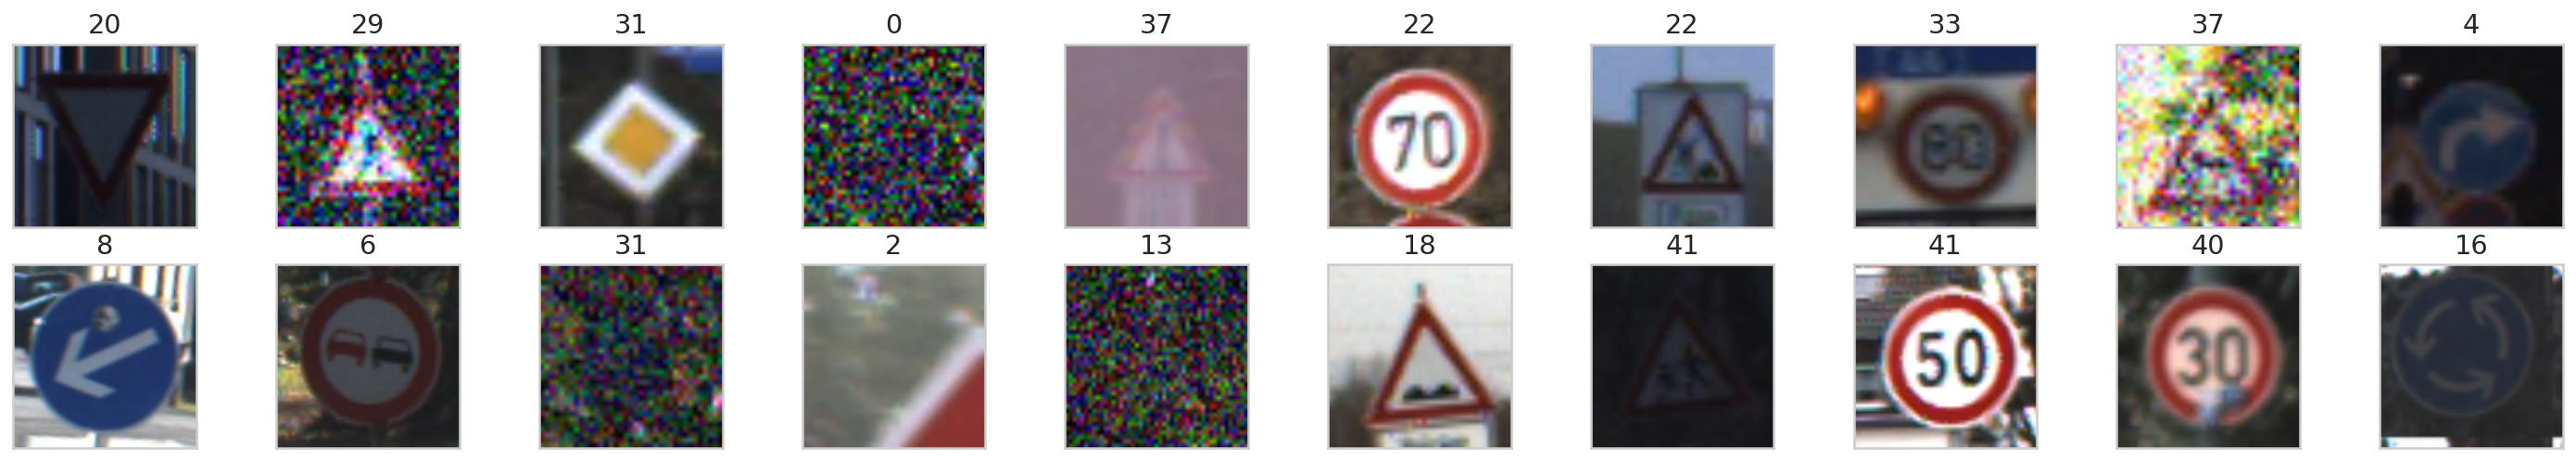

In [ ]:
# Verification Step - obtain one batch of images

print(labels)


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[idx], (1, 2, 0)))
    ax.set_title(labels[idx])